2022년 7월까지의 데이터를 학습하고 8,9,10월의 데이터를 예측할것

In [34]:
import pandas as pd
import numpy as np
from haversine import haversine
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow import keras
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
import random
import itertools
from sklearn import linear_model

함수정의

In [35]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [36]:
#기준 아파트로부터 'near_range' km 내에 존재하는 아파트 코드 반환
def finding_near_apt(gizun,near_range):
    start = (float(gizun['GPS_Y']),float(gizun['GPS_X']))
    near_apts = []
    for j in df_range.index:
        goal = (float(df_range['GPS_Y'][j]),float(df_range['GPS_X'][j]))
        if haversine(start, goal) < near_range:
            near_apts.append(df_range['apart_code'][j])
    near_df = pd.DataFrame()
    near_df['apart_code'] = near_apts
    return near_df

In [37]:
#사용하지 않을 과거 데이터 제거(윈도우 사이즈가 3일경우)
def delete_unuse_var(reframed):
    var_count = int(len(reframed.columns)/4)
    reframed.drop(reframed.columns[var_count*2:(var_count*3) - 1], axis=1, inplace=True)
    reframed.drop(reframed.columns[var_count:(var_count*2) - 1], axis=1, inplace=True)
    reframed.drop(reframed.columns[0:var_count - 1], axis=1, inplace=True)
    return reframed

In [38]:
#데이터프레임에서 일정한 컬럼만 추출하고 값 형태로 반환
def get_float_values(df):
    df = df[['YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','crime_rate', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'PIR', 'LIR', 'GDP', 'GDI', 
    'GNI', 'CPI','avg_interest', 'kospi', 'M2', 'house_CCSI', 'unsold','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    values = df.values
    values = values.astype('float32')
    return values

In [39]:
#코드들로부터 값을 추출하고 합치기
def get_from_codes(codes):
    for j in codes:
        df1 = globals()['df_'+j]
        values = get_float_values(df1)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        global df_all
        df_all = pd.concat([reframed,df_all])
    return df_all

In [40]:
#추가하고 싶은 달을 입력
def make_future_data(new_month):
    new_df = df.drop_duplicates(subset = ['apart_code','area_m3'])
    new_df['YYYYMM'] = 202200 + new_month
    new_df['crime_rate'] = np.nan
    new_df['ASPI'] = np.nan
    new_df['YYYY'] = 2022
    new_df['MM'] = new_month
    new_df['HAI'] = np.nan
    new_df['PIR'] = np.nan
    new_df['LIR'] = np.nan
    new_df['GDP'] = np.nan
    new_df['GDI'] = np.nan
    new_df['GNI'] = np.nan
    new_df['CPI'] = np.nan
    new_df['avg_interest'] = np.nan
    new_df['kospi'] = np.nan
    new_df['M2'] = np.nan
    new_df['house_CCSI'] = np.nan
    new_df['unsold'] = np.nan
    #가격은 뭘로 할건지
    new_df['prices'] = 0 
    return new_df

In [41]:
def fill_nan(X_list,Y,df_a,df_pred):
    lin_reg = linear_model.LinearRegression()
    x = df_a.dropna(axis=0)[X_list]
    y = df_a.dropna(axis=0)[Y]
    lin_reg_model = lin_reg.fit(x,y)
    y_pred = lin_reg_model.predict(df_pred.loc[:, X_list])
    df_pred[Y] = np.where(df_pred[Y].isnull(),pd.Series(y_pred.flatten()),df_pred[Y])
    return df_a

파일 읽기

In [42]:
df = pd.read_csv('final6.csv',encoding='cp949')

In [43]:
#결측값 제거
df = df[df['sale_type'].notna()]
df = df[df['parking'].notna()]
df = df[df['HAI'].notna()]
df = df[df['M2'].notna()]
#정성적변수 정량적 변수로 변환
df.loc[df['sale_type'] == '분양', 'sale_type'] = 0
df.loc[df['sale_type'] == '임대+분양', 'sale_type'] = 1
df.loc[df['sale_type'] == '임대', 'sale_type'] = 2
df.loc[df['sale_type'] == '영구임대', 'sale_type'] = 3
df['area_m3']=df['area_m3'].round(-1)
df = df.astype({'prices':'float64'})
df['prices']=df.groupby(['YYYYMM','apart_code','area_m3'])['prices'].transform('mean')
df['apart_code_area'] = df['apart_code'].map(str) +'_' +df['area_m3'].map(int).map(str)
df_a = df
exiting_code = df['apart_code'].unique()
df_vary = df.drop_duplicates(['apart_code'])
df_range = df_vary[['apart_code','GPS_X','GPS_Y']]
many_df = pd.read_csv('서울시아파트(기준).csv',encoding='cp949')
many_df = many_df[many_df['k-아파트코드'].isin(exiting_code)]

예측하고 싶은 값 추가

In [46]:
print(df[['apart_code_area','unsold','YYYYMM']])

       apart_code_area  unsold  YYYYMM
0        A10024240_100  1890.0  201201
1        A10024240_100  1890.0  201201
2         A10024240_80  1890.0  201201
3        A10024240_100  1890.0  201201
4        A10024240_100  1703.0  201202
...                ...     ...     ...
725041    A10023991_70    47.0  202202
725044    A10024359_30    47.0  202202
725045    A10024359_10    47.0  202202
725046    A10024359_10   180.0  202203
725047    A10024359_20   180.0  202203

[717264 rows x 3 columns]


In [ ]:
#df_prediction에 결측값 넣기
df_predction_8 = make_future_data(8)
df_predction_8 = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a,df_predction_8)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_predction_8 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_8)
df_predction_8 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_8)
df_predction_9 = make_future_data(9)
df_predction_9 = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a,df_predction_9)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_predction_9 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_9)
df_predction_9 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_9)
df_predction_10 = make_future_data(10)
df_predction_10 = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a,df_predction_10)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_predction_10 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_10)
df_predction_10 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_10)
df_predction_11 = make_future_data(11)
df_predction_11 = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a,df_predction_11)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_predction_11 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_11)
df_predction_11 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_11)
df_predction_12 = make_future_data(12)
df_predction_12 = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a,df_predction_12)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_predction_12 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_12)
df_predction_12 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_12)

In [48]:
#df_prediction_8 과 df_all을 결합
df_a = pd.concat([df_a,df_predction_8], ignore_index=False)

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

실제로 돌아가는 모델

8월 추가

In [50]:
#6분정도 걸리는듯
#exiting_code = df['apart_code'].unique()
test_codes = random.sample(list(exiting_code),10)
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','crime_rate', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'PIR', 'LIR', 'GDP', 'GDI', 
    'GNI', 'CPI','avg_interest', 'kospi', 'M2', 'house_CCSI', 'unsold','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202208]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202208)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
#df_a를 기본 df로 다시 변경
df = df_a 

Epoch 1/50
60/60 - 9s - loss: 0.0737 - val_loss: 0.3002 - 9s/epoch - 143ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0522 - val_loss: 0.4120 - 296ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0400 - val_loss: 0.4499 - 274ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0384 - val_loss: 0.4162 - 321ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0435 - val_loss: 0.4405 - 314ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0340 - val_loss: 0.4190 - 413ms/epoch - 7ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0347 - val_loss: 0.3894 - 315ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0329 - val_loss: 0.3839 - 286ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0235 - val_loss: 0.3535 - 304ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0275 - val_loss: 0.3691 - 344ms/epoch - 6ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0206 - val_loss: 0.3684 - 371ms/epoch - 6ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0205 - val_loss: 0.4034 - 422ms/epoch - 7ms/step
Epoch 13/50
60/60 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.0912 - val_loss: 0.3048 - 4s/epoch - 71ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0499 - val_loss: 0.4892 - 256ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0418 - val_loss: 0.5288 - 279ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0419 - val_loss: 0.5460 - 281ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0342 - val_loss: 0.5697 - 249ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0465 - val_loss: 0.5561 - 238ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0317 - val_loss: 0.5150 - 238ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0275 - val_loss: 0.5246 - 240ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0219 - val_loss: 0.5590 - 243ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0362 - val_loss: 0.5042 - 271ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0308 - val_loss: 0.4698 - 269ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0301 - val_loss: 0.4658 - 290ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.0909 - val_loss: 0.3614 - 4s/epoch - 64ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0547 - val_loss: 0.5145 - 237ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0346 - val_loss: 0.5408 - 239ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0331 - val_loss: 0.5420 - 254ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0314 - val_loss: 0.5139 - 253ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0290 - val_loss: 0.5650 - 245ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0298 - val_loss: 0.5594 - 246ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0416 - val_loss: 0.5013 - 244ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.5724 - 247ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0266 - val_loss: 0.5340 - 264ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0233 - val_loss: 0.5111 - 249ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0194 - val_loss: 0.5526 - 242ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.0826 - val_loss: 0.3496 - 4s/epoch - 73ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0488 - val_loss: 0.5215 - 245ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0355 - val_loss: 0.6196 - 238ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0423 - val_loss: 0.6462 - 261ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0463 - val_loss: 0.6217 - 264ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0411 - val_loss: 0.5846 - 255ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0410 - val_loss: 0.5140 - 253ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0294 - val_loss: 0.4767 - 253ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0298 - val_loss: 0.4619 - 298ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0259 - val_loss: 0.4768 - 236ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0203 - val_loss: 0.4815 - 239ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0188 - val_loss: 0.5202 - 235ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.0853 - val_loss: 0.3868 - 4s/epoch - 59ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0552 - val_loss: 0.5013 - 398ms/epoch - 7ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0419 - val_loss: 0.6772 - 254ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0444 - val_loss: 0.6807 - 318ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0429 - val_loss: 0.6214 - 289ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0426 - val_loss: 0.6023 - 295ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0259 - val_loss: 0.6089 - 311ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0266 - val_loss: 0.5956 - 288ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0307 - val_loss: 0.6732 - 311ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0295 - val_loss: 0.5499 - 350ms/epoch - 6ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0274 - val_loss: 0.5453 - 445ms/epoch - 7ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0277 - val_loss: 0.6148 - 485ms/epoch - 8ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 6s - loss: 0.0848 - val_loss: 0.4198 - 6s/epoch - 97ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0534 - val_loss: 0.4988 - 237ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0436 - val_loss: 0.6206 - 239ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0486 - val_loss: 0.6194 - 260ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0418 - val_loss: 0.5748 - 389ms/epoch - 6ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0409 - val_loss: 0.5714 - 455ms/epoch - 8ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0289 - val_loss: 0.6118 - 373ms/epoch - 6ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0217 - val_loss: 0.6030 - 240ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0325 - val_loss: 0.6683 - 459ms/epoch - 8ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0255 - val_loss: 0.6335 - 340ms/epoch - 6ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0255 - val_loss: 0.6051 - 247ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0418 - val_loss: 0.5920 - 390ms/epoch - 6ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.0843 - val_loss: 0.3706 - 4s/epoch - 68ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0449 - val_loss: 0.5483 - 493ms/epoch - 8ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0333 - val_loss: 0.6126 - 323ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0552 - val_loss: 0.6301 - 395ms/epoch - 7ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0444 - val_loss: 0.6393 - 285ms/epoch - 5ms/step
Epoch 6/50
60/60 - 1s - loss: 0.0367 - val_loss: 0.6319 - 532ms/epoch - 9ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0360 - val_loss: 0.6001 - 434ms/epoch - 7ms/step
Epoch 8/50
60/60 - 1s - loss: 0.0299 - val_loss: 0.5657 - 534ms/epoch - 9ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0253 - val_loss: 0.5571 - 419ms/epoch - 7ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0230 - val_loss: 0.5538 - 323ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0193 - val_loss: 0.5176 - 435ms/epoch - 7ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0190 - val_loss: 0.4988 - 450ms/epoch - 7ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.0655 - val_loss: 0.3401 - 3s/epoch - 51ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0609 - val_loss: 0.4584 - 252ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0337 - val_loss: 0.5003 - 239ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0306 - val_loss: 0.4931 - 237ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0301 - val_loss: 0.5642 - 246ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0360 - val_loss: 0.5650 - 231ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0452 - val_loss: 0.5126 - 265ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0264 - val_loss: 0.5907 - 239ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0285 - val_loss: 0.5596 - 243ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0364 - val_loss: 0.4926 - 231ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0227 - val_loss: 0.5106 - 243ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0218 - val_loss: 0.5726 - 240ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.0918 - val_loss: 0.3870 - 3s/epoch - 52ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0615 - val_loss: 0.4965 - 249ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0428 - val_loss: 0.6737 - 248ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0449 - val_loss: 0.7247 - 238ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0598 - val_loss: 0.6485 - 240ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0439 - val_loss: 0.6258 - 250ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0384 - val_loss: 0.6070 - 288ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0323 - val_loss: 0.6457 - 271ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0294 - val_loss: 0.6896 - 268ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0237 - val_loss: 0.6804 - 346ms/epoch - 6ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0236 - val_loss: 0.7148 - 358ms/epoch - 6ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0204 - val_loss: 0.7658 - 361ms/epoch - 6ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.0814 - val_loss: 0.5659 - 3s/epoch - 58ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0549 - val_loss: 0.7287 - 334ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0371 - val_loss: 0.8015 - 308ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0362 - val_loss: 0.8245 - 310ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0297 - val_loss: 0.8444 - 353ms/epoch - 6ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0242 - val_loss: 0.8415 - 298ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0237 - val_loss: 0.8494 - 315ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0243 - val_loss: 0.7605 - 265ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0305 - val_loss: 0.8214 - 247ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0430 - val_loss: 0.9398 - 301ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.8792 - 303ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0288 - val_loss: 0.8753 - 256ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.0722 - val_loss: 0.3334 - 4s/epoch - 63ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0550 - val_loss: 0.3997 - 235ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0351 - val_loss: 0.4154 - 240ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0350 - val_loss: 0.3879 - 234ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0336 - val_loss: 0.3949 - 239ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0328 - val_loss: 0.3938 - 238ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0468 - val_loss: 0.3322 - 247ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0303 - val_loss: 0.3396 - 475ms/epoch - 8ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0225 - val_loss: 0.3490 - 366ms/epoch - 6ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0232 - val_loss: 0.3298 - 280ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0258 - val_loss: 0.2717 - 267ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0433 - val_loss: 0.2809 - 294ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.0733 - val_loss: 0.3536 - 4s/epoch - 69ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0491 - val_loss: 0.4925 - 250ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0613 - val_loss: 0.4567 - 247ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0493 - val_loss: 0.4440 - 301ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0355 - val_loss: 0.4456 - 313ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0310 - val_loss: 0.4441 - 270ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0257 - val_loss: 0.4554 - 331ms/epoch - 6ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0350 - val_loss: 0.4192 - 470ms/epoch - 8ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0304 - val_loss: 0.3692 - 426ms/epoch - 7ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0254 - val_loss: 0.3651 - 456ms/epoch - 8ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0257 - val_loss: 0.2976 - 356ms/epoch - 6ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0337 - val_loss: 0.2894 - 390ms/epoch - 6ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 8s - loss: 0.0762 - val_loss: 0.4451 - 8s/epoch - 165ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0443 - val_loss: 0.3857 - 450ms/epoch - 9ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0334 - val_loss: 0.3548 - 491ms/epoch - 10ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0298 - val_loss: 0.3083 - 380ms/epoch - 8ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0470 - val_loss: 0.2390 - 314ms/epoch - 7ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0463 - val_loss: 0.3335 - 341ms/epoch - 7ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0334 - val_loss: 0.4410 - 388ms/epoch - 8ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0428 - val_loss: 0.4020 - 268ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0219 - val_loss: 0.3992 - 373ms/epoch - 8ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0225 - val_loss: 0.3977 - 363ms/epoch - 8ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0217 - val_loss: 0.4121 - 310ms/epoch - 6ms/step
Epoch 12/50
48/48 - 1s - loss: 0.0237 - val_loss: 0.3956 - 540ms/epoch - 11ms/step
Epoch 13/50
48/48 - 0s -

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 6s - loss: 0.0865 - val_loss: 0.4959 - 6s/epoch - 115ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0530 - val_loss: 0.4812 - 260ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0398 - val_loss: 0.4568 - 308ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0310 - val_loss: 0.4376 - 300ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0379 - val_loss: 0.4468 - 311ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0312 - val_loss: 0.4459 - 281ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0422 - val_loss: 0.5194 - 361ms/epoch - 8ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0312 - val_loss: 0.4686 - 247ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0191 - val_loss: 0.4427 - 380ms/epoch - 8ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0222 - val_loss: 0.4021 - 304ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0338 - val_loss: 0.4428 - 310ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0365 - val_loss: 0.3949 - 305ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 6s - loss: 0.0867 - val_loss: 0.5850 - 6s/epoch - 117ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0637 - val_loss: 0.4927 - 282ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0488 - val_loss: 0.4610 - 268ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0287 - val_loss: 0.4362 - 266ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0281 - val_loss: 0.3962 - 282ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0328 - val_loss: 0.3461 - 308ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0322 - val_loss: 0.3048 - 441ms/epoch - 9ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0496 - val_loss: 0.3474 - 274ms/epoch - 6ms/step
Epoch 9/50
48/48 - 1s - loss: 0.0407 - val_loss: 0.5266 - 515ms/epoch - 11ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0504 - val_loss: 0.4652 - 310ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0319 - val_loss: 0.4081 - 301ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0223 - val_loss: 0.4033 - 295ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 7s - loss: 0.0831 - val_loss: 0.5023 - 7s/epoch - 153ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0648 - val_loss: 0.4452 - 304ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0363 - val_loss: 0.4410 - 443ms/epoch - 9ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0350 - val_loss: 0.5100 - 454ms/epoch - 9ms/step
Epoch 5/50
48/48 - 1s - loss: 0.0302 - val_loss: 0.5310 - 520ms/epoch - 11ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0409 - val_loss: 0.5521 - 397ms/epoch - 8ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0249 - val_loss: 0.5563 - 311ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0307 - val_loss: 0.5810 - 247ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0254 - val_loss: 0.5832 - 281ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0208 - val_loss: 0.5582 - 271ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0244 - val_loss: 0.5128 - 266ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0423 - val_loss: 0.4895 - 278ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0767 - val_loss: 0.4955 - 5s/epoch - 108ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0475 - val_loss: 0.4864 - 199ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0331 - val_loss: 0.5168 - 203ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0314 - val_loss: 0.5842 - 204ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0444 - val_loss: 0.6941 - 198ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0572 - val_loss: 0.6472 - 201ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0319 - val_loss: 0.6251 - 216ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0279 - val_loss: 0.5924 - 209ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0454 - val_loss: 0.4429 - 213ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0414 - val_loss: 0.5174 - 219ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0205 - val_loss: 0.5864 - 246ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0246 - val_loss: 0.6279 - 245ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0925 - val_loss: 0.4891 - 5s/epoch - 109ms/step
Epoch 2/50
48/48 - 1s - loss: 0.0586 - val_loss: 0.4799 - 1s/epoch - 28ms/step
Epoch 3/50
48/48 - 1s - loss: 0.0371 - val_loss: 0.4325 - 1s/epoch - 21ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0414 - val_loss: 0.5506 - 460ms/epoch - 10ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0358 - val_loss: 0.5055 - 226ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0377 - val_loss: 0.5373 - 206ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0397 - val_loss: 0.4219 - 195ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0267 - val_loss: 0.4602 - 272ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0397 - val_loss: 0.3718 - 283ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0341 - val_loss: 0.4247 - 271ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0216 - val_loss: 0.4707 - 298ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0258 - val_loss: 0.5860 - 285ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
120/120 - 7s - loss: 0.0929 - val_loss: 0.5157 - 7s/epoch - 60ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0521 - val_loss: 0.5589 - 717ms/epoch - 6ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0385 - val_loss: 0.5681 - 1s/epoch - 11ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0327 - val_loss: 0.5777 - 1s/epoch - 9ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0312 - val_loss: 0.5987 - 773ms/epoch - 6ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0296 - val_loss: 0.5979 - 863ms/epoch - 7ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0350 - val_loss: 0.7155 - 887ms/epoch - 7ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0334 - val_loss: 0.6101 - 1s/epoch - 9ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0237 - val_loss: 0.6412 - 710ms/epoch - 6ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0236 - val_loss: 0.6096 - 641ms/epoch - 5ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0253 - val_loss: 0.6636 - 931ms/epoch - 8ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0243 - val_loss: 0.6435 - 789ms/epoch - 7ms/step
Epoch 13/50

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
120/120 - 4s - loss: 0.1098 - val_loss: 0.5076 - 4s/epoch - 30ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0506 - val_loss: 0.4545 - 501ms/epoch - 4ms/step
Epoch 3/50
120/120 - 0s - loss: 0.0412 - val_loss: 0.4612 - 463ms/epoch - 4ms/step
Epoch 4/50
120/120 - 0s - loss: 0.0322 - val_loss: 0.4615 - 469ms/epoch - 4ms/step
Epoch 5/50
120/120 - 0s - loss: 0.0283 - val_loss: 0.4922 - 483ms/epoch - 4ms/step
Epoch 6/50
120/120 - 0s - loss: 0.0295 - val_loss: 0.4843 - 489ms/epoch - 4ms/step
Epoch 7/50
120/120 - 0s - loss: 0.0303 - val_loss: 0.5383 - 483ms/epoch - 4ms/step
Epoch 8/50
120/120 - 0s - loss: 0.0289 - val_loss: 0.5447 - 495ms/epoch - 4ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0279 - val_loss: 0.5878 - 531ms/epoch - 4ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0266 - val_loss: 0.5305 - 503ms/epoch - 4ms/step
Epoch 11/50
120/120 - 0s - loss: 0.0242 - val_loss: 0.5323 - 478ms/epoch - 4ms/step
Epoch 12/50
120/120 - 0s - loss: 0.0258 - val_loss: 0.5663 - 471ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
120/120 - 4s - loss: 0.0964 - val_loss: 0.5173 - 4s/epoch - 35ms/step
Epoch 2/50
120/120 - 0s - loss: 0.0443 - val_loss: 0.4687 - 464ms/epoch - 4ms/step
Epoch 3/50
120/120 - 0s - loss: 0.0401 - val_loss: 0.5325 - 440ms/epoch - 4ms/step
Epoch 4/50
120/120 - 0s - loss: 0.0331 - val_loss: 0.5402 - 470ms/epoch - 4ms/step
Epoch 5/50
120/120 - 0s - loss: 0.0281 - val_loss: 0.5426 - 453ms/epoch - 4ms/step
Epoch 6/50
120/120 - 0s - loss: 0.0270 - val_loss: 0.5907 - 453ms/epoch - 4ms/step
Epoch 7/50
120/120 - 0s - loss: 0.0230 - val_loss: 0.5837 - 465ms/epoch - 4ms/step
Epoch 8/50
120/120 - 0s - loss: 0.0234 - val_loss: 0.5704 - 464ms/epoch - 4ms/step
Epoch 9/50
120/120 - 0s - loss: 0.0232 - val_loss: 0.5790 - 461ms/epoch - 4ms/step
Epoch 10/50
120/120 - 0s - loss: 0.0197 - val_loss: 0.5809 - 460ms/epoch - 4ms/step
Epoch 11/50
120/120 - 0s - loss: 0.0195 - val_loss: 0.5800 - 461ms/epoch - 4ms/step
Epoch 12/50
120/120 - 0s - loss: 0.0234 - val_loss: 0.5853 - 461ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
120/120 - 4s - loss: 0.1053 - val_loss: 0.4876 - 4s/epoch - 34ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0574 - val_loss: 0.4700 - 502ms/epoch - 4ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0403 - val_loss: 0.4458 - 542ms/epoch - 5ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0313 - val_loss: 0.4473 - 550ms/epoch - 5ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0330 - val_loss: 0.5108 - 617ms/epoch - 5ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0293 - val_loss: 0.4708 - 742ms/epoch - 6ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0251 - val_loss: 0.4917 - 682ms/epoch - 6ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0276 - val_loss: 0.5052 - 513ms/epoch - 4ms/step
Epoch 9/50
120/120 - 0s - loss: 0.0271 - val_loss: 0.5560 - 497ms/epoch - 4ms/step
Epoch 10/50
120/120 - 0s - loss: 0.0248 - val_loss: 0.4997 - 476ms/epoch - 4ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0240 - val_loss: 0.5216 - 502ms/epoch - 4ms/step
Epoch 12/50
120/120 - 0s - loss: 0.0223 - val_loss: 0.5023 - 499ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 6s - loss: 0.0968 - val_loss: 0.4462 - 6s/epoch - 215ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0624 - val_loss: 0.4990 - 137ms/epoch - 5ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0637 - val_loss: 0.5472 - 138ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0881 - val_loss: 0.5062 - 133ms/epoch - 5ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0920 - val_loss: 0.3874 - 137ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0752 - val_loss: 0.4122 - 137ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0471 - val_loss: 0.4130 - 145ms/epoch - 5ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0429 - val_loss: 0.3617 - 151ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0605 - val_loss: 0.3740 - 193ms/epoch - 7ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0635 - val_loss: 0.4360 - 155ms/epoch - 6ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0538 - val_loss: 0.4780 - 148ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0445 - val_loss: 0.4782 - 150ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 3s - loss: 0.1301 - val_loss: 0.4891 - 3s/epoch - 120ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0680 - val_loss: 0.4869 - 190ms/epoch - 7ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0622 - val_loss: 0.4711 - 185ms/epoch - 7ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0514 - val_loss: 0.4699 - 182ms/epoch - 6ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0405 - val_loss: 0.4407 - 208ms/epoch - 7ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0407 - val_loss: 0.4085 - 204ms/epoch - 7ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0485 - val_loss: 0.3097 - 225ms/epoch - 8ms/step
Epoch 8/50
28/28 - 0s - loss: 0.1170 - val_loss: 0.3993 - 285ms/epoch - 10ms/step
Epoch 9/50
28/28 - 0s - loss: 0.1134 - val_loss: 0.5259 - 197ms/epoch - 7ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0617 - val_loss: 0.4556 - 198ms/epoch - 7ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0379 - val_loss: 0.3980 - 172ms/epoch - 6ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0247 - val_loss: 0.4440 - 183ms/epoch - 7ms/step
Epoch 13/50
28/28 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 6s - loss: 0.0914 - val_loss: 0.5851 - 6s/epoch - 107ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0427 - val_loss: 0.7044 - 414ms/epoch - 7ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0305 - val_loss: 0.7971 - 351ms/epoch - 6ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0320 - val_loss: 0.8293 - 351ms/epoch - 6ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0312 - val_loss: 0.8756 - 354ms/epoch - 6ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0375 - val_loss: 0.8615 - 358ms/epoch - 6ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0471 - val_loss: 0.7548 - 358ms/epoch - 6ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0294 - val_loss: 0.7720 - 382ms/epoch - 7ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0227 - val_loss: 0.7310 - 378ms/epoch - 7ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0372 - val_loss: 0.6795 - 375ms/epoch - 7ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0485 - val_loss: 0.6403 - 380ms/epoch - 7ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0489 - val_loss: 0.7411 - 394ms/epoch - 7ms/step
Epoch 13/50
57/57 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 4s - loss: 0.0945 - val_loss: 0.5008 - 4s/epoch - 64ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0457 - val_loss: 0.5991 - 259ms/epoch - 5ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0465 - val_loss: 0.6006 - 270ms/epoch - 5ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0452 - val_loss: 0.6412 - 268ms/epoch - 5ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0454 - val_loss: 0.6928 - 270ms/epoch - 5ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0595 - val_loss: 0.6217 - 254ms/epoch - 4ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0539 - val_loss: 0.5040 - 237ms/epoch - 4ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0406 - val_loss: 0.4966 - 275ms/epoch - 5ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0305 - val_loss: 0.5271 - 239ms/epoch - 4ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0266 - val_loss: 0.5614 - 230ms/epoch - 4ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0197 - val_loss: 0.6258 - 243ms/epoch - 4ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0282 - val_loss: 0.6799 - 243ms/epoch - 4ms/step
Epoch 13/50
57/57 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 5s - loss: 0.0840 - val_loss: 0.5355 - 5s/epoch - 80ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0402 - val_loss: 0.6257 - 228ms/epoch - 4ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0308 - val_loss: 0.7100 - 227ms/epoch - 4ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0331 - val_loss: 0.7645 - 229ms/epoch - 4ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0531 - val_loss: 0.7481 - 217ms/epoch - 4ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0560 - val_loss: 0.7316 - 393ms/epoch - 7ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0661 - val_loss: 0.5601 - 352ms/epoch - 6ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0405 - val_loss: 0.5309 - 290ms/epoch - 5ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0374 - val_loss: 0.5774 - 277ms/epoch - 5ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0290 - val_loss: 0.6125 - 328ms/epoch - 6ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0231 - val_loss: 0.6873 - 332ms/epoch - 6ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0232 - val_loss: 0.7859 - 302ms/epoch - 5ms/step
Epoch 13/50
57/57 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
107/107 - 6s - loss: 0.0689 - val_loss: 0.5930 - 6s/epoch - 59ms/step
Epoch 2/50
107/107 - 1s - loss: 0.0356 - val_loss: 0.6548 - 551ms/epoch - 5ms/step
Epoch 3/50
107/107 - 1s - loss: 0.0280 - val_loss: 0.6589 - 578ms/epoch - 5ms/step
Epoch 4/50
107/107 - 1s - loss: 0.0276 - val_loss: 0.6929 - 576ms/epoch - 5ms/step
Epoch 5/50
107/107 - 1s - loss: 0.0335 - val_loss: 0.6843 - 575ms/epoch - 5ms/step
Epoch 6/50
107/107 - 1s - loss: 0.0419 - val_loss: 0.5870 - 581ms/epoch - 5ms/step
Epoch 7/50
107/107 - 1s - loss: 0.0456 - val_loss: 0.5485 - 585ms/epoch - 5ms/step
Epoch 8/50
107/107 - 1s - loss: 0.0350 - val_loss: 0.5849 - 574ms/epoch - 5ms/step
Epoch 9/50
107/107 - 1s - loss: 0.0257 - val_loss: 0.6293 - 574ms/epoch - 5ms/step
Epoch 10/50
107/107 - 1s - loss: 0.0235 - val_loss: 0.6367 - 566ms/epoch - 5ms/step
Epoch 11/50
107/107 - 1s - loss: 0.0211 - val_loss: 0.6400 - 577ms/epoch - 5ms/step
Epoch 12/50
107/107 - 1s - loss: 0.0199 - val_loss: 0.6445 - 563ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
107/107 - 6s - loss: 0.0687 - val_loss: 0.4936 - 6s/epoch - 52ms/step
Epoch 2/50
107/107 - 1s - loss: 0.0288 - val_loss: 0.4987 - 562ms/epoch - 5ms/step
Epoch 3/50
107/107 - 1s - loss: 0.0237 - val_loss: 0.4906 - 568ms/epoch - 5ms/step
Epoch 4/50
107/107 - 1s - loss: 0.0240 - val_loss: 0.5004 - 597ms/epoch - 6ms/step
Epoch 5/50
107/107 - 1s - loss: 0.0239 - val_loss: 0.5176 - 562ms/epoch - 5ms/step
Epoch 6/50
107/107 - 1s - loss: 0.0242 - val_loss: 0.4978 - 594ms/epoch - 6ms/step
Epoch 7/50
107/107 - 1s - loss: 0.0346 - val_loss: 0.5470 - 655ms/epoch - 6ms/step
Epoch 8/50
107/107 - 1s - loss: 0.0395 - val_loss: 0.4373 - 582ms/epoch - 5ms/step
Epoch 9/50
107/107 - 1s - loss: 0.0443 - val_loss: 0.3936 - 663ms/epoch - 6ms/step
Epoch 10/50
107/107 - 1s - loss: 0.0327 - val_loss: 0.4423 - 628ms/epoch - 6ms/step
Epoch 11/50
107/107 - 1s - loss: 0.0241 - val_loss: 0.4819 - 605ms/epoch - 6ms/step
Epoch 12/50
107/107 - 1s - loss: 0.0219 - val_loss: 0.4840 - 627ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
107/107 - 6s - loss: 0.0688 - val_loss: 0.5465 - 6s/epoch - 60ms/step
Epoch 2/50
107/107 - 1s - loss: 0.0318 - val_loss: 0.5988 - 553ms/epoch - 5ms/step
Epoch 3/50
107/107 - 1s - loss: 0.0263 - val_loss: 0.6066 - 658ms/epoch - 6ms/step
Epoch 4/50
107/107 - 1s - loss: 0.0258 - val_loss: 0.6251 - 653ms/epoch - 6ms/step
Epoch 5/50
107/107 - 1s - loss: 0.0270 - val_loss: 0.5781 - 879ms/epoch - 8ms/step
Epoch 6/50
107/107 - 1s - loss: 0.0293 - val_loss: 0.5955 - 646ms/epoch - 6ms/step
Epoch 7/50
107/107 - 1s - loss: 0.0311 - val_loss: 0.6001 - 512ms/epoch - 5ms/step
Epoch 8/50
107/107 - 1s - loss: 0.0452 - val_loss: 0.4576 - 607ms/epoch - 6ms/step
Epoch 9/50
107/107 - 1s - loss: 0.0390 - val_loss: 0.5064 - 800ms/epoch - 7ms/step
Epoch 10/50
107/107 - 1s - loss: 0.0318 - val_loss: 0.5191 - 535ms/epoch - 5ms/step
Epoch 11/50
107/107 - 0s - loss: 0.0273 - val_loss: 0.5458 - 458ms/epoch - 4ms/step
Epoch 12/50
107/107 - 0s - loss: 0.0234 - val_loss: 0.5687 - 442ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 5s - loss: 0.1038 - val_loss: 0.4192 - 5s/epoch - 84ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0770 - val_loss: 0.4409 - 271ms/epoch - 5ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0473 - val_loss: 0.4419 - 247ms/epoch - 4ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0381 - val_loss: 0.4721 - 224ms/epoch - 4ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0293 - val_loss: 0.4538 - 234ms/epoch - 4ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0265 - val_loss: 0.4603 - 307ms/epoch - 5ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0257 - val_loss: 0.4628 - 278ms/epoch - 5ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0241 - val_loss: 0.4654 - 242ms/epoch - 4ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0225 - val_loss: 0.4745 - 238ms/epoch - 4ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0218 - val_loss: 0.4729 - 238ms/epoch - 4ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0215 - val_loss: 0.4877 - 242ms/epoch - 4ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0214 - val_loss: 0.4686 - 322ms/epoch - 6ms/step
Epoch 13/50
57/57 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1181 - val_loss: 0.3909 - 4s/epoch - 143ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0680 - val_loss: 0.5992 - 133ms/epoch - 5ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0672 - val_loss: 0.6826 - 136ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0795 - val_loss: 0.6576 - 133ms/epoch - 5ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0734 - val_loss: 0.5894 - 134ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0544 - val_loss: 0.5474 - 131ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0384 - val_loss: 0.5768 - 142ms/epoch - 5ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0306 - val_loss: 0.6082 - 146ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0267 - val_loss: 0.6651 - 177ms/epoch - 6ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0274 - val_loss: 0.7350 - 198ms/epoch - 7ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0366 - val_loss: 0.8287 - 227ms/epoch - 8ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0744 - val_loss: 0.7979 - 209ms/epoch - 7ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1039 - val_loss: 0.3782 - 4s/epoch - 137ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0679 - val_loss: 0.5588 - 157ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0601 - val_loss: 0.6172 - 164ms/epoch - 6ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0726 - val_loss: 0.6155 - 153ms/epoch - 5ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0792 - val_loss: 0.5209 - 196ms/epoch - 7ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0542 - val_loss: 0.4678 - 249ms/epoch - 9ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0373 - val_loss: 0.4563 - 160ms/epoch - 6ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0305 - val_loss: 0.4702 - 129ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0266 - val_loss: 0.4969 - 124ms/epoch - 4ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0246 - val_loss: 0.5342 - 136ms/epoch - 5ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0251 - val_loss: 0.5545 - 140ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0270 - val_loss: 0.6202 - 129ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1996 - val_loss: 0.5475 - 4s/epoch - 135ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0855 - val_loss: 0.5305 - 164ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0602 - val_loss: 0.5747 - 156ms/epoch - 6ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0433 - val_loss: 0.6196 - 159ms/epoch - 6ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0416 - val_loss: 0.7176 - 158ms/epoch - 6ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0656 - val_loss: 0.7328 - 169ms/epoch - 6ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0777 - val_loss: 0.5899 - 184ms/epoch - 7ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0490 - val_loss: 0.5523 - 190ms/epoch - 7ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0368 - val_loss: 0.5337 - 198ms/epoch - 7ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0301 - val_loss: 0.5526 - 196ms/epoch - 7ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0255 - val_loss: 0.5806 - 152ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0220 - val_loss: 0.5981 - 168ms/epoch - 6ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
113/113 - 3s - loss: 0.0734 - val_loss: 0.3145 - 3s/epoch - 30ms/step
Epoch 2/50
113/113 - 0s - loss: 0.0404 - val_loss: 0.3650 - 469ms/epoch - 4ms/step
Epoch 3/50
113/113 - 0s - loss: 0.0319 - val_loss: 0.4066 - 457ms/epoch - 4ms/step
Epoch 4/50
113/113 - 0s - loss: 0.0268 - val_loss: 0.4221 - 451ms/epoch - 4ms/step
Epoch 5/50
113/113 - 0s - loss: 0.0218 - val_loss: 0.4549 - 438ms/epoch - 4ms/step
Epoch 6/50
113/113 - 0s - loss: 0.0214 - val_loss: 0.4843 - 416ms/epoch - 4ms/step
Epoch 7/50
113/113 - 0s - loss: 0.0225 - val_loss: 0.4536 - 425ms/epoch - 4ms/step
Epoch 8/50
113/113 - 0s - loss: 0.0197 - val_loss: 0.4401 - 472ms/epoch - 4ms/step
Epoch 9/50
113/113 - 0s - loss: 0.0178 - val_loss: 0.4519 - 481ms/epoch - 4ms/step
Epoch 10/50
113/113 - 0s - loss: 0.0203 - val_loss: 0.4661 - 454ms/epoch - 4ms/step
Epoch 11/50
113/113 - 1s - loss: 0.0198 - val_loss: 0.4702 - 765ms/epoch - 7ms/step
Epoch 12/50
113/113 - 1s - loss: 0.0254 - val_loss: 0.4046 - 803ms/epoch - 7ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
55/55 - 6s - loss: 0.0966 - val_loss: 0.4988 - 6s/epoch - 102ms/step
Epoch 2/50
55/55 - 0s - loss: 0.0604 - val_loss: 0.4959 - 276ms/epoch - 5ms/step
Epoch 3/50
55/55 - 0s - loss: 0.0444 - val_loss: 0.4451 - 411ms/epoch - 7ms/step
Epoch 4/50
55/55 - 0s - loss: 0.0327 - val_loss: 0.4219 - 277ms/epoch - 5ms/step
Epoch 5/50
55/55 - 0s - loss: 0.0277 - val_loss: 0.4130 - 294ms/epoch - 5ms/step
Epoch 6/50
55/55 - 0s - loss: 0.0254 - val_loss: 0.3796 - 355ms/epoch - 6ms/step
Epoch 7/50
55/55 - 0s - loss: 0.0261 - val_loss: 0.3416 - 487ms/epoch - 9ms/step
Epoch 8/50
55/55 - 0s - loss: 0.0286 - val_loss: 0.4078 - 358ms/epoch - 7ms/step
Epoch 9/50
55/55 - 0s - loss: 0.0337 - val_loss: 0.3937 - 360ms/epoch - 7ms/step
Epoch 10/50
55/55 - 0s - loss: 0.0263 - val_loss: 0.3652 - 360ms/epoch - 7ms/step
Epoch 11/50
55/55 - 0s - loss: 0.0283 - val_loss: 0.3653 - 408ms/epoch - 7ms/step
Epoch 12/50
55/55 - 0s - loss: 0.0270 - val_loss: 0.3933 - 308ms/epoch - 6ms/step
Epoch 13/50
55/55 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
55/55 - 5s - loss: 0.0966 - val_loss: 0.4961 - 5s/epoch - 84ms/step
Epoch 2/50
55/55 - 0s - loss: 0.0634 - val_loss: 0.5039 - 225ms/epoch - 4ms/step
Epoch 3/50
55/55 - 0s - loss: 0.0517 - val_loss: 0.4919 - 337ms/epoch - 6ms/step
Epoch 4/50
55/55 - 0s - loss: 0.0407 - val_loss: 0.4849 - 289ms/epoch - 5ms/step
Epoch 5/50
55/55 - 0s - loss: 0.0319 - val_loss: 0.4875 - 230ms/epoch - 4ms/step
Epoch 6/50
55/55 - 0s - loss: 0.0275 - val_loss: 0.4777 - 299ms/epoch - 5ms/step
Epoch 7/50
55/55 - 0s - loss: 0.0267 - val_loss: 0.4548 - 225ms/epoch - 4ms/step
Epoch 8/50
55/55 - 0s - loss: 0.0228 - val_loss: 0.4347 - 324ms/epoch - 6ms/step
Epoch 9/50
55/55 - 0s - loss: 0.0233 - val_loss: 0.4699 - 247ms/epoch - 4ms/step
Epoch 10/50
55/55 - 0s - loss: 0.0285 - val_loss: 0.4836 - 355ms/epoch - 6ms/step
Epoch 11/50
55/55 - 0s - loss: 0.0368 - val_loss: 0.4268 - 310ms/epoch - 6ms/step
Epoch 12/50
55/55 - 0s - loss: 0.0457 - val_loss: 0.4454 - 328ms/epoch - 6ms/step
Epoch 13/50
55/55 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
55/55 - 4s - loss: 0.0947 - val_loss: 0.4958 - 4s/epoch - 73ms/step
Epoch 2/50
55/55 - 0s - loss: 0.0622 - val_loss: 0.5122 - 215ms/epoch - 4ms/step
Epoch 3/50
55/55 - 0s - loss: 0.0489 - val_loss: 0.4887 - 253ms/epoch - 5ms/step
Epoch 4/50
55/55 - 0s - loss: 0.0389 - val_loss: 0.4742 - 316ms/epoch - 6ms/step
Epoch 5/50
55/55 - 0s - loss: 0.0327 - val_loss: 0.4536 - 219ms/epoch - 4ms/step
Epoch 6/50
55/55 - 0s - loss: 0.0279 - val_loss: 0.4438 - 229ms/epoch - 4ms/step
Epoch 7/50
55/55 - 0s - loss: 0.0279 - val_loss: 0.4438 - 215ms/epoch - 4ms/step
Epoch 8/50
55/55 - 0s - loss: 0.0268 - val_loss: 0.4448 - 218ms/epoch - 4ms/step
Epoch 9/50
55/55 - 0s - loss: 0.0274 - val_loss: 0.4426 - 215ms/epoch - 4ms/step
Epoch 10/50
55/55 - 0s - loss: 0.0252 - val_loss: 0.4329 - 340ms/epoch - 6ms/step
Epoch 11/50
55/55 - 0s - loss: 0.0244 - val_loss: 0.4363 - 254ms/epoch - 5ms/step
Epoch 12/50
55/55 - 0s - loss: 0.0249 - val_loss: 0.4175 - 306ms/epoch - 6ms/step
Epoch 13/50
55/55 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
55/55 - 5s - loss: 0.1064 - val_loss: 0.5344 - 5s/epoch - 84ms/step
Epoch 2/50
55/55 - 0s - loss: 0.0661 - val_loss: 0.5549 - 306ms/epoch - 6ms/step
Epoch 3/50
55/55 - 0s - loss: 0.0543 - val_loss: 0.5509 - 359ms/epoch - 7ms/step
Epoch 4/50
55/55 - 0s - loss: 0.0430 - val_loss: 0.5430 - 326ms/epoch - 6ms/step
Epoch 5/50
55/55 - 0s - loss: 0.0371 - val_loss: 0.5628 - 326ms/epoch - 6ms/step
Epoch 6/50
55/55 - 0s - loss: 0.0304 - val_loss: 0.5710 - 348ms/epoch - 6ms/step
Epoch 7/50
55/55 - 0s - loss: 0.0283 - val_loss: 0.5604 - 323ms/epoch - 6ms/step
Epoch 8/50
55/55 - 0s - loss: 0.0297 - val_loss: 0.5672 - 326ms/epoch - 6ms/step
Epoch 9/50
55/55 - 0s - loss: 0.0265 - val_loss: 0.5876 - 323ms/epoch - 6ms/step
Epoch 10/50
55/55 - 0s - loss: 0.0255 - val_loss: 0.5709 - 323ms/epoch - 6ms/step
Epoch 11/50
55/55 - 0s - loss: 0.0274 - val_loss: 0.5546 - 317ms/epoch - 6ms/step
Epoch 12/50
55/55 - 0s - loss: 0.0365 - val_loss: 0.5885 - 330ms/epoch - 6ms/step
Epoch 13/50
55/55 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
55/55 - 7s - loss: 0.1112 - val_loss: 0.6057 - 7s/epoch - 123ms/step
Epoch 2/50
55/55 - 0s - loss: 0.0860 - val_loss: 0.5733 - 314ms/epoch - 6ms/step
Epoch 3/50
55/55 - 0s - loss: 0.0628 - val_loss: 0.5710 - 276ms/epoch - 5ms/step
Epoch 4/50
55/55 - 0s - loss: 0.0492 - val_loss: 0.5741 - 271ms/epoch - 5ms/step
Epoch 5/50
55/55 - 0s - loss: 0.0352 - val_loss: 0.5620 - 303ms/epoch - 6ms/step
Epoch 6/50
55/55 - 0s - loss: 0.0289 - val_loss: 0.5684 - 314ms/epoch - 6ms/step
Epoch 7/50
55/55 - 0s - loss: 0.0263 - val_loss: 0.5647 - 247ms/epoch - 4ms/step
Epoch 8/50
55/55 - 0s - loss: 0.0256 - val_loss: 0.5615 - 285ms/epoch - 5ms/step
Epoch 9/50
55/55 - 0s - loss: 0.0244 - val_loss: 0.5480 - 384ms/epoch - 7ms/step
Epoch 10/50
55/55 - 0s - loss: 0.0270 - val_loss: 0.5173 - 343ms/epoch - 6ms/step
Epoch 11/50
55/55 - 0s - loss: 0.0348 - val_loss: 0.5322 - 336ms/epoch - 6ms/step
Epoch 12/50
55/55 - 0s - loss: 0.0230 - val_loss: 0.5238 - 280ms/epoch - 5ms/step
Epoch 13/50
55/55 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9월 추가

In [51]:
df_a = pd.concat([df_a,df_predction_9], ignore_index=False)

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [52]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','crime_rate', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'PIR', 'LIR', 'GDP', 'GDI', 
    'GNI', 'CPI','avg_interest', 'kospi', 'M2', 'house_CCSI', 'unsold','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202209]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202209)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
61/61 - 5s - loss: 0.0815 - val_loss: 0.2753 - 5s/epoch - 88ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0695 - val_loss: 0.3688 - 277ms/epoch - 5ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0574 - val_loss: 0.3891 - 308ms/epoch - 5ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0516 - val_loss: 0.3801 - 230ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0432 - val_loss: 0.4109 - 226ms/epoch - 4ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0410 - val_loss: 0.4311 - 418ms/epoch - 7ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0395 - val_loss: 0.4433 - 408ms/epoch - 7ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0377 - val_loss: 0.4697 - 267ms/epoch - 4ms/step
Epoch 9/50
61/61 - 1s - loss: 0.0509 - val_loss: 0.3968 - 501ms/epoch - 8ms/step
Epoch 10/50
61/61 - 1s - loss: 0.0449 - val_loss: 0.3940 - 505ms/epoch - 8ms/step
Epoch 11/50
61/61 - 1s - loss: 0.0314 - val_loss: 0.4032 - 613ms/epoch - 10ms/step
Epoch 12/50
61/61 - 1s - loss: 0.0269 - val_loss: 0.3474 - 662ms/epoch - 11ms/step
Epoch 13/50
61/61 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 8s - loss: 0.0808 - val_loss: 0.3312 - 8s/epoch - 134ms/step
Epoch 2/50
61/61 - 1s - loss: 0.0609 - val_loss: 0.5107 - 671ms/epoch - 11ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0492 - val_loss: 0.5122 - 393ms/epoch - 6ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0463 - val_loss: 0.5549 - 352ms/epoch - 6ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0521 - val_loss: 0.5479 - 350ms/epoch - 6ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0484 - val_loss: 0.5170 - 334ms/epoch - 5ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0399 - val_loss: 0.5039 - 345ms/epoch - 6ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0369 - val_loss: 0.4757 - 330ms/epoch - 5ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0339 - val_loss: 0.4707 - 316ms/epoch - 5ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0342 - val_loss: 0.3943 - 335ms/epoch - 5ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0346 - val_loss: 0.3901 - 342ms/epoch - 6ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0455 - val_loss: 0.3626 - 333ms/epoch - 5ms/step
Epoch 13/50
61/61 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 6s - loss: 0.1080 - val_loss: 0.4873 - 6s/epoch - 105ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0602 - val_loss: 0.5604 - 488ms/epoch - 8ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0488 - val_loss: 0.5947 - 435ms/epoch - 7ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0514 - val_loss: 0.6143 - 390ms/epoch - 6ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0464 - val_loss: 0.6127 - 424ms/epoch - 7ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0478 - val_loss: 0.5716 - 366ms/epoch - 6ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0484 - val_loss: 0.5513 - 427ms/epoch - 7ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0380 - val_loss: 0.5458 - 362ms/epoch - 6ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0350 - val_loss: 0.5198 - 336ms/epoch - 6ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0341 - val_loss: 0.5663 - 363ms/epoch - 6ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0321 - val_loss: 0.5084 - 364ms/epoch - 6ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0296 - val_loss: 0.4643 - 468ms/epoch - 8ms/step
Epoch 13/50
61/61 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 8s - loss: 0.0775 - val_loss: 0.4307 - 8s/epoch - 124ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0566 - val_loss: 0.5874 - 399ms/epoch - 7ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0448 - val_loss: 0.5673 - 418ms/epoch - 7ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0412 - val_loss: 0.5726 - 428ms/epoch - 7ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0384 - val_loss: 0.5757 - 399ms/epoch - 7ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0334 - val_loss: 0.5831 - 393ms/epoch - 6ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0333 - val_loss: 0.5670 - 355ms/epoch - 6ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0381 - val_loss: 0.5922 - 407ms/epoch - 7ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0323 - val_loss: 0.6469 - 354ms/epoch - 6ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0419 - val_loss: 0.6007 - 307ms/epoch - 5ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0359 - val_loss: 0.5313 - 297ms/epoch - 5ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0359 - val_loss: 0.5314 - 358ms/epoch - 6ms/step
Epoch 13/50
61/61 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 5s - loss: 0.0643 - val_loss: 0.5267 - 5s/epoch - 88ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0543 - val_loss: 0.6557 - 256ms/epoch - 4ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0499 - val_loss: 0.6955 - 298ms/epoch - 5ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0646 - val_loss: 0.6557 - 354ms/epoch - 6ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0509 - val_loss: 0.6096 - 288ms/epoch - 5ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0425 - val_loss: 0.5773 - 303ms/epoch - 5ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0404 - val_loss: 0.5960 - 315ms/epoch - 5ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0330 - val_loss: 0.6664 - 329ms/epoch - 5ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0304 - val_loss: 0.6193 - 339ms/epoch - 6ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0260 - val_loss: 0.5728 - 321ms/epoch - 5ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0366 - val_loss: 0.5972 - 339ms/epoch - 6ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0393 - val_loss: 0.6503 - 346ms/epoch - 6ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 5s - loss: 0.0875 - val_loss: 0.4402 - 5s/epoch - 86ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0509 - val_loss: 0.6392 - 400ms/epoch - 7ms/step
Epoch 3/50
61/61 - 1s - loss: 0.0436 - val_loss: 0.7150 - 503ms/epoch - 8ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0634 - val_loss: 0.6892 - 446ms/epoch - 7ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0420 - val_loss: 0.7083 - 388ms/epoch - 6ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0402 - val_loss: 0.7593 - 461ms/epoch - 8ms/step
Epoch 7/50
61/61 - 1s - loss: 0.0465 - val_loss: 0.7458 - 569ms/epoch - 9ms/step
Epoch 8/50
61/61 - 1s - loss: 0.0380 - val_loss: 0.6768 - 543ms/epoch - 9ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0350 - val_loss: 0.6756 - 396ms/epoch - 6ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0320 - val_loss: 0.7114 - 339ms/epoch - 6ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0322 - val_loss: 0.6083 - 361ms/epoch - 6ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0297 - val_loss: 0.5690 - 317ms/epoch - 5ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 3s - loss: 0.0771 - val_loss: 0.4323 - 3s/epoch - 44ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0549 - val_loss: 0.6082 - 233ms/epoch - 4ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0395 - val_loss: 0.6748 - 258ms/epoch - 4ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0509 - val_loss: 0.7034 - 232ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0452 - val_loss: 0.7197 - 233ms/epoch - 4ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0496 - val_loss: 0.7070 - 218ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0507 - val_loss: 0.6488 - 305ms/epoch - 5ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0441 - val_loss: 0.5592 - 227ms/epoch - 4ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0424 - val_loss: 0.5230 - 243ms/epoch - 4ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0397 - val_loss: 0.5548 - 249ms/epoch - 4ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0306 - val_loss: 0.6010 - 219ms/epoch - 4ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0288 - val_loss: 0.6492 - 221ms/epoch - 4ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 3s - loss: 0.0935 - val_loss: 0.3804 - 3s/epoch - 57ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0562 - val_loss: 0.5026 - 234ms/epoch - 4ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0448 - val_loss: 0.6199 - 233ms/epoch - 4ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0561 - val_loss: 0.6128 - 250ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0579 - val_loss: 0.5497 - 256ms/epoch - 4ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0439 - val_loss: 0.5302 - 254ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0419 - val_loss: 0.5102 - 239ms/epoch - 4ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0357 - val_loss: 0.5395 - 211ms/epoch - 3ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0280 - val_loss: 0.5051 - 218ms/epoch - 4ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0254 - val_loss: 0.4887 - 227ms/epoch - 4ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0292 - val_loss: 0.5240 - 237ms/epoch - 4ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0260 - val_loss: 0.5435 - 264ms/epoch - 4ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 3s - loss: 0.0824 - val_loss: 0.4190 - 3s/epoch - 54ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0510 - val_loss: 0.7137 - 258ms/epoch - 4ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0562 - val_loss: 0.7525 - 282ms/epoch - 5ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0556 - val_loss: 0.7207 - 255ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0433 - val_loss: 0.7075 - 301ms/epoch - 5ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0322 - val_loss: 0.7230 - 252ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0284 - val_loss: 0.7384 - 247ms/epoch - 4ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0282 - val_loss: 0.8349 - 237ms/epoch - 4ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0342 - val_loss: 0.7658 - 256ms/epoch - 4ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0272 - val_loss: 0.7277 - 341ms/epoch - 6ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0326 - val_loss: 0.7402 - 257ms/epoch - 4ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0359 - val_loss: 0.8288 - 243ms/epoch - 4ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 4s - loss: 0.0825 - val_loss: 0.4359 - 4s/epoch - 70ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0663 - val_loss: 0.6343 - 262ms/epoch - 4ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0417 - val_loss: 0.6652 - 262ms/epoch - 4ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0378 - val_loss: 0.7143 - 269ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0358 - val_loss: 0.8372 - 265ms/epoch - 4ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0476 - val_loss: 0.8255 - 254ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0472 - val_loss: 0.7898 - 265ms/epoch - 4ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0433 - val_loss: 0.8084 - 269ms/epoch - 4ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0316 - val_loss: 0.8421 - 277ms/epoch - 5ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0296 - val_loss: 0.8499 - 252ms/epoch - 4ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0312 - val_loss: 0.8850 - 260ms/epoch - 4ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0287 - val_loss: 0.8767 - 278ms/epoch - 5ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 5s - loss: 0.0917 - val_loss: 0.3412 - 5s/epoch - 83ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0541 - val_loss: 0.3733 - 290ms/epoch - 5ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0507 - val_loss: 0.4559 - 259ms/epoch - 4ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0720 - val_loss: 0.4103 - 263ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0512 - val_loss: 0.3382 - 272ms/epoch - 4ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0427 - val_loss: 0.3205 - 271ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0330 - val_loss: 0.2975 - 310ms/epoch - 5ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0305 - val_loss: 0.2200 - 293ms/epoch - 5ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0488 - val_loss: 0.2625 - 269ms/epoch - 4ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0351 - val_loss: 0.2890 - 278ms/epoch - 5ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0305 - val_loss: 0.2524 - 298ms/epoch - 5ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0344 - val_loss: 0.1950 - 301ms/epoch - 5ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 3s - loss: 0.0955 - val_loss: 0.3613 - 3s/epoch - 46ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0592 - val_loss: 0.4161 - 244ms/epoch - 4ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0463 - val_loss: 0.5087 - 240ms/epoch - 4ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0512 - val_loss: 0.4854 - 240ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0440 - val_loss: 0.4901 - 236ms/epoch - 4ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0382 - val_loss: 0.4828 - 247ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0392 - val_loss: 0.4620 - 272ms/epoch - 4ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0388 - val_loss: 0.4847 - 247ms/epoch - 4ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0430 - val_loss: 0.4249 - 246ms/epoch - 4ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0377 - val_loss: 0.3784 - 246ms/epoch - 4ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0304 - val_loss: 0.3628 - 251ms/epoch - 4ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0412 - val_loss: 0.3185 - 289ms/epoch - 5ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 5s - loss: 0.0685 - val_loss: 0.3273 - 5s/epoch - 93ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0489 - val_loss: 0.3584 - 247ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0502 - val_loss: 0.4376 - 245ms/epoch - 5ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0609 - val_loss: 0.4348 - 224ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0437 - val_loss: 0.3824 - 228ms/epoch - 5ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0356 - val_loss: 0.3432 - 271ms/epoch - 6ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0530 - val_loss: 0.2769 - 269ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0321 - val_loss: 0.3609 - 252ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0324 - val_loss: 0.3615 - 272ms/epoch - 6ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0313 - val_loss: 0.3762 - 291ms/epoch - 6ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0319 - val_loss: 0.3939 - 361ms/epoch - 7ms/step
Epoch 12/50
49/49 - 1s - loss: 0.0369 - val_loss: 0.4278 - 697ms/epoch - 14ms/step
Epoch 13/50
49/49 - 1s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 7s - loss: 0.0997 - val_loss: 0.5601 - 7s/epoch - 146ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0643 - val_loss: 0.4352 - 464ms/epoch - 9ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0425 - val_loss: 0.4190 - 340ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0412 - val_loss: 0.4772 - 247ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0366 - val_loss: 0.4756 - 278ms/epoch - 6ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0438 - val_loss: 0.4924 - 423ms/epoch - 9ms/step
Epoch 7/50
49/49 - 1s - loss: 0.0342 - val_loss: 0.4456 - 669ms/epoch - 14ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0374 - val_loss: 0.3899 - 337ms/epoch - 7ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0546 - val_loss: 0.2952 - 320ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0428 - val_loss: 0.3981 - 477ms/epoch - 10ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0327 - val_loss: 0.4835 - 336ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0406 - val_loss: 0.4581 - 260ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s -

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 7s - loss: 0.0714 - val_loss: 0.4432 - 7s/epoch - 150ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0572 - val_loss: 0.4454 - 323ms/epoch - 7ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0501 - val_loss: 0.4218 - 277ms/epoch - 6ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0332 - val_loss: 0.4157 - 330ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0299 - val_loss: 0.3897 - 248ms/epoch - 5ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0305 - val_loss: 0.4250 - 234ms/epoch - 5ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0356 - val_loss: 0.4230 - 238ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0348 - val_loss: 0.3619 - 250ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0392 - val_loss: 0.3669 - 249ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0459 - val_loss: 0.3068 - 239ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0281 - val_loss: 0.3750 - 267ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0281 - val_loss: 0.4251 - 236ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0642 - val_loss: 0.3918 - 3s/epoch - 69ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0515 - val_loss: 0.5042 - 195ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0765 - val_loss: 0.5414 - 190ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0546 - val_loss: 0.5019 - 217ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0333 - val_loss: 0.4871 - 219ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0502 - val_loss: 0.3187 - 191ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0542 - val_loss: 0.4323 - 190ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0340 - val_loss: 0.5103 - 203ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0510 - val_loss: 0.5607 - 220ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0417 - val_loss: 0.5172 - 225ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0307 - val_loss: 0.4820 - 201ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0445 - val_loss: 0.4056 - 195ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 6s - loss: 0.0787 - val_loss: 0.4473 - 6s/epoch - 130ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0529 - val_loss: 0.4799 - 376ms/epoch - 8ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0522 - val_loss: 0.5689 - 314ms/epoch - 6ms/step
Epoch 4/50
49/49 - 1s - loss: 0.0540 - val_loss: 0.6313 - 558ms/epoch - 11ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0507 - val_loss: 0.5588 - 383ms/epoch - 8ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0337 - val_loss: 0.5506 - 300ms/epoch - 6ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0529 - val_loss: 0.3938 - 296ms/epoch - 6ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0504 - val_loss: 0.4926 - 288ms/epoch - 6ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0340 - val_loss: 0.5970 - 316ms/epoch - 6ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0438 - val_loss: 0.5958 - 276ms/epoch - 6ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0304 - val_loss: 0.5809 - 298ms/epoch - 6ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0352 - val_loss: 0.6190 - 446ms/epoch - 9ms/step
Epoch 13/50
49/49 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 6s - loss: 0.0952 - val_loss: 0.5240 - 6s/epoch - 120ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0708 - val_loss: 0.4937 - 233ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0498 - val_loss: 0.4952 - 193ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0343 - val_loss: 0.4964 - 226ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0304 - val_loss: 0.5133 - 204ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0301 - val_loss: 0.5892 - 190ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0466 - val_loss: 0.5540 - 229ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0362 - val_loss: 0.6023 - 251ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0344 - val_loss: 0.6030 - 188ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0376 - val_loss: 0.6156 - 223ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0261 - val_loss: 0.6194 - 264ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0402 - val_loss: 0.6558 - 245ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
123/123 - 4s - loss: 0.0898 - val_loss: 0.5275 - 4s/epoch - 36ms/step
Epoch 2/50
123/123 - 1s - loss: 0.0562 - val_loss: 0.5111 - 508ms/epoch - 4ms/step
Epoch 3/50
123/123 - 1s - loss: 0.0452 - val_loss: 0.5258 - 580ms/epoch - 5ms/step
Epoch 4/50
123/123 - 1s - loss: 0.0480 - val_loss: 0.5625 - 551ms/epoch - 4ms/step
Epoch 5/50
123/123 - 1s - loss: 0.0457 - val_loss: 0.5939 - 580ms/epoch - 5ms/step
Epoch 6/50
123/123 - 1s - loss: 0.0452 - val_loss: 0.5712 - 512ms/epoch - 4ms/step
Epoch 7/50
123/123 - 1s - loss: 0.0414 - val_loss: 0.6131 - 574ms/epoch - 5ms/step
Epoch 8/50
123/123 - 0s - loss: 0.0397 - val_loss: 0.6134 - 487ms/epoch - 4ms/step
Epoch 9/50
123/123 - 0s - loss: 0.0379 - val_loss: 0.6315 - 482ms/epoch - 4ms/step
Epoch 10/50
123/123 - 0s - loss: 0.0372 - val_loss: 0.6276 - 496ms/epoch - 4ms/step
Epoch 11/50
123/123 - 0s - loss: 0.0333 - val_loss: 0.6327 - 498ms/epoch - 4ms/step
Epoch 12/50
123/123 - 1s - loss: 0.0344 - val_loss: 0.6174 - 504ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
123/123 - 7s - loss: 0.1149 - val_loss: 0.4624 - 7s/epoch - 58ms/step
Epoch 2/50
123/123 - 1s - loss: 0.0570 - val_loss: 0.4186 - 681ms/epoch - 6ms/step
Epoch 3/50
123/123 - 1s - loss: 0.0461 - val_loss: 0.4452 - 731ms/epoch - 6ms/step
Epoch 4/50
123/123 - 1s - loss: 0.0442 - val_loss: 0.5007 - 636ms/epoch - 5ms/step
Epoch 5/50
123/123 - 1s - loss: 0.0454 - val_loss: 0.4473 - 670ms/epoch - 5ms/step
Epoch 6/50
123/123 - 1s - loss: 0.0381 - val_loss: 0.5072 - 706ms/epoch - 6ms/step
Epoch 7/50
123/123 - 1s - loss: 0.0415 - val_loss: 0.4697 - 727ms/epoch - 6ms/step
Epoch 8/50
123/123 - 1s - loss: 0.0379 - val_loss: 0.5269 - 750ms/epoch - 6ms/step
Epoch 9/50
123/123 - 1s - loss: 0.0378 - val_loss: 0.4890 - 767ms/epoch - 6ms/step
Epoch 10/50
123/123 - 1s - loss: 0.0345 - val_loss: 0.5061 - 755ms/epoch - 6ms/step
Epoch 11/50
123/123 - 1s - loss: 0.0349 - val_loss: 0.4952 - 733ms/epoch - 6ms/step
Epoch 12/50
123/123 - 1s - loss: 0.0379 - val_loss: 0.5553 - 736ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
123/123 - 4s - loss: 0.1051 - val_loss: 0.5176 - 4s/epoch - 34ms/step
Epoch 2/50
123/123 - 1s - loss: 0.0546 - val_loss: 0.4731 - 571ms/epoch - 5ms/step
Epoch 3/50
123/123 - 0s - loss: 0.0482 - val_loss: 0.4840 - 477ms/epoch - 4ms/step
Epoch 4/50
123/123 - 0s - loss: 0.0419 - val_loss: 0.5285 - 465ms/epoch - 4ms/step
Epoch 5/50
123/123 - 0s - loss: 0.0412 - val_loss: 0.5447 - 486ms/epoch - 4ms/step
Epoch 6/50
123/123 - 0s - loss: 0.0388 - val_loss: 0.5316 - 496ms/epoch - 4ms/step
Epoch 7/50
123/123 - 1s - loss: 0.0376 - val_loss: 0.5441 - 542ms/epoch - 4ms/step
Epoch 8/50
123/123 - 0s - loss: 0.0447 - val_loss: 0.5976 - 487ms/epoch - 4ms/step
Epoch 9/50
123/123 - 1s - loss: 0.0397 - val_loss: 0.5553 - 758ms/epoch - 6ms/step
Epoch 10/50
123/123 - 1s - loss: 0.0328 - val_loss: 0.5690 - 639ms/epoch - 5ms/step
Epoch 11/50
123/123 - 1s - loss: 0.0357 - val_loss: 0.5824 - 722ms/epoch - 6ms/step
Epoch 12/50
123/123 - 1s - loss: 0.0307 - val_loss: 0.5712 - 921ms/epoch - 7ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
123/123 - 6s - loss: 0.1036 - val_loss: 0.4908 - 6s/epoch - 51ms/step
Epoch 2/50
123/123 - 1s - loss: 0.0628 - val_loss: 0.4913 - 560ms/epoch - 5ms/step
Epoch 3/50
123/123 - 1s - loss: 0.0481 - val_loss: 0.4809 - 667ms/epoch - 5ms/step
Epoch 4/50
123/123 - 1s - loss: 0.0421 - val_loss: 0.5309 - 773ms/epoch - 6ms/step
Epoch 5/50
123/123 - 1s - loss: 0.0423 - val_loss: 0.5053 - 691ms/epoch - 6ms/step
Epoch 6/50
123/123 - 1s - loss: 0.0437 - val_loss: 0.5706 - 860ms/epoch - 7ms/step
Epoch 7/50
123/123 - 1s - loss: 0.0388 - val_loss: 0.5396 - 963ms/epoch - 8ms/step
Epoch 8/50
123/123 - 1s - loss: 0.0356 - val_loss: 0.5168 - 796ms/epoch - 6ms/step
Epoch 9/50
123/123 - 1s - loss: 0.0335 - val_loss: 0.5151 - 764ms/epoch - 6ms/step
Epoch 10/50
123/123 - 1s - loss: 0.0335 - val_loss: 0.5368 - 840ms/epoch - 7ms/step
Epoch 11/50
123/123 - 1s - loss: 0.0353 - val_loss: 0.5197 - 826ms/epoch - 7ms/step
Epoch 12/50
123/123 - 1s - loss: 0.0347 - val_loss: 0.5432 - 827ms/epoch - 7ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 7s - loss: 0.1400 - val_loss: 0.5166 - 7s/epoch - 229ms/step
Epoch 2/50
29/29 - 0s - loss: 0.1115 - val_loss: 0.4747 - 235ms/epoch - 8ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0774 - val_loss: 0.4848 - 149ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0589 - val_loss: 0.4386 - 192ms/epoch - 7ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0506 - val_loss: 0.4006 - 222ms/epoch - 8ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0530 - val_loss: 0.3628 - 190ms/epoch - 7ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0484 - val_loss: 0.2797 - 186ms/epoch - 6ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0670 - val_loss: 0.2372 - 184ms/epoch - 6ms/step
Epoch 9/50
29/29 - 0s - loss: 0.1035 - val_loss: 0.2649 - 188ms/epoch - 6ms/step
Epoch 10/50
29/29 - 0s - loss: 0.1132 - val_loss: 0.4352 - 229ms/epoch - 8ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0770 - val_loss: 0.4087 - 168ms/epoch - 6ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0485 - val_loss: 0.3465 - 163ms/epoch - 6ms/step
Epoch 13/50
29/29 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 4s - loss: 0.1121 - val_loss: 0.4691 - 4s/epoch - 124ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0993 - val_loss: 0.5313 - 152ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0729 - val_loss: 0.5232 - 150ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0740 - val_loss: 0.4045 - 147ms/epoch - 5ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0814 - val_loss: 0.2852 - 188ms/epoch - 6ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0759 - val_loss: 0.2572 - 152ms/epoch - 5ms/step
Epoch 7/50
29/29 - 0s - loss: 0.1050 - val_loss: 0.3145 - 146ms/epoch - 5ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0926 - val_loss: 0.4228 - 176ms/epoch - 6ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0719 - val_loss: 0.4328 - 177ms/epoch - 6ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0476 - val_loss: 0.3991 - 190ms/epoch - 7ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0466 - val_loss: 0.4571 - 180ms/epoch - 6ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0431 - val_loss: 0.4340 - 140ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
58/58 - 7s - loss: 0.0978 - val_loss: 0.4898 - 7s/epoch - 122ms/step
Epoch 2/50
58/58 - 1s - loss: 0.0524 - val_loss: 0.6882 - 574ms/epoch - 10ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0415 - val_loss: 0.8487 - 414ms/epoch - 7ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0607 - val_loss: 0.8711 - 323ms/epoch - 6ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0750 - val_loss: 0.7431 - 251ms/epoch - 4ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0614 - val_loss: 0.5975 - 265ms/epoch - 5ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0524 - val_loss: 0.5591 - 260ms/epoch - 4ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0507 - val_loss: 0.6194 - 397ms/epoch - 7ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0375 - val_loss: 0.7106 - 371ms/epoch - 6ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0275 - val_loss: 0.7814 - 462ms/epoch - 8ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0401 - val_loss: 0.8224 - 290ms/epoch - 5ms/step
Epoch 12/50
58/58 - 0s - loss: 0.0512 - val_loss: 0.8258 - 270ms/epoch - 5ms/step
Epoch 13/50
58/58 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
58/58 - 4s - loss: 0.0927 - val_loss: 0.5165 - 4s/epoch - 63ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0458 - val_loss: 0.5626 - 253ms/epoch - 4ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0331 - val_loss: 0.6510 - 256ms/epoch - 4ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0325 - val_loss: 0.7390 - 265ms/epoch - 5ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0645 - val_loss: 0.7244 - 272ms/epoch - 5ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0565 - val_loss: 0.6499 - 274ms/epoch - 5ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0453 - val_loss: 0.5534 - 263ms/epoch - 5ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0315 - val_loss: 0.5091 - 267ms/epoch - 5ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0488 - val_loss: 0.4680 - 458ms/epoch - 8ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0554 - val_loss: 0.5056 - 297ms/epoch - 5ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0485 - val_loss: 0.5765 - 398ms/epoch - 7ms/step
Epoch 12/50
58/58 - 1s - loss: 0.0407 - val_loss: 0.6410 - 634ms/epoch - 11ms/step
Epoch 13/50
58/58 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
58/58 - 8s - loss: 0.0664 - val_loss: 0.5028 - 8s/epoch - 130ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0634 - val_loss: 0.4336 - 302ms/epoch - 5ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0660 - val_loss: 0.5813 - 318ms/epoch - 5ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0535 - val_loss: 0.6467 - 298ms/epoch - 5ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0609 - val_loss: 0.6986 - 290ms/epoch - 5ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0596 - val_loss: 0.6083 - 277ms/epoch - 5ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0472 - val_loss: 0.5632 - 381ms/epoch - 7ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0335 - val_loss: 0.5622 - 335ms/epoch - 6ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0317 - val_loss: 0.5405 - 352ms/epoch - 6ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0320 - val_loss: 0.5296 - 375ms/epoch - 6ms/step
Epoch 11/50
58/58 - 1s - loss: 0.0365 - val_loss: 0.5848 - 549ms/epoch - 9ms/step
Epoch 12/50
58/58 - 0s - loss: 0.0321 - val_loss: 0.6724 - 389ms/epoch - 7ms/step
Epoch 13/50
58/58 - 1s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
109/109 - 6s - loss: 0.0720 - val_loss: 0.6080 - 6s/epoch - 51ms/step
Epoch 2/50
109/109 - 1s - loss: 0.0443 - val_loss: 0.6259 - 831ms/epoch - 8ms/step
Epoch 3/50
109/109 - 1s - loss: 0.0383 - val_loss: 0.6548 - 659ms/epoch - 6ms/step
Epoch 4/50
109/109 - 1s - loss: 0.0390 - val_loss: 0.6440 - 666ms/epoch - 6ms/step
Epoch 5/50
109/109 - 1s - loss: 0.0388 - val_loss: 0.6477 - 615ms/epoch - 6ms/step
Epoch 6/50
109/109 - 1s - loss: 0.0564 - val_loss: 0.4707 - 715ms/epoch - 7ms/step
Epoch 7/50
109/109 - 1s - loss: 0.0523 - val_loss: 0.5385 - 606ms/epoch - 6ms/step
Epoch 8/50
109/109 - 1s - loss: 0.0425 - val_loss: 0.5460 - 682ms/epoch - 6ms/step
Epoch 9/50
109/109 - 1s - loss: 0.0374 - val_loss: 0.5741 - 525ms/epoch - 5ms/step
Epoch 10/50
109/109 - 1s - loss: 0.0327 - val_loss: 0.6134 - 550ms/epoch - 5ms/step
Epoch 11/50
109/109 - 0s - loss: 0.0307 - val_loss: 0.6234 - 452ms/epoch - 4ms/step
Epoch 12/50
109/109 - 0s - loss: 0.0307 - val_loss: 0.6239 - 478ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
109/109 - 7s - loss: 0.0666 - val_loss: 0.5516 - 7s/epoch - 66ms/step
Epoch 2/50
109/109 - 1s - loss: 0.0437 - val_loss: 0.5610 - 631ms/epoch - 6ms/step
Epoch 3/50
109/109 - 1s - loss: 0.0395 - val_loss: 0.5399 - 543ms/epoch - 5ms/step
Epoch 4/50
109/109 - 1s - loss: 0.0461 - val_loss: 0.4841 - 658ms/epoch - 6ms/step
Epoch 5/50
109/109 - 1s - loss: 0.0581 - val_loss: 0.3554 - 655ms/epoch - 6ms/step
Epoch 6/50
109/109 - 1s - loss: 0.0505 - val_loss: 0.3936 - 663ms/epoch - 6ms/step
Epoch 7/50
109/109 - 1s - loss: 0.0368 - val_loss: 0.4548 - 649ms/epoch - 6ms/step
Epoch 8/50
109/109 - 1s - loss: 0.0345 - val_loss: 0.4690 - 653ms/epoch - 6ms/step
Epoch 9/50
109/109 - 1s - loss: 0.0320 - val_loss: 0.4736 - 627ms/epoch - 6ms/step
Epoch 10/50
109/109 - 1s - loss: 0.0312 - val_loss: 0.4728 - 810ms/epoch - 7ms/step
Epoch 11/50
109/109 - 1s - loss: 0.0315 - val_loss: 0.4682 - 741ms/epoch - 7ms/step
Epoch 12/50
109/109 - 1s - loss: 0.0348 - val_loss: 0.4484 - 637ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
109/109 - 6s - loss: 0.0722 - val_loss: 0.4871 - 6s/epoch - 52ms/step
Epoch 2/50
109/109 - 1s - loss: 0.0435 - val_loss: 0.5547 - 667ms/epoch - 6ms/step
Epoch 3/50
109/109 - 1s - loss: 0.0403 - val_loss: 0.5748 - 656ms/epoch - 6ms/step
Epoch 4/50
109/109 - 1s - loss: 0.0480 - val_loss: 0.5834 - 675ms/epoch - 6ms/step
Epoch 5/50
109/109 - 1s - loss: 0.0616 - val_loss: 0.3702 - 615ms/epoch - 6ms/step
Epoch 6/50
109/109 - 1s - loss: 0.0524 - val_loss: 0.4316 - 627ms/epoch - 6ms/step
Epoch 7/50
109/109 - 1s - loss: 0.0412 - val_loss: 0.4637 - 659ms/epoch - 6ms/step
Epoch 8/50
109/109 - 1s - loss: 0.0348 - val_loss: 0.5156 - 656ms/epoch - 6ms/step
Epoch 9/50
109/109 - 1s - loss: 0.0314 - val_loss: 0.5331 - 640ms/epoch - 6ms/step
Epoch 10/50
109/109 - 1s - loss: 0.0299 - val_loss: 0.5383 - 677ms/epoch - 6ms/step
Epoch 11/50
109/109 - 1s - loss: 0.0321 - val_loss: 0.5361 - 643ms/epoch - 6ms/step
Epoch 12/50
109/109 - 1s - loss: 0.0365 - val_loss: 0.4965 - 707ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
58/58 - 9s - loss: 0.0684 - val_loss: 0.3799 - 9s/epoch - 163ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0498 - val_loss: 0.3895 - 421ms/epoch - 7ms/step
Epoch 3/50
58/58 - 1s - loss: 0.0381 - val_loss: 0.3756 - 650ms/epoch - 11ms/step
Epoch 4/50
58/58 - 1s - loss: 0.0347 - val_loss: 0.3746 - 815ms/epoch - 14ms/step
Epoch 5/50
58/58 - 1s - loss: 0.0299 - val_loss: 0.3825 - 513ms/epoch - 9ms/step
Epoch 6/50
58/58 - 1s - loss: 0.0284 - val_loss: 0.3885 - 512ms/epoch - 9ms/step
Epoch 7/50
58/58 - 1s - loss: 0.0276 - val_loss: 0.3622 - 544ms/epoch - 9ms/step
Epoch 8/50
58/58 - 1s - loss: 0.0285 - val_loss: 0.3684 - 527ms/epoch - 9ms/step
Epoch 9/50
58/58 - 1s - loss: 0.0282 - val_loss: 0.3574 - 580ms/epoch - 10ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0339 - val_loss: 0.4331 - 463ms/epoch - 8ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0455 - val_loss: 0.4431 - 465ms/epoch - 8ms/step
Epoch 12/50
58/58 - 0s - loss: 0.0631 - val_loss: 0.5003 - 447ms/epoch - 8ms/step
Epoch 13/50
58/58 - 0s 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1043 - val_loss: 0.4310 - 4s/epoch - 136ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0719 - val_loss: 0.5243 - 156ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0507 - val_loss: 0.6234 - 153ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0424 - val_loss: 0.7269 - 172ms/epoch - 6ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0452 - val_loss: 0.8409 - 171ms/epoch - 6ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0718 - val_loss: 0.9643 - 150ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0997 - val_loss: 0.8456 - 148ms/epoch - 5ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0914 - val_loss: 0.6449 - 153ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0517 - val_loss: 0.5979 - 148ms/epoch - 5ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0400 - val_loss: 0.6253 - 159ms/epoch - 6ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0352 - val_loss: 0.6807 - 153ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0296 - val_loss: 0.7075 - 168ms/epoch - 6ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 5s - loss: 0.1121 - val_loss: 0.2808 - 5s/epoch - 178ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0845 - val_loss: 0.4604 - 164ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0581 - val_loss: 0.5715 - 165ms/epoch - 6ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0623 - val_loss: 0.7003 - 171ms/epoch - 6ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0877 - val_loss: 0.6471 - 241ms/epoch - 9ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0976 - val_loss: 0.4744 - 250ms/epoch - 9ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0510 - val_loss: 0.4772 - 447ms/epoch - 16ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0412 - val_loss: 0.4771 - 249ms/epoch - 9ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0352 - val_loss: 0.4951 - 252ms/epoch - 9ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0316 - val_loss: 0.5300 - 289ms/epoch - 10ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0306 - val_loss: 0.5532 - 410ms/epoch - 15ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0316 - val_loss: 0.5771 - 276ms/epoch - 10ms/step
Epoch 13/50
28/28 - 0s

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 9s - loss: 0.1490 - val_loss: 0.3131 - 9s/epoch - 326ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0933 - val_loss: 0.4722 - 218ms/epoch - 8ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0654 - val_loss: 0.6146 - 275ms/epoch - 10ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0689 - val_loss: 0.6706 - 322ms/epoch - 12ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0711 - val_loss: 0.6475 - 372ms/epoch - 13ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0700 - val_loss: 0.5811 - 255ms/epoch - 9ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0576 - val_loss: 0.5013 - 191ms/epoch - 7ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0427 - val_loss: 0.4936 - 222ms/epoch - 8ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0395 - val_loss: 0.4900 - 272ms/epoch - 10ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0380 - val_loss: 0.4872 - 179ms/epoch - 6ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0389 - val_loss: 0.4823 - 178ms/epoch - 6ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0391 - val_loss: 0.4872 - 187ms/epoch - 7ms/step
Epoch 13/50
28/28 - 0s

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
116/116 - 5s - loss: 0.0718 - val_loss: 0.3659 - 5s/epoch - 39ms/step
Epoch 2/50
116/116 - 1s - loss: 0.0572 - val_loss: 0.3449 - 934ms/epoch - 8ms/step
Epoch 3/50
116/116 - 1s - loss: 0.0494 - val_loss: 0.3741 - 750ms/epoch - 6ms/step
Epoch 4/50
116/116 - 1s - loss: 0.0457 - val_loss: 0.4055 - 638ms/epoch - 6ms/step
Epoch 5/50
116/116 - 1s - loss: 0.0366 - val_loss: 0.4277 - 615ms/epoch - 5ms/step
Epoch 6/50
116/116 - 1s - loss: 0.0385 - val_loss: 0.4463 - 548ms/epoch - 5ms/step
Epoch 7/50
116/116 - 0s - loss: 0.0360 - val_loss: 0.4659 - 482ms/epoch - 4ms/step
Epoch 8/50
116/116 - 0s - loss: 0.0367 - val_loss: 0.4461 - 493ms/epoch - 4ms/step
Epoch 9/50
116/116 - 0s - loss: 0.0340 - val_loss: 0.4383 - 481ms/epoch - 4ms/step
Epoch 10/50
116/116 - 0s - loss: 0.0321 - val_loss: 0.4395 - 479ms/epoch - 4ms/step
Epoch 11/50
116/116 - 0s - loss: 0.0322 - val_loss: 0.4315 - 490ms/epoch - 4ms/step
Epoch 12/50
116/116 - 0s - loss: 0.0321 - val_loss: 0.4091 - 500ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
56/56 - 3s - loss: 0.1081 - val_loss: 0.5098 - 3s/epoch - 59ms/step
Epoch 2/50
56/56 - 0s - loss: 0.0726 - val_loss: 0.5069 - 250ms/epoch - 4ms/step
Epoch 3/50
56/56 - 0s - loss: 0.0586 - val_loss: 0.4757 - 246ms/epoch - 4ms/step
Epoch 4/50
56/56 - 0s - loss: 0.0463 - val_loss: 0.4563 - 253ms/epoch - 5ms/step
Epoch 5/50
56/56 - 0s - loss: 0.0413 - val_loss: 0.4466 - 261ms/epoch - 5ms/step
Epoch 6/50
56/56 - 0s - loss: 0.0373 - val_loss: 0.4422 - 255ms/epoch - 5ms/step
Epoch 7/50
56/56 - 0s - loss: 0.0347 - val_loss: 0.4345 - 256ms/epoch - 5ms/step
Epoch 8/50
56/56 - 0s - loss: 0.0347 - val_loss: 0.4350 - 250ms/epoch - 4ms/step
Epoch 9/50
56/56 - 0s - loss: 0.0361 - val_loss: 0.4143 - 256ms/epoch - 5ms/step
Epoch 10/50
56/56 - 0s - loss: 0.0388 - val_loss: 0.3892 - 264ms/epoch - 5ms/step
Epoch 11/50
56/56 - 0s - loss: 0.0393 - val_loss: 0.3970 - 258ms/epoch - 5ms/step
Epoch 12/50
56/56 - 0s - loss: 0.0383 - val_loss: 0.4357 - 263ms/epoch - 5ms/step
Epoch 13/50
56/56 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
56/56 - 4s - loss: 0.0923 - val_loss: 0.4873 - 4s/epoch - 63ms/step
Epoch 2/50
56/56 - 0s - loss: 0.0663 - val_loss: 0.4534 - 250ms/epoch - 4ms/step
Epoch 3/50
56/56 - 0s - loss: 0.0616 - val_loss: 0.4675 - 253ms/epoch - 5ms/step
Epoch 4/50
56/56 - 0s - loss: 0.0489 - val_loss: 0.4615 - 262ms/epoch - 5ms/step
Epoch 5/50
56/56 - 0s - loss: 0.0434 - val_loss: 0.4441 - 263ms/epoch - 5ms/step
Epoch 6/50
56/56 - 0s - loss: 0.0416 - val_loss: 0.4167 - 268ms/epoch - 5ms/step
Epoch 7/50
56/56 - 0s - loss: 0.0430 - val_loss: 0.4145 - 259ms/epoch - 5ms/step
Epoch 8/50
56/56 - 0s - loss: 0.0415 - val_loss: 0.4209 - 261ms/epoch - 5ms/step
Epoch 9/50
56/56 - 0s - loss: 0.0445 - val_loss: 0.4621 - 251ms/epoch - 4ms/step
Epoch 10/50
56/56 - 0s - loss: 0.0574 - val_loss: 0.4814 - 260ms/epoch - 5ms/step
Epoch 11/50
56/56 - 0s - loss: 0.0525 - val_loss: 0.4866 - 267ms/epoch - 5ms/step
Epoch 12/50
56/56 - 0s - loss: 0.0643 - val_loss: 0.4878 - 268ms/epoch - 5ms/step
Epoch 13/50
56/56 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
56/56 - 4s - loss: 0.0814 - val_loss: 0.4918 - 4s/epoch - 64ms/step
Epoch 2/50
56/56 - 0s - loss: 0.0602 - val_loss: 0.4752 - 260ms/epoch - 5ms/step
Epoch 3/50
56/56 - 0s - loss: 0.0535 - val_loss: 0.4843 - 255ms/epoch - 5ms/step
Epoch 4/50
56/56 - 0s - loss: 0.0458 - val_loss: 0.4772 - 272ms/epoch - 5ms/step
Epoch 5/50
56/56 - 0s - loss: 0.0438 - val_loss: 0.4665 - 257ms/epoch - 5ms/step
Epoch 6/50
56/56 - 0s - loss: 0.0394 - val_loss: 0.4480 - 256ms/epoch - 5ms/step
Epoch 7/50
56/56 - 0s - loss: 0.0361 - val_loss: 0.4391 - 263ms/epoch - 5ms/step
Epoch 8/50
56/56 - 0s - loss: 0.0360 - val_loss: 0.4589 - 264ms/epoch - 5ms/step
Epoch 9/50
56/56 - 0s - loss: 0.0443 - val_loss: 0.4584 - 264ms/epoch - 5ms/step
Epoch 10/50
56/56 - 0s - loss: 0.0448 - val_loss: 0.4401 - 254ms/epoch - 5ms/step
Epoch 11/50
56/56 - 0s - loss: 0.0461 - val_loss: 0.4667 - 252ms/epoch - 5ms/step
Epoch 12/50
56/56 - 0s - loss: 0.0414 - val_loss: 0.4673 - 263ms/epoch - 5ms/step
Epoch 13/50
56/56 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
56/56 - 4s - loss: 0.0920 - val_loss: 0.5316 - 4s/epoch - 67ms/step
Epoch 2/50
56/56 - 0s - loss: 0.0751 - val_loss: 0.5457 - 283ms/epoch - 5ms/step
Epoch 3/50
56/56 - 0s - loss: 0.0666 - val_loss: 0.5442 - 259ms/epoch - 5ms/step
Epoch 4/50
56/56 - 0s - loss: 0.0544 - val_loss: 0.5188 - 257ms/epoch - 5ms/step
Epoch 5/50
56/56 - 0s - loss: 0.0418 - val_loss: 0.5297 - 257ms/epoch - 5ms/step
Epoch 6/50
56/56 - 0s - loss: 0.0404 - val_loss: 0.5063 - 265ms/epoch - 5ms/step
Epoch 7/50
56/56 - 0s - loss: 0.0392 - val_loss: 0.5058 - 249ms/epoch - 4ms/step
Epoch 8/50
56/56 - 0s - loss: 0.0345 - val_loss: 0.4901 - 250ms/epoch - 4ms/step
Epoch 9/50
56/56 - 0s - loss: 0.0354 - val_loss: 0.5105 - 250ms/epoch - 4ms/step
Epoch 10/50
56/56 - 0s - loss: 0.0377 - val_loss: 0.4664 - 270ms/epoch - 5ms/step
Epoch 11/50
56/56 - 0s - loss: 0.0439 - val_loss: 0.4643 - 286ms/epoch - 5ms/step
Epoch 12/50
56/56 - 0s - loss: 0.0389 - val_loss: 0.4979 - 262ms/epoch - 5ms/step
Epoch 13/50
56/56 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
56/56 - 4s - loss: 0.1210 - val_loss: 0.5364 - 4s/epoch - 64ms/step
Epoch 2/50
56/56 - 0s - loss: 0.0983 - val_loss: 0.5214 - 284ms/epoch - 5ms/step
Epoch 3/50
56/56 - 0s - loss: 0.0746 - val_loss: 0.5358 - 270ms/epoch - 5ms/step
Epoch 4/50
56/56 - 0s - loss: 0.0598 - val_loss: 0.5433 - 304ms/epoch - 5ms/step
Epoch 5/50
56/56 - 0s - loss: 0.0475 - val_loss: 0.5195 - 323ms/epoch - 6ms/step
Epoch 6/50
56/56 - 0s - loss: 0.0411 - val_loss: 0.5350 - 273ms/epoch - 5ms/step
Epoch 7/50
56/56 - 0s - loss: 0.0398 - val_loss: 0.5306 - 258ms/epoch - 5ms/step
Epoch 8/50
56/56 - 0s - loss: 0.0377 - val_loss: 0.5144 - 256ms/epoch - 5ms/step
Epoch 9/50
56/56 - 0s - loss: 0.0368 - val_loss: 0.4996 - 271ms/epoch - 5ms/step
Epoch 10/50
56/56 - 0s - loss: 0.0358 - val_loss: 0.4870 - 260ms/epoch - 5ms/step
Epoch 11/50
56/56 - 0s - loss: 0.0353 - val_loss: 0.4858 - 263ms/epoch - 5ms/step
Epoch 12/50
56/56 - 0s - loss: 0.0388 - val_loss: 0.4881 - 258ms/epoch - 5ms/step
Epoch 13/50
56/56 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10월 추가

In [53]:
df_predction_10 = make_future_data(10)
df_a = pd.concat([df_a,df_predction_10], ignore_index=False)
df_a = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_a = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a)
df_a = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a)

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [54]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','crime_rate', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'PIR', 'LIR', 'GDP', 'GDI', 
    'GNI', 'CPI','avg_interest', 'kospi', 'M2', 'house_CCSI', 'unsold','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202210]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202210)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 4s - loss: 0.0882 - val_loss: 0.3146 - 4s/epoch - 58ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0642 - val_loss: 0.4047 - 295ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0513 - val_loss: 0.4560 - 301ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0503 - val_loss: 0.4583 - 346ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0495 - val_loss: 0.4660 - 285ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0530 - val_loss: 0.4234 - 295ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0466 - val_loss: 0.3823 - 293ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0447 - val_loss: 0.3632 - 326ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0348 - val_loss: 0.3788 - 284ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0294 - val_loss: 0.3335 - 299ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0297 - val_loss: 0.3041 - 292ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0370 - val_loss: 0.3284 - 290ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0904 - val_loss: 0.4802 - 4s/epoch - 61ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0710 - val_loss: 0.5453 - 281ms/epoch - 4ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0575 - val_loss: 0.5543 - 293ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0536 - val_loss: 0.5628 - 301ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0461 - val_loss: 0.5733 - 299ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0464 - val_loss: 0.5672 - 290ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0416 - val_loss: 0.5860 - 284ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0397 - val_loss: 0.6104 - 287ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0498 - val_loss: 0.5481 - 298ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0468 - val_loss: 0.5223 - 286ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0327 - val_loss: 0.5325 - 290ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0313 - val_loss: 0.5028 - 295ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.1013 - val_loss: 0.3376 - 4s/epoch - 64ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0597 - val_loss: 0.4310 - 289ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0468 - val_loss: 0.5410 - 292ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0609 - val_loss: 0.5549 - 290ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0540 - val_loss: 0.5313 - 288ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0425 - val_loss: 0.5454 - 290ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0407 - val_loss: 0.5252 - 288ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0426 - val_loss: 0.5155 - 299ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0340 - val_loss: 0.5684 - 295ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0400 - val_loss: 0.5182 - 282ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0329 - val_loss: 0.5142 - 289ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0385 - val_loss: 0.4841 - 341ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 5s - loss: 0.0786 - val_loss: 0.4305 - 5s/epoch - 76ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0664 - val_loss: 0.4832 - 318ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0424 - val_loss: 0.5409 - 279ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0445 - val_loss: 0.5742 - 320ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0466 - val_loss: 0.5485 - 314ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0463 - val_loss: 0.6230 - 300ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0438 - val_loss: 0.6424 - 284ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0575 - val_loss: 0.5732 - 298ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0380 - val_loss: 0.5568 - 296ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0369 - val_loss: 0.5615 - 307ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0378 - val_loss: 0.5285 - 296ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0487 - val_loss: 0.4609 - 302ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0948 - val_loss: 0.3548 - 4s/epoch - 58ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0701 - val_loss: 0.5126 - 288ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0530 - val_loss: 0.5845 - 294ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0594 - val_loss: 0.5921 - 300ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0536 - val_loss: 0.6207 - 290ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0550 - val_loss: 0.6167 - 285ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0466 - val_loss: 0.6240 - 287ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0430 - val_loss: 0.6559 - 287ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0400 - val_loss: 0.6322 - 292ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0432 - val_loss: 0.5609 - 299ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0560 - val_loss: 0.5119 - 381ms/epoch - 6ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0432 - val_loss: 0.4733 - 298ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0805 - val_loss: 0.4101 - 4s/epoch - 61ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0675 - val_loss: 0.5038 - 291ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0440 - val_loss: 0.6259 - 282ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0440 - val_loss: 0.6591 - 283ms/epoch - 4ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0451 - val_loss: 0.6050 - 285ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0429 - val_loss: 0.6362 - 292ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0368 - val_loss: 0.7367 - 291ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0483 - val_loss: 0.6537 - 275ms/epoch - 4ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0432 - val_loss: 0.6398 - 287ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0452 - val_loss: 0.6652 - 282ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0360 - val_loss: 0.6631 - 284ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0353 - val_loss: 0.6730 - 277ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0859 - val_loss: 0.4804 - 4s/epoch - 64ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0629 - val_loss: 0.6098 - 270ms/epoch - 4ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0545 - val_loss: 0.6209 - 274ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0498 - val_loss: 0.6016 - 284ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0404 - val_loss: 0.6453 - 285ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0434 - val_loss: 0.5176 - 271ms/epoch - 4ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0297 - val_loss: 0.5329 - 272ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0316 - val_loss: 0.5845 - 282ms/epoch - 4ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0374 - val_loss: 0.5583 - 288ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0535 - val_loss: 0.5223 - 290ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0431 - val_loss: 0.5987 - 281ms/epoch - 4ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0328 - val_loss: 0.6303 - 291ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 3s - loss: 0.0927 - val_loss: 0.3367 - 3s/epoch - 55ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0687 - val_loss: 0.5386 - 315ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0605 - val_loss: 0.5832 - 276ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0529 - val_loss: 0.5650 - 302ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0474 - val_loss: 0.6262 - 306ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0539 - val_loss: 0.5970 - 301ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0444 - val_loss: 0.5585 - 299ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0368 - val_loss: 0.5418 - 301ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0330 - val_loss: 0.6405 - 288ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0470 - val_loss: 0.5399 - 274ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0378 - val_loss: 0.5093 - 294ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0526 - val_loss: 0.5157 - 315ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0887 - val_loss: 0.6105 - 4s/epoch - 56ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0584 - val_loss: 0.5887 - 300ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0548 - val_loss: 0.6855 - 290ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0524 - val_loss: 0.7247 - 282ms/epoch - 4ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0472 - val_loss: 0.6984 - 280ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0429 - val_loss: 0.7065 - 268ms/epoch - 4ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0371 - val_loss: 0.8147 - 279ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0425 - val_loss: 0.7498 - 285ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0329 - val_loss: 0.7492 - 288ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0413 - val_loss: 0.7595 - 279ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0328 - val_loss: 0.8499 - 289ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0368 - val_loss: 0.7617 - 297ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0945 - val_loss: 0.4229 - 4s/epoch - 64ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0749 - val_loss: 0.6309 - 293ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0548 - val_loss: 0.8281 - 303ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0711 - val_loss: 0.7862 - 330ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0688 - val_loss: 0.7136 - 313ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0459 - val_loss: 0.8422 - 292ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0404 - val_loss: 0.9003 - 277ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0381 - val_loss: 0.9142 - 292ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0338 - val_loss: 0.9110 - 286ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0302 - val_loss: 0.8863 - 287ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0294 - val_loss: 0.9026 - 281ms/epoch - 4ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0339 - val_loss: 0.8702 - 284ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0897 - val_loss: 0.3398 - 4s/epoch - 58ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0588 - val_loss: 0.3476 - 276ms/epoch - 4ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0538 - val_loss: 0.3121 - 275ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0487 - val_loss: 0.2965 - 286ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0431 - val_loss: 0.3011 - 349ms/epoch - 6ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0406 - val_loss: 0.2762 - 332ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0361 - val_loss: 0.2402 - 341ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0322 - val_loss: 0.1599 - 303ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0400 - val_loss: 0.1610 - 277ms/epoch - 4ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0464 - val_loss: 0.3185 - 287ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0521 - val_loss: 0.2939 - 297ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0493 - val_loss: 0.2357 - 288ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
63/63 - 4s - loss: 0.0984 - val_loss: 0.3972 - 4s/epoch - 64ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0646 - val_loss: 0.5400 - 266ms/epoch - 4ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0689 - val_loss: 0.5143 - 279ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0676 - val_loss: 0.4347 - 284ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0551 - val_loss: 0.3922 - 300ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0519 - val_loss: 0.3714 - 297ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0416 - val_loss: 0.4070 - 284ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0340 - val_loss: 0.3945 - 296ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0312 - val_loss: 0.4259 - 288ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0439 - val_loss: 0.3447 - 281ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0355 - val_loss: 0.2899 - 283ms/epoch - 4ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0421 - val_loss: 0.3084 - 285ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.0927 - val_loss: 0.5132 - 4s/epoch - 74ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0743 - val_loss: 0.4453 - 230ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0503 - val_loss: 0.4107 - 236ms/epoch - 5ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0432 - val_loss: 0.4225 - 233ms/epoch - 5ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0428 - val_loss: 0.4835 - 226ms/epoch - 5ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0594 - val_loss: 0.4863 - 223ms/epoch - 4ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0486 - val_loss: 0.4590 - 240ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0430 - val_loss: 0.4072 - 227ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0556 - val_loss: 0.2990 - 244ms/epoch - 5ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0449 - val_loss: 0.4051 - 230ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0322 - val_loss: 0.4247 - 227ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0342 - val_loss: 0.4633 - 230ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.0854 - val_loss: 0.4251 - 4s/epoch - 77ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0724 - val_loss: 0.4843 - 248ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0528 - val_loss: 0.4201 - 249ms/epoch - 5ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0395 - val_loss: 0.4094 - 250ms/epoch - 5ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0387 - val_loss: 0.4178 - 227ms/epoch - 5ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0354 - val_loss: 0.4066 - 236ms/epoch - 5ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0363 - val_loss: 0.3265 - 249ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0571 - val_loss: 0.3399 - 228ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0482 - val_loss: 0.4534 - 224ms/epoch - 4ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0463 - val_loss: 0.5125 - 225ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0480 - val_loss: 0.4525 - 228ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0333 - val_loss: 0.4091 - 240ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.0970 - val_loss: 0.4811 - 4s/epoch - 77ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0653 - val_loss: 0.4263 - 271ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0485 - val_loss: 0.4002 - 227ms/epoch - 5ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0419 - val_loss: 0.4084 - 224ms/epoch - 4ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0429 - val_loss: 0.4560 - 223ms/epoch - 4ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0475 - val_loss: 0.4425 - 230ms/epoch - 5ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0504 - val_loss: 0.4965 - 243ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0444 - val_loss: 0.4354 - 228ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0435 - val_loss: 0.4331 - 229ms/epoch - 5ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0458 - val_loss: 0.3224 - 230ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0397 - val_loss: 0.4137 - 235ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0307 - val_loss: 0.4350 - 234ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.0850 - val_loss: 0.5517 - 4s/epoch - 73ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0676 - val_loss: 0.5444 - 224ms/epoch - 4ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0501 - val_loss: 0.5065 - 225ms/epoch - 5ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0434 - val_loss: 0.5267 - 229ms/epoch - 5ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0472 - val_loss: 0.5224 - 228ms/epoch - 5ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0400 - val_loss: 0.5187 - 229ms/epoch - 5ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0408 - val_loss: 0.5797 - 230ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0413 - val_loss: 0.5781 - 233ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0444 - val_loss: 0.5499 - 219ms/epoch - 4ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0376 - val_loss: 0.5102 - 227ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0357 - val_loss: 0.5030 - 234ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0414 - val_loss: 0.4841 - 224ms/epoch - 4ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.0845 - val_loss: 0.5364 - 4s/epoch - 70ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0806 - val_loss: 0.5158 - 224ms/epoch - 4ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0565 - val_loss: 0.5178 - 281ms/epoch - 6ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0390 - val_loss: 0.5343 - 220ms/epoch - 4ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0383 - val_loss: 0.5537 - 224ms/epoch - 4ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0345 - val_loss: 0.5919 - 229ms/epoch - 5ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0379 - val_loss: 0.6039 - 224ms/epoch - 4ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0528 - val_loss: 0.6663 - 230ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0443 - val_loss: 0.6221 - 253ms/epoch - 5ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0359 - val_loss: 0.6445 - 242ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0437 - val_loss: 0.7235 - 237ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0484 - val_loss: 0.6347 - 239ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 3s - loss: 0.0960 - val_loss: 0.5618 - 3s/epoch - 70ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0686 - val_loss: 0.5185 - 239ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0504 - val_loss: 0.5198 - 249ms/epoch - 5ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0431 - val_loss: 0.5388 - 229ms/epoch - 5ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0375 - val_loss: 0.5260 - 224ms/epoch - 4ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0406 - val_loss: 0.5600 - 223ms/epoch - 4ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0417 - val_loss: 0.6029 - 226ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0547 - val_loss: 0.6087 - 230ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0357 - val_loss: 0.5872 - 243ms/epoch - 5ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0452 - val_loss: 0.6127 - 237ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0346 - val_loss: 0.5854 - 237ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0321 - val_loss: 0.5726 - 236ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
126/126 - 4s - loss: 0.1208 - val_loss: 0.3936 - 4s/epoch - 32ms/step
Epoch 2/50
126/126 - 1s - loss: 0.0734 - val_loss: 0.4380 - 581ms/epoch - 5ms/step
Epoch 3/50
126/126 - 1s - loss: 0.0603 - val_loss: 0.4418 - 851ms/epoch - 7ms/step
Epoch 4/50
126/126 - 1s - loss: 0.0512 - val_loss: 0.4717 - 823ms/epoch - 7ms/step
Epoch 5/50
126/126 - 1s - loss: 0.0504 - val_loss: 0.5255 - 810ms/epoch - 6ms/step
Epoch 6/50
126/126 - 1s - loss: 0.0515 - val_loss: 0.4399 - 862ms/epoch - 7ms/step
Epoch 7/50
126/126 - 1s - loss: 0.0439 - val_loss: 0.5091 - 820ms/epoch - 7ms/step
Epoch 8/50
126/126 - 1s - loss: 0.0460 - val_loss: 0.4992 - 657ms/epoch - 5ms/step
Epoch 9/50
126/126 - 1s - loss: 0.0408 - val_loss: 0.4816 - 802ms/epoch - 6ms/step
Epoch 10/50
126/126 - 1s - loss: 0.0456 - val_loss: 0.5050 - 723ms/epoch - 6ms/step
Epoch 11/50
126/126 - 1s - loss: 0.0406 - val_loss: 0.4542 - 705ms/epoch - 6ms/step
Epoch 12/50
126/126 - 1s - loss: 0.0354 - val_loss: 0.4043 - 849ms/epoch - 7ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
126/126 - 5s - loss: 0.1162 - val_loss: 0.4359 - 5s/epoch - 38ms/step
Epoch 2/50
126/126 - 1s - loss: 0.0718 - val_loss: 0.3570 - 594ms/epoch - 5ms/step
Epoch 3/50
126/126 - 1s - loss: 0.0658 - val_loss: 0.3438 - 1s/epoch - 9ms/step
Epoch 4/50
126/126 - 1s - loss: 0.0546 - val_loss: 0.3068 - 588ms/epoch - 5ms/step
Epoch 5/50
126/126 - 1s - loss: 0.0452 - val_loss: 0.2887 - 525ms/epoch - 4ms/step
Epoch 6/50
126/126 - 1s - loss: 0.0472 - val_loss: 0.2671 - 558ms/epoch - 4ms/step
Epoch 7/50
126/126 - 1s - loss: 0.0425 - val_loss: 0.2420 - 540ms/epoch - 4ms/step
Epoch 8/50
126/126 - 1s - loss: 0.0405 - val_loss: 0.2069 - 540ms/epoch - 4ms/step
Epoch 9/50
126/126 - 1s - loss: 0.0394 - val_loss: 0.2020 - 747ms/epoch - 6ms/step
Epoch 10/50
126/126 - 1s - loss: 0.0354 - val_loss: 0.1669 - 593ms/epoch - 5ms/step
Epoch 11/50
126/126 - 1s - loss: 0.0325 - val_loss: 0.1292 - 586ms/epoch - 5ms/step
Epoch 12/50
126/126 - 1s - loss: 0.0305 - val_loss: 0.0961 - 598ms/epoch - 5ms/step
Epoch 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
126/126 - 5s - loss: 0.0980 - val_loss: 0.4629 - 5s/epoch - 41ms/step
Epoch 2/50
126/126 - 1s - loss: 0.0687 - val_loss: 0.4261 - 580ms/epoch - 5ms/step
Epoch 3/50
126/126 - 1s - loss: 0.0602 - val_loss: 0.4144 - 556ms/epoch - 4ms/step
Epoch 4/50
126/126 - 1s - loss: 0.0496 - val_loss: 0.4174 - 537ms/epoch - 4ms/step
Epoch 5/50
126/126 - 1s - loss: 0.0470 - val_loss: 0.4029 - 529ms/epoch - 4ms/step
Epoch 6/50
126/126 - 1s - loss: 0.0451 - val_loss: 0.3943 - 532ms/epoch - 4ms/step
Epoch 7/50
126/126 - 1s - loss: 0.0427 - val_loss: 0.3557 - 521ms/epoch - 4ms/step
Epoch 8/50
126/126 - 1s - loss: 0.0398 - val_loss: 0.3524 - 597ms/epoch - 5ms/step
Epoch 9/50
126/126 - 1s - loss: 0.0358 - val_loss: 0.3373 - 613ms/epoch - 5ms/step
Epoch 10/50
126/126 - 1s - loss: 0.0352 - val_loss: 0.3222 - 556ms/epoch - 4ms/step
Epoch 11/50
126/126 - 1s - loss: 0.0411 - val_loss: 0.2947 - 528ms/epoch - 4ms/step
Epoch 12/50
126/126 - 1s - loss: 0.0368 - val_loss: 0.2327 - 637ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
126/126 - 8s - loss: 0.1018 - val_loss: 0.4231 - 8s/epoch - 65ms/step
Epoch 2/50
126/126 - 1s - loss: 0.0680 - val_loss: 0.3724 - 721ms/epoch - 6ms/step
Epoch 3/50
126/126 - 1s - loss: 0.0612 - val_loss: 0.3543 - 708ms/epoch - 6ms/step
Epoch 4/50
126/126 - 1s - loss: 0.0513 - val_loss: 0.3437 - 893ms/epoch - 7ms/step
Epoch 5/50
126/126 - 1s - loss: 0.0516 - val_loss: 0.3674 - 732ms/epoch - 6ms/step
Epoch 6/50
126/126 - 1s - loss: 0.0475 - val_loss: 0.3456 - 751ms/epoch - 6ms/step
Epoch 7/50
126/126 - 1s - loss: 0.0473 - val_loss: 0.3467 - 839ms/epoch - 7ms/step
Epoch 8/50
126/126 - 1s - loss: 0.0464 - val_loss: 0.3414 - 872ms/epoch - 7ms/step
Epoch 9/50
126/126 - 1s - loss: 0.0439 - val_loss: 0.3339 - 690ms/epoch - 5ms/step
Epoch 10/50
126/126 - 1s - loss: 0.0443 - val_loss: 0.3280 - 551ms/epoch - 4ms/step
Epoch 11/50
126/126 - 1s - loss: 0.0403 - val_loss: 0.2853 - 528ms/epoch - 4ms/step
Epoch 12/50
126/126 - 1s - loss: 0.0377 - val_loss: 0.2463 - 526ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 4s - loss: 0.1433 - val_loss: 0.3984 - 4s/epoch - 135ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0863 - val_loss: 0.4167 - 151ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0723 - val_loss: 0.4537 - 146ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0589 - val_loss: 0.3648 - 148ms/epoch - 5ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0723 - val_loss: 0.3822 - 147ms/epoch - 5ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0585 - val_loss: 0.3204 - 152ms/epoch - 5ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0646 - val_loss: 0.2784 - 153ms/epoch - 5ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0564 - val_loss: 0.1759 - 155ms/epoch - 5ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0635 - val_loss: 0.1377 - 155ms/epoch - 5ms/step
Epoch 10/50
29/29 - 0s - loss: 0.1139 - val_loss: 0.1878 - 155ms/epoch - 5ms/step
Epoch 11/50
29/29 - 0s - loss: 0.1250 - val_loss: 0.3396 - 153ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0844 - val_loss: 0.3155 - 151ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 5s - loss: 0.1249 - val_loss: 0.3791 - 5s/epoch - 183ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0842 - val_loss: 0.4020 - 159ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0649 - val_loss: 0.4315 - 155ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0611 - val_loss: 0.4143 - 160ms/epoch - 6ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0592 - val_loss: 0.4697 - 227ms/epoch - 8ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0571 - val_loss: 0.4707 - 243ms/epoch - 8ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0831 - val_loss: 0.4695 - 225ms/epoch - 8ms/step
Epoch 8/50
29/29 - 0s - loss: 0.1091 - val_loss: 0.2515 - 157ms/epoch - 5ms/step
Epoch 9/50
29/29 - 0s - loss: 0.1038 - val_loss: 0.2436 - 182ms/epoch - 6ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0788 - val_loss: 0.2424 - 310ms/epoch - 11ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0699 - val_loss: 0.2361 - 261ms/epoch - 9ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0566 - val_loss: 0.2491 - 260ms/epoch - 9ms/step
Epoch 13/50
29/29 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
58/58 - 6s - loss: 0.0977 - val_loss: 0.3702 - 6s/epoch - 100ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0745 - val_loss: 0.5349 - 340ms/epoch - 6ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0563 - val_loss: 0.6745 - 342ms/epoch - 6ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0521 - val_loss: 0.7651 - 328ms/epoch - 6ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0610 - val_loss: 0.7263 - 299ms/epoch - 5ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0617 - val_loss: 0.6143 - 289ms/epoch - 5ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0554 - val_loss: 0.4720 - 308ms/epoch - 5ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0713 - val_loss: 0.4947 - 300ms/epoch - 5ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0528 - val_loss: 0.6118 - 311ms/epoch - 5ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0412 - val_loss: 0.6677 - 437ms/epoch - 8ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0353 - val_loss: 0.7855 - 442ms/epoch - 8ms/step
Epoch 12/50
58/58 - 1s - loss: 0.0449 - val_loss: 0.8129 - 515ms/epoch - 9ms/step
Epoch 13/50
58/58 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
58/58 - 4s - loss: 0.0960 - val_loss: 0.4878 - 4s/epoch - 71ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0635 - val_loss: 0.5114 - 273ms/epoch - 5ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0554 - val_loss: 0.5549 - 287ms/epoch - 5ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0526 - val_loss: 0.6390 - 278ms/epoch - 5ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0634 - val_loss: 0.6966 - 289ms/epoch - 5ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0734 - val_loss: 0.5767 - 301ms/epoch - 5ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0639 - val_loss: 0.4585 - 288ms/epoch - 5ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0564 - val_loss: 0.4131 - 280ms/epoch - 5ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0539 - val_loss: 0.4572 - 287ms/epoch - 5ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0445 - val_loss: 0.5089 - 289ms/epoch - 5ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0387 - val_loss: 0.5813 - 284ms/epoch - 5ms/step
Epoch 12/50
58/58 - 0s - loss: 0.0448 - val_loss: 0.6765 - 283ms/epoch - 5ms/step
Epoch 13/50
58/58 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
58/58 - 5s - loss: 0.1166 - val_loss: 0.5376 - 5s/epoch - 84ms/step
Epoch 2/50
58/58 - 0s - loss: 0.0618 - val_loss: 0.5709 - 330ms/epoch - 6ms/step
Epoch 3/50
58/58 - 0s - loss: 0.0503 - val_loss: 0.5804 - 279ms/epoch - 5ms/step
Epoch 4/50
58/58 - 0s - loss: 0.0444 - val_loss: 0.5876 - 284ms/epoch - 5ms/step
Epoch 5/50
58/58 - 0s - loss: 0.0381 - val_loss: 0.6439 - 304ms/epoch - 5ms/step
Epoch 6/50
58/58 - 0s - loss: 0.0401 - val_loss: 0.7190 - 310ms/epoch - 5ms/step
Epoch 7/50
58/58 - 0s - loss: 0.0544 - val_loss: 0.6753 - 291ms/epoch - 5ms/step
Epoch 8/50
58/58 - 0s - loss: 0.0609 - val_loss: 0.5659 - 283ms/epoch - 5ms/step
Epoch 9/50
58/58 - 0s - loss: 0.0515 - val_loss: 0.4505 - 282ms/epoch - 5ms/step
Epoch 10/50
58/58 - 0s - loss: 0.0703 - val_loss: 0.4245 - 280ms/epoch - 5ms/step
Epoch 11/50
58/58 - 0s - loss: 0.0525 - val_loss: 0.5150 - 290ms/epoch - 5ms/step
Epoch 12/50
58/58 - 0s - loss: 0.0401 - val_loss: 0.5145 - 292ms/epoch - 5ms/step
Epoch 13/50
58/58 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
111/111 - 5s - loss: 0.0931 - val_loss: 0.6243 - 5s/epoch - 42ms/step
Epoch 2/50
111/111 - 1s - loss: 0.0517 - val_loss: 0.6338 - 562ms/epoch - 5ms/step
Epoch 3/50
111/111 - 1s - loss: 0.0472 - val_loss: 0.6274 - 525ms/epoch - 5ms/step
Epoch 4/50
111/111 - 1s - loss: 0.0509 - val_loss: 0.5949 - 570ms/epoch - 5ms/step
Epoch 5/50
111/111 - 1s - loss: 0.0631 - val_loss: 0.3926 - 515ms/epoch - 5ms/step
Epoch 6/50
111/111 - 1s - loss: 0.0587 - val_loss: 0.4418 - 509ms/epoch - 5ms/step
Epoch 7/50
111/111 - 1s - loss: 0.0470 - val_loss: 0.4941 - 501ms/epoch - 5ms/step
Epoch 8/50
111/111 - 1s - loss: 0.0407 - val_loss: 0.5535 - 508ms/epoch - 5ms/step
Epoch 9/50
111/111 - 1s - loss: 0.0370 - val_loss: 0.5867 - 503ms/epoch - 5ms/step
Epoch 10/50
111/111 - 1s - loss: 0.0351 - val_loss: 0.5800 - 502ms/epoch - 5ms/step
Epoch 11/50
111/111 - 1s - loss: 0.0365 - val_loss: 0.5810 - 502ms/epoch - 5ms/step
Epoch 12/50
111/111 - 1s - loss: 0.0384 - val_loss: 0.5548 - 505ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
111/111 - 4s - loss: 0.0841 - val_loss: 0.5178 - 4s/epoch - 40ms/step
Epoch 2/50
111/111 - 1s - loss: 0.0505 - val_loss: 0.5389 - 510ms/epoch - 5ms/step
Epoch 3/50
111/111 - 1s - loss: 0.0496 - val_loss: 0.5157 - 551ms/epoch - 5ms/step
Epoch 4/50
111/111 - 1s - loss: 0.0474 - val_loss: 0.5026 - 513ms/epoch - 5ms/step
Epoch 5/50
111/111 - 1s - loss: 0.0577 - val_loss: 0.3670 - 516ms/epoch - 5ms/step
Epoch 6/50
111/111 - 1s - loss: 0.0617 - val_loss: 0.3549 - 509ms/epoch - 5ms/step
Epoch 7/50
111/111 - 1s - loss: 0.0518 - val_loss: 0.3646 - 502ms/epoch - 5ms/step
Epoch 8/50
111/111 - 1s - loss: 0.0434 - val_loss: 0.4169 - 503ms/epoch - 5ms/step
Epoch 9/50
111/111 - 1s - loss: 0.0384 - val_loss: 0.4422 - 512ms/epoch - 5ms/step
Epoch 10/50
111/111 - 1s - loss: 0.0365 - val_loss: 0.4465 - 521ms/epoch - 5ms/step
Epoch 11/50
111/111 - 1s - loss: 0.0391 - val_loss: 0.4302 - 521ms/epoch - 5ms/step
Epoch 12/50
111/111 - 0s - loss: 0.0470 - val_loss: 0.3469 - 496ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
111/111 - 5s - loss: 0.0781 - val_loss: 0.5337 - 5s/epoch - 41ms/step
Epoch 2/50
111/111 - 1s - loss: 0.0504 - val_loss: 0.5321 - 539ms/epoch - 5ms/step
Epoch 3/50
111/111 - 1s - loss: 0.0461 - val_loss: 0.5352 - 524ms/epoch - 5ms/step
Epoch 4/50
111/111 - 1s - loss: 0.0522 - val_loss: 0.5544 - 504ms/epoch - 5ms/step
Epoch 5/50
111/111 - 1s - loss: 0.0638 - val_loss: 0.3353 - 510ms/epoch - 5ms/step
Epoch 6/50
111/111 - 1s - loss: 0.0622 - val_loss: 0.3432 - 538ms/epoch - 5ms/step
Epoch 7/50
111/111 - 0s - loss: 0.0488 - val_loss: 0.3964 - 493ms/epoch - 4ms/step
Epoch 8/50
111/111 - 1s - loss: 0.0420 - val_loss: 0.4488 - 508ms/epoch - 5ms/step
Epoch 9/50
111/111 - 1s - loss: 0.0380 - val_loss: 0.4739 - 503ms/epoch - 5ms/step
Epoch 10/50
111/111 - 1s - loss: 0.0380 - val_loss: 0.4747 - 517ms/epoch - 5ms/step
Epoch 11/50
111/111 - 1s - loss: 0.0405 - val_loss: 0.4551 - 532ms/epoch - 5ms/step
Epoch 12/50
111/111 - 1s - loss: 0.0496 - val_loss: 0.3519 - 514ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 4s - loss: 0.1132 - val_loss: 0.3375 - 4s/epoch - 69ms/step
Epoch 2/50
59/59 - 1s - loss: 0.0837 - val_loss: 0.3786 - 587ms/epoch - 10ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0717 - val_loss: 0.4379 - 496ms/epoch - 8ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0689 - val_loss: 0.4318 - 316ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0544 - val_loss: 0.4387 - 306ms/epoch - 5ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0465 - val_loss: 0.4363 - 281ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0373 - val_loss: 0.3934 - 270ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0349 - val_loss: 0.3982 - 284ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0339 - val_loss: 0.4007 - 272ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0355 - val_loss: 0.3951 - 282ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0327 - val_loss: 0.4014 - 285ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0325 - val_loss: 0.3976 - 270ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 4s - loss: 0.1085 - val_loss: 0.4036 - 4s/epoch - 121ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0792 - val_loss: 0.5754 - 151ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0618 - val_loss: 0.6827 - 161ms/epoch - 6ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0557 - val_loss: 0.7701 - 157ms/epoch - 5ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0684 - val_loss: 0.9102 - 151ms/epoch - 5ms/step
Epoch 6/50
29/29 - 0s - loss: 0.1016 - val_loss: 0.7760 - 160ms/epoch - 6ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0877 - val_loss: 0.6353 - 159ms/epoch - 5ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0652 - val_loss: 0.6117 - 150ms/epoch - 5ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0508 - val_loss: 0.6155 - 149ms/epoch - 5ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0433 - val_loss: 0.6338 - 159ms/epoch - 5ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0389 - val_loss: 0.6694 - 150ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0357 - val_loss: 0.7004 - 159ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 4s - loss: 0.1196 - val_loss: 0.3610 - 4s/epoch - 154ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0815 - val_loss: 0.4850 - 212ms/epoch - 7ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0776 - val_loss: 0.5362 - 177ms/epoch - 6ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0890 - val_loss: 0.5552 - 154ms/epoch - 5ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0994 - val_loss: 0.4365 - 151ms/epoch - 5ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0743 - val_loss: 0.4091 - 153ms/epoch - 5ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0530 - val_loss: 0.4592 - 156ms/epoch - 5ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0446 - val_loss: 0.4859 - 152ms/epoch - 5ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0421 - val_loss: 0.5322 - 154ms/epoch - 5ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0539 - val_loss: 0.6047 - 164ms/epoch - 6ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0794 - val_loss: 0.5545 - 149ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0752 - val_loss: 0.4440 - 154ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 3s - loss: 0.1164 - val_loss: 0.3351 - 3s/epoch - 119ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0687 - val_loss: 0.5090 - 152ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0544 - val_loss: 0.5854 - 154ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0550 - val_loss: 0.6601 - 153ms/epoch - 5ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0811 - val_loss: 0.7363 - 150ms/epoch - 5ms/step
Epoch 6/50
29/29 - 0s - loss: 0.1081 - val_loss: 0.5695 - 154ms/epoch - 5ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0808 - val_loss: 0.5164 - 153ms/epoch - 5ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0650 - val_loss: 0.4989 - 150ms/epoch - 5ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0541 - val_loss: 0.4794 - 159ms/epoch - 5ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0466 - val_loss: 0.4831 - 152ms/epoch - 5ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0432 - val_loss: 0.5258 - 154ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0368 - val_loss: 0.5440 - 157ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
120/120 - 4s - loss: 0.0804 - val_loss: 0.2811 - 4s/epoch - 33ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0645 - val_loss: 0.2722 - 518ms/epoch - 4ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0569 - val_loss: 0.2685 - 514ms/epoch - 4ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0510 - val_loss: 0.2667 - 510ms/epoch - 4ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0483 - val_loss: 0.2524 - 524ms/epoch - 4ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0433 - val_loss: 0.2174 - 515ms/epoch - 4ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0423 - val_loss: 0.2283 - 533ms/epoch - 4ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0397 - val_loss: 0.2178 - 536ms/epoch - 4ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0378 - val_loss: 0.1973 - 507ms/epoch - 4ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0357 - val_loss: 0.1716 - 510ms/epoch - 4ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0346 - val_loss: 0.1566 - 519ms/epoch - 4ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0325 - val_loss: 0.1100 - 519ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 8s - loss: 0.1166 - val_loss: 0.4643 - 8s/epoch - 132ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0771 - val_loss: 0.4740 - 426ms/epoch - 7ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0716 - val_loss: 0.4539 - 354ms/epoch - 6ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0657 - val_loss: 0.4485 - 388ms/epoch - 7ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0607 - val_loss: 0.4367 - 393ms/epoch - 7ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0556 - val_loss: 0.4196 - 377ms/epoch - 7ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0526 - val_loss: 0.4066 - 400ms/epoch - 7ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0508 - val_loss: 0.3910 - 385ms/epoch - 7ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0490 - val_loss: 0.3838 - 397ms/epoch - 7ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0486 - val_loss: 0.3863 - 348ms/epoch - 6ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0522 - val_loss: 0.3918 - 363ms/epoch - 6ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0570 - val_loss: 0.4173 - 382ms/epoch - 7ms/step
Epoch 13/50
57/57 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 6s - loss: 0.1175 - val_loss: 0.5623 - 6s/epoch - 98ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0855 - val_loss: 0.5287 - 319ms/epoch - 6ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0655 - val_loss: 0.4790 - 329ms/epoch - 6ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0562 - val_loss: 0.4587 - 339ms/epoch - 6ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0517 - val_loss: 0.4263 - 349ms/epoch - 6ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0492 - val_loss: 0.4305 - 339ms/epoch - 6ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0563 - val_loss: 0.4104 - 341ms/epoch - 6ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0682 - val_loss: 0.3893 - 356ms/epoch - 6ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0567 - val_loss: 0.4233 - 355ms/epoch - 6ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0482 - val_loss: 0.4396 - 340ms/epoch - 6ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0542 - val_loss: 0.3958 - 371ms/epoch - 7ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0582 - val_loss: 0.4115 - 448ms/epoch - 8ms/step
Epoch 13/50
57/57 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 4s - loss: 0.1345 - val_loss: 0.5004 - 4s/epoch - 71ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0767 - val_loss: 0.5024 - 244ms/epoch - 4ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0629 - val_loss: 0.4776 - 239ms/epoch - 4ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0555 - val_loss: 0.4734 - 265ms/epoch - 5ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0507 - val_loss: 0.4672 - 258ms/epoch - 5ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0474 - val_loss: 0.4208 - 253ms/epoch - 4ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0524 - val_loss: 0.4230 - 242ms/epoch - 4ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0567 - val_loss: 0.4355 - 254ms/epoch - 4ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0482 - val_loss: 0.4391 - 238ms/epoch - 4ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0479 - val_loss: 0.4362 - 262ms/epoch - 5ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0451 - val_loss: 0.4093 - 352ms/epoch - 6ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0491 - val_loss: 0.4132 - 370ms/epoch - 6ms/step
Epoch 13/50
57/57 - 1s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 5s - loss: 0.1100 - val_loss: 0.5276 - 5s/epoch - 81ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0806 - val_loss: 0.5187 - 270ms/epoch - 5ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0655 - val_loss: 0.5075 - 266ms/epoch - 5ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0559 - val_loss: 0.5094 - 304ms/epoch - 5ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0528 - val_loss: 0.4816 - 385ms/epoch - 7ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0471 - val_loss: 0.4653 - 406ms/epoch - 7ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0435 - val_loss: 0.4491 - 337ms/epoch - 6ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0424 - val_loss: 0.4796 - 361ms/epoch - 6ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0517 - val_loss: 0.4203 - 345ms/epoch - 6ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0510 - val_loss: 0.4099 - 281ms/epoch - 5ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0523 - val_loss: 0.4211 - 351ms/epoch - 6ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0466 - val_loss: 0.4408 - 294ms/epoch - 5ms/step
Epoch 13/50
57/57 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
57/57 - 3s - loss: 0.1126 - val_loss: 0.5254 - 3s/epoch - 60ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0845 - val_loss: 0.5267 - 254ms/epoch - 4ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0705 - val_loss: 0.5274 - 244ms/epoch - 4ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0640 - val_loss: 0.5305 - 253ms/epoch - 4ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0567 - val_loss: 0.5244 - 250ms/epoch - 4ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0491 - val_loss: 0.5283 - 251ms/epoch - 4ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0485 - val_loss: 0.5139 - 251ms/epoch - 4ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0476 - val_loss: 0.5220 - 261ms/epoch - 5ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0468 - val_loss: 0.5158 - 249ms/epoch - 4ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0456 - val_loss: 0.4948 - 255ms/epoch - 4ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0511 - val_loss: 0.4648 - 355ms/epoch - 6ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0572 - val_loss: 0.4803 - 282ms/epoch - 5ms/step
Epoch 13/50
57/57 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


11월 추가

In [55]:
df_predction_11 = make_future_data(11)
df_a = pd.concat([df_a,df_predction_11], ignore_index=False)
df_a = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_a = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a)
df_a = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a)

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [56]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','crime_rate', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'PIR', 'LIR', 'GDP', 'GDI', 
    'GNI', 'CPI','avg_interest', 'kospi', 'M2', 'house_CCSI', 'unsold','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202211]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202211)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
64/64 - 3s - loss: 0.0965 - val_loss: 0.3725 - 3s/epoch - 53ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0698 - val_loss: 0.5126 - 266ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0615 - val_loss: 0.5043 - 350ms/epoch - 5ms/step
Epoch 4/50
64/64 - 1s - loss: 0.0587 - val_loss: 0.5189 - 685ms/epoch - 11ms/step
Epoch 5/50
64/64 - 1s - loss: 0.0684 - val_loss: 0.4355 - 592ms/epoch - 9ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0562 - val_loss: 0.3708 - 424ms/epoch - 7ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0494 - val_loss: 0.3329 - 407ms/epoch - 6ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0405 - val_loss: 0.3068 - 408ms/epoch - 6ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0343 - val_loss: 0.2916 - 402ms/epoch - 6ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0331 - val_loss: 0.2123 - 439ms/epoch - 7ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0334 - val_loss: 0.1210 - 467ms/epoch - 7ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0586 - val_loss: 0.1830 - 409ms/epoch - 6ms/step
Epoch 13/50
64/64 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 5s - loss: 0.0950 - val_loss: 0.3193 - 5s/epoch - 72ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0695 - val_loss: 0.4881 - 394ms/epoch - 6ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0728 - val_loss: 0.4715 - 332ms/epoch - 5ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0670 - val_loss: 0.4261 - 357ms/epoch - 6ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0568 - val_loss: 0.4363 - 348ms/epoch - 5ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0499 - val_loss: 0.4049 - 375ms/epoch - 6ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0478 - val_loss: 0.4254 - 345ms/epoch - 5ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0436 - val_loss: 0.4402 - 390ms/epoch - 6ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0512 - val_loss: 0.3834 - 400ms/epoch - 6ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0445 - val_loss: 0.3512 - 384ms/epoch - 6ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0347 - val_loss: 0.4443 - 337ms/epoch - 5ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0392 - val_loss: 0.3636 - 403ms/epoch - 6ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 5s - loss: 0.1056 - val_loss: 0.3040 - 5s/epoch - 79ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0653 - val_loss: 0.4244 - 255ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0562 - val_loss: 0.5109 - 444ms/epoch - 7ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0686 - val_loss: 0.5345 - 435ms/epoch - 7ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0570 - val_loss: 0.5262 - 388ms/epoch - 6ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0569 - val_loss: 0.4972 - 312ms/epoch - 5ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0488 - val_loss: 0.4862 - 395ms/epoch - 6ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0432 - val_loss: 0.4433 - 423ms/epoch - 7ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0417 - val_loss: 0.4375 - 316ms/epoch - 5ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0380 - val_loss: 0.5076 - 388ms/epoch - 6ms/step
Epoch 11/50
64/64 - 1s - loss: 0.0504 - val_loss: 0.4031 - 558ms/epoch - 9ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0377 - val_loss: 0.3946 - 378ms/epoch - 6ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 4s - loss: 0.0981 - val_loss: 0.2702 - 4s/epoch - 70ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0605 - val_loss: 0.4543 - 340ms/epoch - 5ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0509 - val_loss: 0.5201 - 317ms/epoch - 5ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0616 - val_loss: 0.5563 - 391ms/epoch - 6ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0609 - val_loss: 0.4940 - 388ms/epoch - 6ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0550 - val_loss: 0.4404 - 421ms/epoch - 7ms/step
Epoch 7/50
64/64 - 1s - loss: 0.0398 - val_loss: 0.4098 - 525ms/epoch - 8ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0355 - val_loss: 0.3688 - 408ms/epoch - 6ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0329 - val_loss: 0.4274 - 423ms/epoch - 7ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0387 - val_loss: 0.3539 - 424ms/epoch - 7ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0421 - val_loss: 0.2669 - 362ms/epoch - 6ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0469 - val_loss: 0.3348 - 309ms/epoch - 5ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 4s - loss: 0.0868 - val_loss: 0.3317 - 4s/epoch - 69ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0751 - val_loss: 0.5444 - 288ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0629 - val_loss: 0.5712 - 302ms/epoch - 5ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0555 - val_loss: 0.4775 - 297ms/epoch - 5ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0562 - val_loss: 0.5280 - 336ms/epoch - 5ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0479 - val_loss: 0.5673 - 375ms/epoch - 6ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0552 - val_loss: 0.4773 - 338ms/epoch - 5ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0478 - val_loss: 0.4694 - 389ms/epoch - 6ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0379 - val_loss: 0.5317 - 324ms/epoch - 5ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0376 - val_loss: 0.3913 - 322ms/epoch - 5ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0295 - val_loss: 0.3290 - 339ms/epoch - 5ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0453 - val_loss: 0.3653 - 337ms/epoch - 5ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 5s - loss: 0.0948 - val_loss: 0.3661 - 5s/epoch - 71ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0818 - val_loss: 0.4166 - 284ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0596 - val_loss: 0.5469 - 334ms/epoch - 5ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0548 - val_loss: 0.6575 - 301ms/epoch - 5ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0745 - val_loss: 0.6157 - 366ms/epoch - 6ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0654 - val_loss: 0.5548 - 385ms/epoch - 6ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0501 - val_loss: 0.5213 - 387ms/epoch - 6ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0451 - val_loss: 0.5916 - 341ms/epoch - 5ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0401 - val_loss: 0.5960 - 409ms/epoch - 6ms/step
Epoch 10/50
64/64 - 1s - loss: 0.0520 - val_loss: 0.5536 - 537ms/epoch - 8ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0386 - val_loss: 0.5311 - 403ms/epoch - 6ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0379 - val_loss: 0.6396 - 343ms/epoch - 5ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 4s - loss: 0.1019 - val_loss: 0.2981 - 4s/epoch - 64ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0761 - val_loss: 0.4795 - 270ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0552 - val_loss: 0.5705 - 260ms/epoch - 4ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0613 - val_loss: 0.6077 - 282ms/epoch - 4ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0692 - val_loss: 0.5444 - 263ms/epoch - 4ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0571 - val_loss: 0.5039 - 294ms/epoch - 5ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0471 - val_loss: 0.4751 - 273ms/epoch - 4ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0439 - val_loss: 0.5702 - 308ms/epoch - 5ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0407 - val_loss: 0.4176 - 329ms/epoch - 5ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0359 - val_loss: 0.3981 - 300ms/epoch - 5ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0538 - val_loss: 0.4194 - 327ms/epoch - 5ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0358 - val_loss: 0.3806 - 395ms/epoch - 6ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 4s - loss: 0.0926 - val_loss: 0.2997 - 4s/epoch - 66ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0663 - val_loss: 0.4869 - 254ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0491 - val_loss: 0.5238 - 372ms/epoch - 6ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0482 - val_loss: 0.5319 - 391ms/epoch - 6ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0473 - val_loss: 0.5743 - 378ms/epoch - 6ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0476 - val_loss: 0.6086 - 331ms/epoch - 5ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0599 - val_loss: 0.5225 - 303ms/epoch - 5ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0462 - val_loss: 0.5951 - 291ms/epoch - 5ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0402 - val_loss: 0.5481 - 282ms/epoch - 4ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0362 - val_loss: 0.4707 - 263ms/epoch - 4ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0494 - val_loss: 0.4792 - 264ms/epoch - 4ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0334 - val_loss: 0.5017 - 268ms/epoch - 4ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 4s - loss: 0.0980 - val_loss: 0.3768 - 4s/epoch - 65ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0626 - val_loss: 0.5214 - 261ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0517 - val_loss: 0.6709 - 320ms/epoch - 5ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0607 - val_loss: 0.7178 - 329ms/epoch - 5ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0590 - val_loss: 0.7333 - 280ms/epoch - 4ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0510 - val_loss: 0.7366 - 366ms/epoch - 6ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0482 - val_loss: 0.7157 - 333ms/epoch - 5ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0411 - val_loss: 0.7794 - 291ms/epoch - 5ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0406 - val_loss: 0.7302 - 266ms/epoch - 4ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0398 - val_loss: 0.5950 - 380ms/epoch - 6ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0455 - val_loss: 0.5857 - 385ms/epoch - 6ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0555 - val_loss: 0.6013 - 423ms/epoch - 7ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 5s - loss: 0.0884 - val_loss: 0.3889 - 5s/epoch - 83ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0674 - val_loss: 0.5913 - 265ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0524 - val_loss: 0.6517 - 338ms/epoch - 5ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0489 - val_loss: 0.7498 - 411ms/epoch - 6ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0485 - val_loss: 0.7921 - 398ms/epoch - 6ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0687 - val_loss: 0.7553 - 328ms/epoch - 5ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0429 - val_loss: 0.8073 - 338ms/epoch - 5ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0352 - val_loss: 0.8761 - 425ms/epoch - 7ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0576 - val_loss: 0.8492 - 415ms/epoch - 6ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0368 - val_loss: 0.8410 - 403ms/epoch - 6ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0309 - val_loss: 0.8234 - 370ms/epoch - 6ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0289 - val_loss: 0.7899 - 495ms/epoch - 8ms/step
Epoch 13/50
64/64 - 1s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 5s - loss: 0.0845 - val_loss: 0.2704 - 5s/epoch - 80ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0715 - val_loss: 0.3332 - 377ms/epoch - 6ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0505 - val_loss: 0.3652 - 397ms/epoch - 6ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0518 - val_loss: 0.3388 - 325ms/epoch - 5ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0476 - val_loss: 0.3190 - 336ms/epoch - 5ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0439 - val_loss: 0.3133 - 360ms/epoch - 6ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0455 - val_loss: 0.2836 - 349ms/epoch - 5ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0431 - val_loss: 0.2795 - 355ms/epoch - 6ms/step
Epoch 9/50
64/64 - 1s - loss: 0.0431 - val_loss: 0.2654 - 636ms/epoch - 10ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0470 - val_loss: 0.1744 - 415ms/epoch - 6ms/step
Epoch 11/50
64/64 - 0s - loss: 0.0495 - val_loss: 0.1477 - 428ms/epoch - 7ms/step
Epoch 12/50
64/64 - 1s - loss: 0.0338 - val_loss: 0.1382 - 561ms/epoch - 9ms/step
Epoch 13/50
64/64 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
64/64 - 5s - loss: 0.0798 - val_loss: 0.3663 - 5s/epoch - 80ms/step
Epoch 2/50
64/64 - 0s - loss: 0.0762 - val_loss: 0.5109 - 255ms/epoch - 4ms/step
Epoch 3/50
64/64 - 0s - loss: 0.0819 - val_loss: 0.3775 - 270ms/epoch - 4ms/step
Epoch 4/50
64/64 - 0s - loss: 0.0576 - val_loss: 0.3398 - 280ms/epoch - 4ms/step
Epoch 5/50
64/64 - 0s - loss: 0.0532 - val_loss: 0.3589 - 267ms/epoch - 4ms/step
Epoch 6/50
64/64 - 0s - loss: 0.0426 - val_loss: 0.3653 - 275ms/epoch - 4ms/step
Epoch 7/50
64/64 - 0s - loss: 0.0432 - val_loss: 0.2921 - 372ms/epoch - 6ms/step
Epoch 8/50
64/64 - 0s - loss: 0.0331 - val_loss: 0.2485 - 357ms/epoch - 6ms/step
Epoch 9/50
64/64 - 0s - loss: 0.0413 - val_loss: 0.3361 - 420ms/epoch - 7ms/step
Epoch 10/50
64/64 - 0s - loss: 0.0444 - val_loss: 0.3169 - 485ms/epoch - 8ms/step
Epoch 11/50
64/64 - 1s - loss: 0.0401 - val_loss: 0.2141 - 543ms/epoch - 8ms/step
Epoch 12/50
64/64 - 0s - loss: 0.0421 - val_loss: 0.2500 - 384ms/epoch - 6ms/step
Epoch 13/50
64/64 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 3s - loss: 0.0766 - val_loss: 0.4298 - 3s/epoch - 68ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0720 - val_loss: 0.4924 - 214ms/epoch - 4ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0603 - val_loss: 0.4121 - 219ms/epoch - 4ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0453 - val_loss: 0.3680 - 213ms/epoch - 4ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0466 - val_loss: 0.4602 - 214ms/epoch - 4ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0430 - val_loss: 0.4817 - 217ms/epoch - 4ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0544 - val_loss: 0.5045 - 236ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0452 - val_loss: 0.4690 - 220ms/epoch - 4ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0387 - val_loss: 0.4062 - 216ms/epoch - 4ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0479 - val_loss: 0.3758 - 219ms/epoch - 4ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0407 - val_loss: 0.4078 - 216ms/epoch - 4ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0374 - val_loss: 0.4027 - 237ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.0869 - val_loss: 0.3919 - 4s/epoch - 77ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0737 - val_loss: 0.3823 - 212ms/epoch - 4ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0526 - val_loss: 0.3654 - 249ms/epoch - 5ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0577 - val_loss: 0.4093 - 247ms/epoch - 5ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0515 - val_loss: 0.3556 - 230ms/epoch - 5ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0466 - val_loss: 0.3457 - 209ms/epoch - 4ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0476 - val_loss: 0.2869 - 231ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0529 - val_loss: 0.2669 - 240ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0521 - val_loss: 0.3536 - 259ms/epoch - 5ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0407 - val_loss: 0.4324 - 238ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0646 - val_loss: 0.4282 - 443ms/epoch - 9ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0465 - val_loss: 0.4103 - 289ms/epoch - 6ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.0929 - val_loss: 0.4704 - 4s/epoch - 78ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0771 - val_loss: 0.4337 - 228ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0552 - val_loss: 0.3943 - 309ms/epoch - 6ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0480 - val_loss: 0.4313 - 300ms/epoch - 6ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0440 - val_loss: 0.4822 - 311ms/epoch - 6ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0546 - val_loss: 0.5052 - 309ms/epoch - 6ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0503 - val_loss: 0.5493 - 311ms/epoch - 6ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0509 - val_loss: 0.5032 - 257ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0378 - val_loss: 0.4564 - 265ms/epoch - 5ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0562 - val_loss: 0.3505 - 269ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0506 - val_loss: 0.4118 - 238ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0373 - val_loss: 0.4736 - 249ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 5s - loss: 0.0748 - val_loss: 0.4813 - 5s/epoch - 99ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0612 - val_loss: 0.5505 - 233ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0710 - val_loss: 0.5874 - 225ms/epoch - 4ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0569 - val_loss: 0.4881 - 216ms/epoch - 4ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0490 - val_loss: 0.4782 - 228ms/epoch - 5ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0535 - val_loss: 0.4762 - 277ms/epoch - 6ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0398 - val_loss: 0.5127 - 290ms/epoch - 6ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0422 - val_loss: 0.5331 - 267ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0481 - val_loss: 0.6162 - 295ms/epoch - 6ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0413 - val_loss: 0.6318 - 298ms/epoch - 6ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0422 - val_loss: 0.5771 - 241ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0446 - val_loss: 0.6290 - 234ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 4s - loss: 0.1105 - val_loss: 0.5083 - 4s/epoch - 82ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0891 - val_loss: 0.4475 - 227ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0644 - val_loss: 0.4457 - 256ms/epoch - 5ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0501 - val_loss: 0.4486 - 445ms/epoch - 9ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0432 - val_loss: 0.4960 - 305ms/epoch - 6ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0480 - val_loss: 0.5015 - 235ms/epoch - 5ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0426 - val_loss: 0.5257 - 228ms/epoch - 5ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0473 - val_loss: 0.6167 - 244ms/epoch - 5ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0452 - val_loss: 0.6071 - 353ms/epoch - 7ms/step
Epoch 10/50
50/50 - 1s - loss: 0.0532 - val_loss: 0.6733 - 546ms/epoch - 11ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0408 - val_loss: 0.6074 - 208ms/epoch - 4ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0361 - val_loss: 0.6035 - 203ms/epoch - 4ms/step
Epoch 13/50
50/50 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
50/50 - 3s - loss: 0.0926 - val_loss: 0.5574 - 3s/epoch - 60ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0707 - val_loss: 0.4980 - 227ms/epoch - 5ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0510 - val_loss: 0.5057 - 214ms/epoch - 4ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0443 - val_loss: 0.5490 - 214ms/epoch - 4ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0404 - val_loss: 0.5590 - 263ms/epoch - 5ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0364 - val_loss: 0.5392 - 355ms/epoch - 7ms/step
Epoch 7/50
50/50 - 1s - loss: 0.0403 - val_loss: 0.5421 - 531ms/epoch - 11ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0466 - val_loss: 0.4926 - 336ms/epoch - 7ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0393 - val_loss: 0.5082 - 260ms/epoch - 5ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0342 - val_loss: 0.5036 - 245ms/epoch - 5ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0487 - val_loss: 0.4454 - 248ms/epoch - 5ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0476 - val_loss: 0.4664 - 250ms/epoch - 5ms/step
Epoch 13/50
50/50 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
129/129 - 3s - loss: 0.1278 - val_loss: 0.3383 - 3s/epoch - 25ms/step
Epoch 2/50
129/129 - 0s - loss: 0.0850 - val_loss: 0.3432 - 500ms/epoch - 4ms/step
Epoch 3/50
129/129 - 0s - loss: 0.0697 - val_loss: 0.3063 - 494ms/epoch - 4ms/step
Epoch 4/50
129/129 - 1s - loss: 0.0598 - val_loss: 0.2721 - 521ms/epoch - 4ms/step
Epoch 5/50
129/129 - 1s - loss: 0.0497 - val_loss: 0.2539 - 702ms/epoch - 5ms/step
Epoch 6/50
129/129 - 1s - loss: 0.0439 - val_loss: 0.2136 - 675ms/epoch - 5ms/step
Epoch 7/50
129/129 - 1s - loss: 0.0472 - val_loss: 0.1514 - 667ms/epoch - 5ms/step
Epoch 8/50
129/129 - 1s - loss: 0.0441 - val_loss: 0.1793 - 660ms/epoch - 5ms/step
Epoch 9/50
129/129 - 1s - loss: 0.0392 - val_loss: 0.1297 - 665ms/epoch - 5ms/step
Epoch 10/50
129/129 - 1s - loss: 0.0337 - val_loss: 0.1129 - 664ms/epoch - 5ms/step
Epoch 11/50
129/129 - 1s - loss: 0.0308 - val_loss: 0.1042 - 703ms/epoch - 5ms/step
Epoch 12/50
129/129 - 1s - loss: 0.0286 - val_loss: 0.0839 - 698ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
129/129 - 4s - loss: 0.1152 - val_loss: 0.3529 - 4s/epoch - 30ms/step
Epoch 2/50
129/129 - 0s - loss: 0.0760 - val_loss: 0.2944 - 498ms/epoch - 4ms/step
Epoch 3/50
129/129 - 0s - loss: 0.0651 - val_loss: 0.2199 - 487ms/epoch - 4ms/step
Epoch 4/50
129/129 - 0s - loss: 0.0548 - val_loss: 0.1480 - 485ms/epoch - 4ms/step
Epoch 5/50
129/129 - 0s - loss: 0.0515 - val_loss: 0.0843 - 480ms/epoch - 4ms/step
Epoch 6/50
129/129 - 0s - loss: 0.0456 - val_loss: 0.0487 - 475ms/epoch - 4ms/step
Epoch 7/50
129/129 - 0s - loss: 0.0414 - val_loss: 0.0064 - 479ms/epoch - 4ms/step
Epoch 8/50
129/129 - 0s - loss: 0.0352 - val_loss: 0.0119 - 480ms/epoch - 4ms/step
Epoch 9/50
129/129 - 0s - loss: 0.0379 - val_loss: 0.0314 - 472ms/epoch - 4ms/step
Epoch 10/50
129/129 - 0s - loss: 0.0388 - val_loss: 0.0720 - 487ms/epoch - 4ms/step
Epoch 11/50
129/129 - 1s - loss: 0.0342 - val_loss: 0.1055 - 500ms/epoch - 4ms/step
Epoch 12/50
129/129 - 0s - loss: 0.0326 - val_loss: 0.0960 - 496ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
129/129 - 6s - loss: 0.1155 - val_loss: 0.4288 - 6s/epoch - 50ms/step
Epoch 2/50
129/129 - 1s - loss: 0.0750 - val_loss: 0.3543 - 610ms/epoch - 5ms/step
Epoch 3/50
129/129 - 1s - loss: 0.0660 - val_loss: 0.3255 - 779ms/epoch - 6ms/step
Epoch 4/50
129/129 - 1s - loss: 0.0558 - val_loss: 0.2758 - 848ms/epoch - 7ms/step
Epoch 5/50
129/129 - 1s - loss: 0.0462 - val_loss: 0.2490 - 709ms/epoch - 5ms/step
Epoch 6/50
129/129 - 1s - loss: 0.0461 - val_loss: 0.1958 - 860ms/epoch - 7ms/step
Epoch 7/50
129/129 - 1s - loss: 0.0438 - val_loss: 0.2036 - 891ms/epoch - 7ms/step
Epoch 8/50
129/129 - 1s - loss: 0.0436 - val_loss: 0.1507 - 649ms/epoch - 5ms/step
Epoch 9/50
129/129 - 1s - loss: 0.0391 - val_loss: 0.1282 - 738ms/epoch - 6ms/step
Epoch 10/50
129/129 - 1s - loss: 0.0331 - val_loss: 0.0920 - 745ms/epoch - 6ms/step
Epoch 11/50
129/129 - 1s - loss: 0.0301 - val_loss: 0.0961 - 639ms/epoch - 5ms/step
Epoch 12/50
129/129 - 1s - loss: 0.0278 - val_loss: 0.0852 - 612ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
129/129 - 3s - loss: 0.1152 - val_loss: 0.3489 - 3s/epoch - 26ms/step
Epoch 2/50
129/129 - 0s - loss: 0.0772 - val_loss: 0.2462 - 485ms/epoch - 4ms/step
Epoch 3/50
129/129 - 0s - loss: 0.0667 - val_loss: 0.1540 - 486ms/epoch - 4ms/step
Epoch 4/50
129/129 - 0s - loss: 0.0569 - val_loss: 0.0905 - 480ms/epoch - 4ms/step
Epoch 5/50
129/129 - 0s - loss: 0.0475 - val_loss: 0.0715 - 480ms/epoch - 4ms/step
Epoch 6/50
129/129 - 0s - loss: 0.0451 - val_loss: 0.0282 - 492ms/epoch - 4ms/step
Epoch 7/50
129/129 - 0s - loss: 0.0437 - val_loss: 0.0027 - 483ms/epoch - 4ms/step
Epoch 8/50
129/129 - 1s - loss: 0.0387 - val_loss: 0.0257 - 505ms/epoch - 4ms/step
Epoch 9/50
129/129 - 1s - loss: 0.0340 - val_loss: 0.0361 - 713ms/epoch - 6ms/step
Epoch 10/50
129/129 - 1s - loss: 0.0340 - val_loss: 0.0250 - 717ms/epoch - 6ms/step
Epoch 11/50
129/129 - 1s - loss: 0.0316 - val_loss: 0.0352 - 500ms/epoch - 4ms/step
Epoch 12/50
129/129 - 1s - loss: 0.0309 - val_loss: 0.0469 - 696ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
30/30 - 3s - loss: 0.1282 - val_loss: 0.2645 - 3s/epoch - 112ms/step
Epoch 2/50
30/30 - 0s - loss: 0.0880 - val_loss: 0.2829 - 138ms/epoch - 5ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0694 - val_loss: 0.3412 - 137ms/epoch - 5ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0672 - val_loss: 0.3119 - 140ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0803 - val_loss: 0.3466 - 130ms/epoch - 4ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0755 - val_loss: 0.3291 - 125ms/epoch - 4ms/step
Epoch 7/50
30/30 - 0s - loss: 0.1032 - val_loss: 0.1627 - 124ms/epoch - 4ms/step
Epoch 8/50
30/30 - 0s - loss: 0.1033 - val_loss: 0.0876 - 140ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0904 - val_loss: 0.0992 - 141ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0852 - val_loss: 0.1060 - 134ms/epoch - 4ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0748 - val_loss: 0.1551 - 136ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0628 - val_loss: 0.1739 - 130ms/epoch - 4ms/step
Epoch 13/50
30/30 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
30/30 - 3s - loss: 0.1041 - val_loss: 0.4807 - 3s/epoch - 110ms/step
Epoch 2/50
30/30 - 0s - loss: 0.0951 - val_loss: 0.4669 - 163ms/epoch - 5ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0722 - val_loss: 0.4894 - 130ms/epoch - 4ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0724 - val_loss: 0.4697 - 128ms/epoch - 4ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0779 - val_loss: 0.4843 - 126ms/epoch - 4ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0973 - val_loss: 0.3923 - 134ms/epoch - 4ms/step
Epoch 7/50
30/30 - 0s - loss: 0.1214 - val_loss: 0.1547 - 148ms/epoch - 5ms/step
Epoch 8/50
30/30 - 0s - loss: 0.0943 - val_loss: 0.2286 - 149ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0666 - val_loss: 0.2067 - 141ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0648 - val_loss: 0.1584 - 128ms/epoch - 4ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0787 - val_loss: 0.1519 - 155ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0796 - val_loss: 0.2524 - 260ms/epoch - 9ms/step
Epoch 13/50
30/30 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.0939 - val_loss: 0.4986 - 2s/epoch - 40ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0648 - val_loss: 0.6001 - 277ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0556 - val_loss: 0.6922 - 229ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0545 - val_loss: 0.6615 - 224ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0594 - val_loss: 0.5658 - 239ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0585 - val_loss: 0.7135 - 230ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0560 - val_loss: 0.8123 - 243ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0647 - val_loss: 0.6990 - 241ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0540 - val_loss: 0.6408 - 256ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0491 - val_loss: 0.5584 - 257ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0749 - val_loss: 0.4776 - 260ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0583 - val_loss: 0.5641 - 255ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0939 - val_loss: 0.4610 - 3s/epoch - 45ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0765 - val_loss: 0.5108 - 274ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0615 - val_loss: 0.5523 - 212ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0653 - val_loss: 0.6497 - 228ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0731 - val_loss: 0.6478 - 256ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0782 - val_loss: 0.5167 - 241ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0546 - val_loss: 0.4497 - 238ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0484 - val_loss: 0.4253 - 259ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0662 - val_loss: 0.3939 - 238ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0612 - val_loss: 0.4694 - 250ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0470 - val_loss: 0.5354 - 257ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0443 - val_loss: 0.5828 - 253ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.1271 - val_loss: 0.4697 - 2s/epoch - 40ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0639 - val_loss: 0.5422 - 247ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0570 - val_loss: 0.5684 - 238ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0541 - val_loss: 0.5841 - 252ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0486 - val_loss: 0.6325 - 284ms/epoch - 5ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0544 - val_loss: 0.5920 - 206ms/epoch - 3ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0516 - val_loss: 0.5716 - 216ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0472 - val_loss: 0.5562 - 214ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0459 - val_loss: 0.4540 - 228ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0854 - val_loss: 0.3590 - 233ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0630 - val_loss: 0.4777 - 235ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0455 - val_loss: 0.4959 - 227ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
112/112 - 3s - loss: 0.0939 - val_loss: 0.4751 - 3s/epoch - 23ms/step
Epoch 2/50
112/112 - 0s - loss: 0.0605 - val_loss: 0.5226 - 445ms/epoch - 4ms/step
Epoch 3/50
112/112 - 0s - loss: 0.0510 - val_loss: 0.5084 - 450ms/epoch - 4ms/step
Epoch 4/50
112/112 - 0s - loss: 0.0554 - val_loss: 0.4882 - 443ms/epoch - 4ms/step
Epoch 5/50
112/112 - 0s - loss: 0.0603 - val_loss: 0.3330 - 444ms/epoch - 4ms/step
Epoch 6/50
112/112 - 0s - loss: 0.0694 - val_loss: 0.2617 - 446ms/epoch - 4ms/step
Epoch 7/50
112/112 - 0s - loss: 0.0574 - val_loss: 0.2908 - 464ms/epoch - 4ms/step
Epoch 8/50
112/112 - 0s - loss: 0.0479 - val_loss: 0.3253 - 429ms/epoch - 4ms/step
Epoch 9/50
112/112 - 0s - loss: 0.0399 - val_loss: 0.3919 - 412ms/epoch - 4ms/step
Epoch 10/50
112/112 - 0s - loss: 0.0357 - val_loss: 0.3736 - 409ms/epoch - 4ms/step
Epoch 11/50
112/112 - 0s - loss: 0.0340 - val_loss: 0.3314 - 441ms/epoch - 4ms/step
Epoch 12/50
112/112 - 0s - loss: 0.0345 - val_loss: 0.3093 - 448ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
112/112 - 3s - loss: 0.0807 - val_loss: 0.4692 - 3s/epoch - 23ms/step
Epoch 2/50
112/112 - 0s - loss: 0.0565 - val_loss: 0.4465 - 468ms/epoch - 4ms/step
Epoch 3/50
112/112 - 0s - loss: 0.0552 - val_loss: 0.4019 - 439ms/epoch - 4ms/step
Epoch 4/50
112/112 - 0s - loss: 0.0520 - val_loss: 0.4094 - 418ms/epoch - 4ms/step
Epoch 5/50
112/112 - 0s - loss: 0.0578 - val_loss: 0.3181 - 456ms/epoch - 4ms/step
Epoch 6/50
112/112 - 0s - loss: 0.0715 - val_loss: 0.1556 - 456ms/epoch - 4ms/step
Epoch 7/50
112/112 - 0s - loss: 0.0628 - val_loss: 0.2064 - 460ms/epoch - 4ms/step
Epoch 8/50
112/112 - 0s - loss: 0.0523 - val_loss: 0.2093 - 435ms/epoch - 4ms/step
Epoch 9/50
112/112 - 0s - loss: 0.0482 - val_loss: 0.2262 - 425ms/epoch - 4ms/step
Epoch 10/50
112/112 - 0s - loss: 0.0410 - val_loss: 0.2600 - 422ms/epoch - 4ms/step
Epoch 11/50
112/112 - 0s - loss: 0.0366 - val_loss: 0.2322 - 420ms/epoch - 4ms/step
Epoch 12/50
112/112 - 0s - loss: 0.0378 - val_loss: 0.1972 - 422ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
112/112 - 3s - loss: 0.0831 - val_loss: 0.5112 - 3s/epoch - 27ms/step
Epoch 2/50
112/112 - 0s - loss: 0.0550 - val_loss: 0.4973 - 471ms/epoch - 4ms/step
Epoch 3/50
112/112 - 0s - loss: 0.0556 - val_loss: 0.4469 - 472ms/epoch - 4ms/step
Epoch 4/50
112/112 - 0s - loss: 0.0569 - val_loss: 0.3543 - 471ms/epoch - 4ms/step
Epoch 5/50
112/112 - 0s - loss: 0.0708 - val_loss: 0.2176 - 467ms/epoch - 4ms/step
Epoch 6/50
112/112 - 0s - loss: 0.0622 - val_loss: 0.2459 - 423ms/epoch - 4ms/step
Epoch 7/50
112/112 - 0s - loss: 0.0532 - val_loss: 0.2503 - 431ms/epoch - 4ms/step
Epoch 8/50
112/112 - 0s - loss: 0.0455 - val_loss: 0.2815 - 438ms/epoch - 4ms/step
Epoch 9/50
112/112 - 0s - loss: 0.0401 - val_loss: 0.2888 - 423ms/epoch - 4ms/step
Epoch 10/50
112/112 - 0s - loss: 0.0359 - val_loss: 0.2660 - 464ms/epoch - 4ms/step
Epoch 11/50
112/112 - 0s - loss: 0.0350 - val_loss: 0.2423 - 462ms/epoch - 4ms/step
Epoch 12/50
112/112 - 0s - loss: 0.0337 - val_loss: 0.2160 - 464ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 2s - loss: 0.0840 - val_loss: 0.3406 - 2s/epoch - 39ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0691 - val_loss: 0.3228 - 292ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0588 - val_loss: 0.3286 - 227ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0500 - val_loss: 0.3421 - 253ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0458 - val_loss: 0.3143 - 247ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0427 - val_loss: 0.3098 - 251ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0386 - val_loss: 0.2776 - 247ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0361 - val_loss: 0.2612 - 255ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0360 - val_loss: 0.2926 - 234ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0425 - val_loss: 0.2272 - 233ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0422 - val_loss: 0.2109 - 233ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0373 - val_loss: 0.2196 - 247ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 2s - loss: 0.1148 - val_loss: 0.3872 - 2s/epoch - 77ms/step
Epoch 2/50
29/29 - 0s - loss: 0.1011 - val_loss: 0.5496 - 193ms/epoch - 7ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0817 - val_loss: 0.6882 - 123ms/epoch - 4ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0771 - val_loss: 0.7930 - 120ms/epoch - 4ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0995 - val_loss: 0.7233 - 136ms/epoch - 5ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0819 - val_loss: 0.6228 - 128ms/epoch - 4ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0606 - val_loss: 0.6273 - 127ms/epoch - 4ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0517 - val_loss: 0.6567 - 133ms/epoch - 5ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0474 - val_loss: 0.7081 - 134ms/epoch - 5ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0493 - val_loss: 0.7741 - 136ms/epoch - 5ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0582 - val_loss: 0.8536 - 133ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0842 - val_loss: 0.8043 - 131ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 3s - loss: 0.1290 - val_loss: 0.3164 - 3s/epoch - 89ms/step
Epoch 2/50
29/29 - 0s - loss: 0.1012 - val_loss: 0.4891 - 139ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0802 - val_loss: 0.5965 - 146ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0981 - val_loss: 0.6151 - 189ms/epoch - 7ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0937 - val_loss: 0.5159 - 117ms/epoch - 4ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0703 - val_loss: 0.4701 - 127ms/epoch - 4ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0576 - val_loss: 0.4663 - 137ms/epoch - 5ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0496 - val_loss: 0.4841 - 139ms/epoch - 5ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0486 - val_loss: 0.5315 - 129ms/epoch - 4ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0563 - val_loss: 0.5957 - 135ms/epoch - 5ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0703 - val_loss: 0.6669 - 138ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0856 - val_loss: 0.5270 - 137ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
29/29 - 2s - loss: 0.0962 - val_loss: 0.4016 - 2s/epoch - 79ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0678 - val_loss: 0.4530 - 188ms/epoch - 6ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0560 - val_loss: 0.5377 - 122ms/epoch - 4ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0580 - val_loss: 0.6244 - 129ms/epoch - 4ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0633 - val_loss: 0.6179 - 137ms/epoch - 5ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0640 - val_loss: 0.7971 - 134ms/epoch - 5ms/step
Epoch 7/50
29/29 - 0s - loss: 0.1123 - val_loss: 0.6855 - 130ms/epoch - 4ms/step
Epoch 8/50
29/29 - 0s - loss: 0.1018 - val_loss: 0.5260 - 129ms/epoch - 4ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0627 - val_loss: 0.5242 - 131ms/epoch - 5ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0519 - val_loss: 0.5145 - 137ms/epoch - 5ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0444 - val_loss: 0.5439 - 135ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0417 - val_loss: 0.5904 - 151ms/epoch - 5ms/step
Epoch 13/50
29/29 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
123/123 - 3s - loss: 0.0832 - val_loss: 0.1712 - 3s/epoch - 21ms/step
Epoch 2/50
123/123 - 1s - loss: 0.0685 - val_loss: 0.1066 - 511ms/epoch - 4ms/step
Epoch 3/50
123/123 - 1s - loss: 0.0604 - val_loss: 0.0596 - 518ms/epoch - 4ms/step
Epoch 4/50
123/123 - 1s - loss: 0.0540 - val_loss: 0.0976 - 511ms/epoch - 4ms/step
Epoch 5/50
123/123 - 1s - loss: 0.0456 - val_loss: 0.0834 - 514ms/epoch - 4ms/step
Epoch 6/50
123/123 - 0s - loss: 0.0412 - val_loss: 0.0623 - 476ms/epoch - 4ms/step
Epoch 7/50
123/123 - 1s - loss: 0.0388 - val_loss: 0.0391 - 518ms/epoch - 4ms/step
Epoch 8/50
123/123 - 1s - loss: 0.0354 - val_loss: 0.0308 - 514ms/epoch - 4ms/step
Epoch 9/50
123/123 - 1s - loss: 0.0350 - val_loss: 0.0140 - 516ms/epoch - 4ms/step
Epoch 10/50
123/123 - 1s - loss: 0.0347 - val_loss: 0.0067 - 512ms/epoch - 4ms/step
Epoch 11/50
123/123 - 1s - loss: 0.0336 - val_loss: 0.0146 - 504ms/epoch - 4ms/step
Epoch 12/50
123/123 - 1s - loss: 0.0332 - val_loss: 0.0251 - 509ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.1392 - val_loss: 0.4639 - 3s/epoch - 47ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0907 - val_loss: 0.4670 - 259ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0792 - val_loss: 0.4171 - 265ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0661 - val_loss: 0.3671 - 245ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0565 - val_loss: 0.3273 - 251ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0545 - val_loss: 0.2837 - 260ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0525 - val_loss: 0.2625 - 265ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0519 - val_loss: 0.2355 - 263ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0522 - val_loss: 0.2072 - 240ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0505 - val_loss: 0.1554 - 245ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0564 - val_loss: 0.1431 - 265ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0464 - val_loss: 0.1347 - 265ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.1197 - val_loss: 0.4828 - 2s/epoch - 40ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0755 - val_loss: 0.4212 - 249ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0640 - val_loss: 0.4182 - 276ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0611 - val_loss: 0.3826 - 224ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0575 - val_loss: 0.3371 - 228ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0566 - val_loss: 0.3196 - 236ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0661 - val_loss: 0.3200 - 239ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0579 - val_loss: 0.2504 - 257ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0638 - val_loss: 0.2737 - 239ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0545 - val_loss: 0.2921 - 241ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0477 - val_loss: 0.2818 - 250ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0523 - val_loss: 0.2766 - 270ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.1061 - val_loss: 0.4760 - 3s/epoch - 43ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0668 - val_loss: 0.4102 - 272ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0590 - val_loss: 0.3748 - 228ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0548 - val_loss: 0.3522 - 236ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0682 - val_loss: 0.3937 - 258ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0691 - val_loss: 0.3366 - 271ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0666 - val_loss: 0.3559 - 238ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0752 - val_loss: 0.4159 - 230ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0910 - val_loss: 0.3665 - 235ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0675 - val_loss: 0.3947 - 254ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0590 - val_loss: 0.3394 - 277ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0433 - val_loss: 0.2969 - 260ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.1221 - val_loss: 0.4834 - 2s/epoch - 40ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0865 - val_loss: 0.4607 - 279ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0731 - val_loss: 0.4125 - 210ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0630 - val_loss: 0.3992 - 229ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0602 - val_loss: 0.3942 - 237ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0611 - val_loss: 0.3898 - 251ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0535 - val_loss: 0.3220 - 259ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0474 - val_loss: 0.2878 - 260ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0497 - val_loss: 0.3205 - 257ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0667 - val_loss: 0.3412 - 262ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0604 - val_loss: 0.3469 - 261ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0710 - val_loss: 0.3988 - 263ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.1123 - val_loss: 0.5931 - 2s/epoch - 40ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0878 - val_loss: 0.4717 - 254ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0739 - val_loss: 0.4763 - 260ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0661 - val_loss: 0.4754 - 299ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0650 - val_loss: 0.4722 - 223ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0602 - val_loss: 0.4221 - 230ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0533 - val_loss: 0.3841 - 241ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0514 - val_loss: 0.3721 - 238ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0524 - val_loss: 0.3745 - 246ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0739 - val_loss: 0.4271 - 228ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0688 - val_loss: 0.4329 - 246ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0815 - val_loss: 0.4619 - 249ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12월 추가

In [57]:
df_predction_12 = make_future_data(12)
df_a = pd.concat([df_a,df_predction_12], ignore_index=False)
df_a = fill_nan(['YYYYMM', 'YYYY', 'MM','GPS_X','GPS_Y'],'crime_rate',df_a)
filling_list = ['ASPI','HAI', 'PIR', 'LIR', 'GDP', 'GDI', 'GNI', 'CPI','avg_interest', 'kospi', 'M2','house_CCSI']
for i in filling_list:
    df_a = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a)
df_a = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a)

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [58]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','crime_rate', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'PIR', 'LIR', 'GDP', 'GDI', 
    'GNI', 'CPI','avg_interest', 'kospi', 'M2', 'house_CCSI', 'unsold','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202212]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202212)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
65/65 - 3s - loss: 0.1012 - val_loss: 0.2621 - 3s/epoch - 42ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0760 - val_loss: 0.3170 - 305ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0583 - val_loss: 0.3585 - 285ms/epoch - 4ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0548 - val_loss: 0.3445 - 286ms/epoch - 4ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0498 - val_loss: 0.3356 - 278ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0474 - val_loss: 0.3267 - 307ms/epoch - 5ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0453 - val_loss: 0.2684 - 296ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0401 - val_loss: 0.2675 - 276ms/epoch - 4ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0392 - val_loss: 0.2740 - 308ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0374 - val_loss: 0.2080 - 301ms/epoch - 5ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0367 - val_loss: 0.1131 - 302ms/epoch - 5ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0637 - val_loss: 0.1025 - 292ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.0943 - val_loss: 0.3108 - 3s/epoch - 40ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0696 - val_loss: 0.4278 - 309ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0591 - val_loss: 0.4435 - 282ms/epoch - 4ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0609 - val_loss: 0.3971 - 273ms/epoch - 4ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0485 - val_loss: 0.3682 - 276ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0482 - val_loss: 0.4039 - 279ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0627 - val_loss: 0.3249 - 293ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0406 - val_loss: 0.3513 - 293ms/epoch - 5ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0379 - val_loss: 0.3920 - 290ms/epoch - 4ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0524 - val_loss: 0.2976 - 302ms/epoch - 5ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0377 - val_loss: 0.3061 - 313ms/epoch - 5ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0288 - val_loss: 0.3527 - 289ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.0909 - val_loss: 0.4258 - 3s/epoch - 44ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0667 - val_loss: 0.4949 - 311ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0599 - val_loss: 0.5094 - 293ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0603 - val_loss: 0.4647 - 289ms/epoch - 4ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0506 - val_loss: 0.4441 - 275ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0447 - val_loss: 0.4348 - 285ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0390 - val_loss: 0.3836 - 286ms/epoch - 4ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0395 - val_loss: 0.3327 - 301ms/epoch - 5ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0451 - val_loss: 0.3882 - 305ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0407 - val_loss: 0.3877 - 277ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0358 - val_loss: 0.3066 - 299ms/epoch - 5ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0318 - val_loss: 0.2823 - 302ms/epoch - 5ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.1146 - val_loss: 0.1944 - 3s/epoch - 40ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0671 - val_loss: 0.3310 - 308ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0544 - val_loss: 0.4570 - 292ms/epoch - 4ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0737 - val_loss: 0.4678 - 293ms/epoch - 5ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0730 - val_loss: 0.4350 - 323ms/epoch - 5ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0636 - val_loss: 0.3878 - 297ms/epoch - 5ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0422 - val_loss: 0.3477 - 296ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0431 - val_loss: 0.3527 - 294ms/epoch - 5ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0354 - val_loss: 0.4088 - 291ms/epoch - 4ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0524 - val_loss: 0.3377 - 281ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0360 - val_loss: 0.2833 - 275ms/epoch - 4ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0369 - val_loss: 0.2849 - 279ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.1061 - val_loss: 0.3924 - 3s/epoch - 39ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0727 - val_loss: 0.4442 - 283ms/epoch - 4ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0563 - val_loss: 0.5422 - 312ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0545 - val_loss: 0.5306 - 274ms/epoch - 4ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0553 - val_loss: 0.5346 - 280ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0453 - val_loss: 0.5553 - 291ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0480 - val_loss: 0.5101 - 296ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0419 - val_loss: 0.5052 - 310ms/epoch - 5ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0380 - val_loss: 0.5503 - 304ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0512 - val_loss: 0.4178 - 303ms/epoch - 5ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0447 - val_loss: 0.4620 - 308ms/epoch - 5ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0355 - val_loss: 0.4049 - 279ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.0976 - val_loss: 0.5343 - 3s/epoch - 44ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0708 - val_loss: 0.6741 - 318ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0636 - val_loss: 0.6626 - 295ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0712 - val_loss: 0.5889 - 281ms/epoch - 4ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0583 - val_loss: 0.5602 - 288ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0489 - val_loss: 0.5652 - 297ms/epoch - 5ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0424 - val_loss: 0.5877 - 299ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0346 - val_loss: 0.6028 - 306ms/epoch - 5ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0343 - val_loss: 0.5198 - 296ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0305 - val_loss: 0.4060 - 291ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0344 - val_loss: 0.3344 - 298ms/epoch - 5ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0478 - val_loss: 0.5054 - 303ms/epoch - 5ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.1031 - val_loss: 0.3884 - 3s/epoch - 39ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0717 - val_loss: 0.4923 - 306ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0560 - val_loss: 0.5351 - 305ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0545 - val_loss: 0.5492 - 296ms/epoch - 5ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0528 - val_loss: 0.5080 - 289ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0452 - val_loss: 0.6057 - 270ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0587 - val_loss: 0.4933 - 259ms/epoch - 4ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0442 - val_loss: 0.5253 - 267ms/epoch - 4ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0395 - val_loss: 0.4774 - 297ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0328 - val_loss: 0.4067 - 290ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0409 - val_loss: 0.3847 - 285ms/epoch - 4ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0367 - val_loss: 0.5097 - 292ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.1015 - val_loss: 0.3170 - 3s/epoch - 39ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0706 - val_loss: 0.4654 - 322ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0544 - val_loss: 0.5983 - 301ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0704 - val_loss: 0.6454 - 296ms/epoch - 5ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0649 - val_loss: 0.5838 - 301ms/epoch - 5ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0554 - val_loss: 0.5593 - 291ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0441 - val_loss: 0.5414 - 281ms/epoch - 4ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0340 - val_loss: 0.5229 - 284ms/epoch - 4ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0285 - val_loss: 0.4744 - 279ms/epoch - 4ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0304 - val_loss: 0.4349 - 294ms/epoch - 5ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0284 - val_loss: 0.3816 - 272ms/epoch - 4ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0325 - val_loss: 0.2395 - 290ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.1022 - val_loss: 0.3479 - 3s/epoch - 45ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0801 - val_loss: 0.5577 - 312ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0722 - val_loss: 0.5315 - 292ms/epoch - 4ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0590 - val_loss: 0.5588 - 273ms/epoch - 4ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0488 - val_loss: 0.6308 - 275ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0470 - val_loss: 0.6272 - 280ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0409 - val_loss: 0.6276 - 300ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0338 - val_loss: 0.6574 - 292ms/epoch - 4ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0372 - val_loss: 0.6218 - 278ms/epoch - 4ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0489 - val_loss: 0.4632 - 288ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0609 - val_loss: 0.5843 - 269ms/epoch - 4ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0291 - val_loss: 0.5785 - 289ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.1030 - val_loss: 0.3683 - 3s/epoch - 39ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0792 - val_loss: 0.5284 - 316ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0587 - val_loss: 0.6429 - 298ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0545 - val_loss: 0.7484 - 307ms/epoch - 5ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0668 - val_loss: 0.7226 - 327ms/epoch - 5ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0533 - val_loss: 0.7474 - 309ms/epoch - 5ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0440 - val_loss: 0.7999 - 308ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0386 - val_loss: 0.8484 - 311ms/epoch - 5ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0486 - val_loss: 0.7576 - 298ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0392 - val_loss: 0.7177 - 290ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0487 - val_loss: 0.8318 - 290ms/epoch - 4ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0350 - val_loss: 0.7745 - 300ms/epoch - 5ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.0917 - val_loss: 0.2652 - 3s/epoch - 40ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0744 - val_loss: 0.3530 - 324ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0535 - val_loss: 0.3879 - 305ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0575 - val_loss: 0.3841 - 307ms/epoch - 5ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0573 - val_loss: 0.3549 - 292ms/epoch - 4ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0538 - val_loss: 0.2971 - 277ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0474 - val_loss: 0.2422 - 282ms/epoch - 4ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0432 - val_loss: 0.2034 - 270ms/epoch - 4ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0388 - val_loss: 0.1592 - 300ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0332 - val_loss: 0.1102 - 277ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0309 - val_loss: 0.0407 - 283ms/epoch - 4ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0449 - val_loss: 0.0220 - 294ms/epoch - 5ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
65/65 - 3s - loss: 0.0831 - val_loss: 0.2799 - 3s/epoch - 39ms/step
Epoch 2/50
65/65 - 0s - loss: 0.0700 - val_loss: 0.3157 - 318ms/epoch - 5ms/step
Epoch 3/50
65/65 - 0s - loss: 0.0556 - val_loss: 0.2756 - 340ms/epoch - 5ms/step
Epoch 4/50
65/65 - 0s - loss: 0.0473 - val_loss: 0.2457 - 323ms/epoch - 5ms/step
Epoch 5/50
65/65 - 0s - loss: 0.0422 - val_loss: 0.2818 - 351ms/epoch - 5ms/step
Epoch 6/50
65/65 - 0s - loss: 0.0462 - val_loss: 0.2142 - 271ms/epoch - 4ms/step
Epoch 7/50
65/65 - 0s - loss: 0.0334 - val_loss: 0.1438 - 298ms/epoch - 5ms/step
Epoch 8/50
65/65 - 0s - loss: 0.0468 - val_loss: 0.1287 - 283ms/epoch - 4ms/step
Epoch 9/50
65/65 - 0s - loss: 0.0359 - val_loss: 0.2193 - 294ms/epoch - 5ms/step
Epoch 10/50
65/65 - 0s - loss: 0.0367 - val_loss: 0.2506 - 279ms/epoch - 4ms/step
Epoch 11/50
65/65 - 0s - loss: 0.0476 - val_loss: 0.1301 - 283ms/epoch - 4ms/step
Epoch 12/50
65/65 - 0s - loss: 0.0392 - val_loss: 0.1413 - 291ms/epoch - 4ms/step
Epoch 13/50
65/65 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1101 - val_loss: 0.4783 - 3s/epoch - 57ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0801 - val_loss: 0.4330 - 248ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0596 - val_loss: 0.4283 - 270ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0461 - val_loss: 0.4181 - 244ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0412 - val_loss: 0.3934 - 233ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0410 - val_loss: 0.4026 - 235ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0553 - val_loss: 0.3768 - 249ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0637 - val_loss: 0.3317 - 246ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0509 - val_loss: 0.2620 - 242ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0472 - val_loss: 0.3081 - 238ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0378 - val_loss: 0.3336 - 232ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0340 - val_loss: 0.3397 - 251ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0912 - val_loss: 0.5213 - 3s/epoch - 50ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0930 - val_loss: 0.4162 - 258ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0692 - val_loss: 0.3902 - 238ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0525 - val_loss: 0.3958 - 234ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0563 - val_loss: 0.4744 - 240ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0550 - val_loss: 0.4536 - 244ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0557 - val_loss: 0.4585 - 230ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0463 - val_loss: 0.3705 - 223ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0397 - val_loss: 0.3795 - 244ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0368 - val_loss: 0.3814 - 235ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0452 - val_loss: 0.2995 - 242ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0391 - val_loss: 0.3062 - 254ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0936 - val_loss: 0.4194 - 3s/epoch - 50ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0649 - val_loss: 0.4655 - 252ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0625 - val_loss: 0.4639 - 217ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0494 - val_loss: 0.4643 - 227ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0422 - val_loss: 0.4485 - 236ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0406 - val_loss: 0.4565 - 246ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0457 - val_loss: 0.3971 - 241ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0534 - val_loss: 0.2972 - 224ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0628 - val_loss: 0.2365 - 235ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0503 - val_loss: 0.3491 - 246ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0429 - val_loss: 0.4310 - 242ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0607 - val_loss: 0.4501 - 257ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1058 - val_loss: 0.5296 - 3s/epoch - 55ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0735 - val_loss: 0.5114 - 291ms/epoch - 6ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0524 - val_loss: 0.4706 - 232ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0517 - val_loss: 0.4888 - 230ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0607 - val_loss: 0.4635 - 248ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0476 - val_loss: 0.4920 - 240ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0406 - val_loss: 0.5421 - 243ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0467 - val_loss: 0.5274 - 241ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0422 - val_loss: 0.5008 - 235ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0462 - val_loss: 0.4851 - 240ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0608 - val_loss: 0.4784 - 256ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0374 - val_loss: 0.4773 - 261ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0889 - val_loss: 0.4960 - 3s/epoch - 50ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0872 - val_loss: 0.5263 - 258ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0667 - val_loss: 0.4930 - 259ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0474 - val_loss: 0.4898 - 258ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0439 - val_loss: 0.5335 - 251ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0494 - val_loss: 0.5304 - 245ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0489 - val_loss: 0.5326 - 242ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0527 - val_loss: 0.6417 - 254ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0465 - val_loss: 0.6157 - 253ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0431 - val_loss: 0.6001 - 223ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0401 - val_loss: 0.6496 - 234ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0402 - val_loss: 0.6590 - 249ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0887 - val_loss: 0.4766 - 3s/epoch - 53ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0865 - val_loss: 0.5387 - 239ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0715 - val_loss: 0.5152 - 239ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0483 - val_loss: 0.5132 - 228ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0484 - val_loss: 0.5615 - 236ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0516 - val_loss: 0.5984 - 254ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0490 - val_loss: 0.5892 - 237ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0616 - val_loss: 0.5849 - 238ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0427 - val_loss: 0.6156 - 242ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0429 - val_loss: 0.5890 - 250ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0473 - val_loss: 0.5105 - 239ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0554 - val_loss: 0.4864 - 231ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
132/132 - 3s - loss: 0.1009 - val_loss: 0.2569 - 3s/epoch - 24ms/step
Epoch 2/50
132/132 - 1s - loss: 0.0708 - val_loss: 0.1636 - 578ms/epoch - 4ms/step
Epoch 3/50
132/132 - 1s - loss: 0.0576 - val_loss: 0.1026 - 547ms/epoch - 4ms/step
Epoch 4/50
132/132 - 1s - loss: 0.0502 - val_loss: 0.0660 - 515ms/epoch - 4ms/step
Epoch 5/50
132/132 - 1s - loss: 0.0467 - val_loss: 0.0608 - 563ms/epoch - 4ms/step
Epoch 6/50
132/132 - 1s - loss: 0.0417 - val_loss: 0.0493 - 574ms/epoch - 4ms/step
Epoch 7/50
132/132 - 1s - loss: 0.0370 - val_loss: 0.0016 - 578ms/epoch - 4ms/step
Epoch 8/50
132/132 - 1s - loss: 0.0387 - val_loss: 0.0470 - 525ms/epoch - 4ms/step
Epoch 9/50
132/132 - 1s - loss: 0.0316 - val_loss: 0.0305 - 523ms/epoch - 4ms/step
Epoch 10/50
132/132 - 0s - loss: 0.0310 - val_loss: 0.0178 - 487ms/epoch - 4ms/step
Epoch 11/50
132/132 - 1s - loss: 0.0325 - val_loss: 0.0138 - 532ms/epoch - 4ms/step
Epoch 12/50
132/132 - 1s - loss: 0.0330 - val_loss: 0.0407 - 520ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
132/132 - 3s - loss: 0.0994 - val_loss: 0.1094 - 3s/epoch - 21ms/step
Epoch 2/50
132/132 - 1s - loss: 0.0751 - val_loss: 0.0487 - 534ms/epoch - 4ms/step
Epoch 3/50
132/132 - 1s - loss: 0.0616 - val_loss: 0.1214 - 555ms/epoch - 4ms/step
Epoch 4/50
132/132 - 1s - loss: 0.0413 - val_loss: 0.0605 - 532ms/epoch - 4ms/step
Epoch 5/50
132/132 - 1s - loss: 0.0465 - val_loss: 0.0530 - 518ms/epoch - 4ms/step
Epoch 6/50
132/132 - 1s - loss: 0.0463 - val_loss: 0.0871 - 537ms/epoch - 4ms/step
Epoch 7/50
132/132 - 1s - loss: 0.0391 - val_loss: 0.1261 - 525ms/epoch - 4ms/step
Epoch 8/50
132/132 - 1s - loss: 0.0428 - val_loss: 0.0963 - 517ms/epoch - 4ms/step
Epoch 9/50
132/132 - 1s - loss: 0.0336 - val_loss: 0.1140 - 548ms/epoch - 4ms/step
Epoch 10/50
132/132 - 1s - loss: 0.0324 - val_loss: 0.0990 - 538ms/epoch - 4ms/step
Epoch 11/50
132/132 - 1s - loss: 0.0344 - val_loss: 0.0635 - 530ms/epoch - 4ms/step
Epoch 12/50
132/132 - 1s - loss: 0.0328 - val_loss: 0.0312 - 516ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
132/132 - 3s - loss: 0.1182 - val_loss: 0.2878 - 3s/epoch - 22ms/step
Epoch 2/50
132/132 - 1s - loss: 0.0708 - val_loss: 0.1467 - 570ms/epoch - 4ms/step
Epoch 3/50
132/132 - 1s - loss: 0.0548 - val_loss: 0.0797 - 535ms/epoch - 4ms/step
Epoch 4/50
132/132 - 1s - loss: 0.0513 - val_loss: 0.0614 - 558ms/epoch - 4ms/step
Epoch 5/50
132/132 - 1s - loss: 0.0446 - val_loss: 0.0276 - 524ms/epoch - 4ms/step
Epoch 6/50
132/132 - 0s - loss: 0.0413 - val_loss: 0.0080 - 496ms/epoch - 4ms/step
Epoch 7/50
132/132 - 0s - loss: 0.0456 - val_loss: 0.0599 - 493ms/epoch - 4ms/step
Epoch 8/50
132/132 - 1s - loss: 0.0377 - val_loss: 0.0209 - 542ms/epoch - 4ms/step
Epoch 9/50
132/132 - 1s - loss: 0.0336 - val_loss: 0.0140 - 536ms/epoch - 4ms/step
Epoch 10/50
132/132 - 1s - loss: 0.0327 - val_loss: 0.0203 - 523ms/epoch - 4ms/step
Epoch 11/50
132/132 - 1s - loss: 0.0314 - val_loss: 0.0286 - 542ms/epoch - 4ms/step
Epoch 12/50
132/132 - 1s - loss: 0.0304 - val_loss: 0.0169 - 549ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
132/132 - 3s - loss: 0.1216 - val_loss: 0.1455 - 3s/epoch - 23ms/step
Epoch 2/50
132/132 - 1s - loss: 0.0768 - val_loss: 0.0550 - 547ms/epoch - 4ms/step
Epoch 3/50
132/132 - 1s - loss: 0.0638 - val_loss: 0.0557 - 571ms/epoch - 4ms/step
Epoch 4/50
132/132 - 1s - loss: 0.0516 - val_loss: 0.0133 - 566ms/epoch - 4ms/step
Epoch 5/50
132/132 - 1s - loss: 0.0455 - val_loss: 0.0385 - 557ms/epoch - 4ms/step
Epoch 6/50
132/132 - 1s - loss: 0.0424 - val_loss: 0.0458 - 565ms/epoch - 4ms/step
Epoch 7/50
132/132 - 1s - loss: 0.0410 - val_loss: 0.0653 - 562ms/epoch - 4ms/step
Epoch 8/50
132/132 - 1s - loss: 0.0376 - val_loss: 0.0515 - 552ms/epoch - 4ms/step
Epoch 9/50
132/132 - 1s - loss: 0.0392 - val_loss: 0.0336 - 560ms/epoch - 4ms/step
Epoch 10/50
132/132 - 1s - loss: 0.0334 - val_loss: 0.0826 - 545ms/epoch - 4ms/step
Epoch 11/50
132/132 - 1s - loss: 0.0340 - val_loss: 0.0760 - 543ms/epoch - 4ms/step
Epoch 12/50
132/132 - 1s - loss: 0.0318 - val_loss: 0.0555 - 506ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
30/30 - 3s - loss: 0.1187 - val_loss: 0.3751 - 3s/epoch - 95ms/step
Epoch 2/50
30/30 - 0s - loss: 0.1153 - val_loss: 0.4051 - 175ms/epoch - 6ms/step
Epoch 3/50
30/30 - 0s - loss: 0.1299 - val_loss: 0.3455 - 177ms/epoch - 6ms/step
Epoch 4/50
30/30 - 0s - loss: 0.1033 - val_loss: 0.3151 - 173ms/epoch - 6ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0785 - val_loss: 0.2984 - 158ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0672 - val_loss: 0.2516 - 169ms/epoch - 6ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0619 - val_loss: 0.1659 - 186ms/epoch - 6ms/step
Epoch 8/50
30/30 - 0s - loss: 0.0602 - val_loss: 0.0838 - 155ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0617 - val_loss: 0.0245 - 185ms/epoch - 6ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0728 - val_loss: 0.0357 - 174ms/epoch - 6ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0868 - val_loss: 0.0365 - 170ms/epoch - 6ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0997 - val_loss: 0.2311 - 176ms/epoch - 6ms/step
Epoch 13/50
30/30 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
30/30 - 3s - loss: 0.1416 - val_loss: 0.3818 - 3s/epoch - 84ms/step
Epoch 2/50
30/30 - 0s - loss: 0.1129 - val_loss: 0.4022 - 176ms/epoch - 6ms/step
Epoch 3/50
30/30 - 0s - loss: 0.1080 - val_loss: 0.4065 - 173ms/epoch - 6ms/step
Epoch 4/50
30/30 - 0s - loss: 0.1185 - val_loss: 0.3265 - 192ms/epoch - 6ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0856 - val_loss: 0.2636 - 163ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0836 - val_loss: 0.1670 - 169ms/epoch - 6ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0791 - val_loss: 0.1214 - 190ms/epoch - 6ms/step
Epoch 8/50
30/30 - 0s - loss: 0.0659 - val_loss: 0.0870 - 165ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0691 - val_loss: 0.0631 - 164ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0784 - val_loss: 0.1299 - 176ms/epoch - 6ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0831 - val_loss: 0.2455 - 166ms/epoch - 6ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0837 - val_loss: 0.2274 - 182ms/epoch - 6ms/step
Epoch 13/50
30/30 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1185 - val_loss: 0.4664 - 3s/epoch - 43ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0792 - val_loss: 0.5343 - 290ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0687 - val_loss: 0.5828 - 291ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0619 - val_loss: 0.6329 - 272ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0575 - val_loss: 0.6699 - 281ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0594 - val_loss: 0.6549 - 256ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0625 - val_loss: 0.6311 - 289ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0584 - val_loss: 0.5220 - 265ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0591 - val_loss: 0.3669 - 298ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0903 - val_loss: 0.3535 - 284ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0653 - val_loss: 0.4747 - 292ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0451 - val_loss: 0.5121 - 285ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1037 - val_loss: 0.4419 - 3s/epoch - 48ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0723 - val_loss: 0.4382 - 281ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0588 - val_loss: 0.5101 - 279ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0638 - val_loss: 0.5704 - 274ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0696 - val_loss: 0.4746 - 287ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0579 - val_loss: 0.4288 - 277ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0454 - val_loss: 0.4166 - 288ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0393 - val_loss: 0.4303 - 271ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0348 - val_loss: 0.4160 - 266ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0362 - val_loss: 0.3856 - 281ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0475 - val_loss: 0.3378 - 291ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0406 - val_loss: 0.2920 - 281ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.0967 - val_loss: 0.4072 - 3s/epoch - 43ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0637 - val_loss: 0.4853 - 282ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0486 - val_loss: 0.5706 - 286ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0781 - val_loss: 0.6493 - 289ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0755 - val_loss: 0.5627 - 271ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0592 - val_loss: 0.5097 - 262ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0517 - val_loss: 0.5071 - 258ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0469 - val_loss: 0.5799 - 264ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0440 - val_loss: 0.5628 - 268ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0613 - val_loss: 0.5888 - 270ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0550 - val_loss: 0.6013 - 288ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0669 - val_loss: 0.4561 - 266ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
114/114 - 3s - loss: 0.0977 - val_loss: 0.4404 - 3s/epoch - 25ms/step
Epoch 2/50
114/114 - 1s - loss: 0.0596 - val_loss: 0.4607 - 534ms/epoch - 5ms/step
Epoch 3/50
114/114 - 1s - loss: 0.0504 - val_loss: 0.3802 - 545ms/epoch - 5ms/step
Epoch 4/50
114/114 - 1s - loss: 0.0478 - val_loss: 0.3579 - 527ms/epoch - 5ms/step
Epoch 5/50
114/114 - 1s - loss: 0.0456 - val_loss: 0.2832 - 512ms/epoch - 4ms/step
Epoch 6/50
114/114 - 1s - loss: 0.0514 - val_loss: 0.2329 - 522ms/epoch - 5ms/step
Epoch 7/50
114/114 - 1s - loss: 0.0648 - val_loss: 0.1255 - 511ms/epoch - 4ms/step
Epoch 8/50
114/114 - 0s - loss: 0.0584 - val_loss: 0.1141 - 477ms/epoch - 4ms/step
Epoch 9/50
114/114 - 1s - loss: 0.0494 - val_loss: 0.1314 - 520ms/epoch - 5ms/step
Epoch 10/50
114/114 - 1s - loss: 0.0398 - val_loss: 0.1279 - 503ms/epoch - 4ms/step
Epoch 11/50
114/114 - 0s - loss: 0.0357 - val_loss: 0.1318 - 478ms/epoch - 4ms/step
Epoch 12/50
114/114 - 1s - loss: 0.0331 - val_loss: 0.1310 - 500ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
114/114 - 3s - loss: 0.0886 - val_loss: 0.3992 - 3s/epoch - 26ms/step
Epoch 2/50
114/114 - 0s - loss: 0.0612 - val_loss: 0.3615 - 459ms/epoch - 4ms/step
Epoch 3/50
114/114 - 0s - loss: 0.0564 - val_loss: 0.2854 - 478ms/epoch - 4ms/step
Epoch 4/50
114/114 - 0s - loss: 0.0570 - val_loss: 0.2038 - 456ms/epoch - 4ms/step
Epoch 5/50
114/114 - 0s - loss: 0.0567 - val_loss: 0.1438 - 460ms/epoch - 4ms/step
Epoch 6/50
114/114 - 1s - loss: 0.0661 - val_loss: 0.0323 - 506ms/epoch - 4ms/step
Epoch 7/50
114/114 - 0s - loss: 0.0588 - val_loss: 0.0431 - 494ms/epoch - 4ms/step
Epoch 8/50
114/114 - 0s - loss: 0.0477 - val_loss: 0.0525 - 483ms/epoch - 4ms/step
Epoch 9/50
114/114 - 0s - loss: 0.0387 - val_loss: 0.0503 - 484ms/epoch - 4ms/step
Epoch 10/50
114/114 - 0s - loss: 0.0338 - val_loss: 0.0535 - 494ms/epoch - 4ms/step
Epoch 11/50
114/114 - 1s - loss: 0.0324 - val_loss: 0.0485 - 505ms/epoch - 4ms/step
Epoch 12/50
114/114 - 0s - loss: 0.0325 - val_loss: 0.0435 - 491ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
114/114 - 3s - loss: 0.0964 - val_loss: 0.4151 - 3s/epoch - 25ms/step
Epoch 2/50
114/114 - 1s - loss: 0.0627 - val_loss: 0.4092 - 504ms/epoch - 4ms/step
Epoch 3/50
114/114 - 1s - loss: 0.0567 - val_loss: 0.3131 - 503ms/epoch - 4ms/step
Epoch 4/50
114/114 - 0s - loss: 0.0560 - val_loss: 0.2414 - 493ms/epoch - 4ms/step
Epoch 5/50
114/114 - 0s - loss: 0.0542 - val_loss: 0.1680 - 464ms/epoch - 4ms/step
Epoch 6/50
114/114 - 0s - loss: 0.0698 - val_loss: 0.0516 - 471ms/epoch - 4ms/step
Epoch 7/50
114/114 - 0s - loss: 0.0621 - val_loss: 0.0705 - 470ms/epoch - 4ms/step
Epoch 8/50
114/114 - 0s - loss: 0.0488 - val_loss: 0.0827 - 464ms/epoch - 4ms/step
Epoch 9/50
114/114 - 0s - loss: 0.0387 - val_loss: 0.0864 - 450ms/epoch - 4ms/step
Epoch 10/50
114/114 - 0s - loss: 0.0339 - val_loss: 0.0782 - 459ms/epoch - 4ms/step
Epoch 11/50
114/114 - 1s - loss: 0.0316 - val_loss: 0.0700 - 511ms/epoch - 4ms/step
Epoch 12/50
114/114 - 0s - loss: 0.0327 - val_loss: 0.0633 - 494ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
61/61 - 3s - loss: 0.0917 - val_loss: 0.2684 - 3s/epoch - 44ms/step
Epoch 2/50
61/61 - 0s - loss: 0.0571 - val_loss: 0.2859 - 290ms/epoch - 5ms/step
Epoch 3/50
61/61 - 0s - loss: 0.0537 - val_loss: 0.2255 - 263ms/epoch - 4ms/step
Epoch 4/50
61/61 - 0s - loss: 0.0405 - val_loss: 0.1624 - 267ms/epoch - 4ms/step
Epoch 5/50
61/61 - 0s - loss: 0.0452 - val_loss: 0.1482 - 263ms/epoch - 4ms/step
Epoch 6/50
61/61 - 0s - loss: 0.0417 - val_loss: 0.0488 - 262ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 0.0384 - val_loss: 0.0492 - 252ms/epoch - 4ms/step
Epoch 8/50
61/61 - 0s - loss: 0.0355 - val_loss: 0.0196 - 299ms/epoch - 5ms/step
Epoch 9/50
61/61 - 0s - loss: 0.0371 - val_loss: 0.0429 - 320ms/epoch - 5ms/step
Epoch 10/50
61/61 - 0s - loss: 0.0353 - val_loss: 0.0023 - 257ms/epoch - 4ms/step
Epoch 11/50
61/61 - 0s - loss: 0.0356 - val_loss: 0.0455 - 265ms/epoch - 4ms/step
Epoch 12/50
61/61 - 0s - loss: 0.0358 - val_loss: 0.0342 - 275ms/epoch - 5ms/step
Epoch 13/50
61/61 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
30/30 - 2s - loss: 0.1159 - val_loss: 0.2943 - 2s/epoch - 82ms/step
Epoch 2/50
30/30 - 0s - loss: 0.1026 - val_loss: 0.4844 - 178ms/epoch - 6ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0818 - val_loss: 0.6196 - 180ms/epoch - 6ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0895 - val_loss: 0.7087 - 153ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0979 - val_loss: 0.6211 - 179ms/epoch - 6ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0882 - val_loss: 0.5706 - 166ms/epoch - 6ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0739 - val_loss: 0.5652 - 169ms/epoch - 6ms/step
Epoch 8/50
30/30 - 0s - loss: 0.0625 - val_loss: 0.5846 - 172ms/epoch - 6ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0544 - val_loss: 0.6471 - 166ms/epoch - 6ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0531 - val_loss: 0.7318 - 160ms/epoch - 5ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0634 - val_loss: 0.8563 - 182ms/epoch - 6ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0918 - val_loss: 0.7743 - 182ms/epoch - 6ms/step
Epoch 13/50
30/30 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
30/30 - 3s - loss: 0.1115 - val_loss: 0.3160 - 3s/epoch - 95ms/step
Epoch 2/50
30/30 - 0s - loss: 0.0870 - val_loss: 0.4358 - 180ms/epoch - 6ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0751 - val_loss: 0.4843 - 189ms/epoch - 6ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0758 - val_loss: 0.5520 - 156ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0971 - val_loss: 0.5780 - 158ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0969 - val_loss: 0.4675 - 162ms/epoch - 5ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0777 - val_loss: 0.4216 - 183ms/epoch - 6ms/step
Epoch 8/50
30/30 - 0s - loss: 0.0635 - val_loss: 0.4180 - 167ms/epoch - 6ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0548 - val_loss: 0.4478 - 166ms/epoch - 6ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0501 - val_loss: 0.4731 - 190ms/epoch - 6ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0527 - val_loss: 0.5086 - 160ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0604 - val_loss: 0.5880 - 171ms/epoch - 6ms/step
Epoch 13/50
30/30 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
30/30 - 3s - loss: 0.1099 - val_loss: 0.4200 - 3s/epoch - 85ms/step
Epoch 2/50
30/30 - 0s - loss: 0.0816 - val_loss: 0.4404 - 177ms/epoch - 6ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0658 - val_loss: 0.5380 - 177ms/epoch - 6ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0582 - val_loss: 0.5398 - 161ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0525 - val_loss: 0.6330 - 161ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0579 - val_loss: 0.6135 - 178ms/epoch - 6ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0688 - val_loss: 0.8225 - 175ms/epoch - 6ms/step
Epoch 8/50
30/30 - 0s - loss: 0.1263 - val_loss: 0.6712 - 175ms/epoch - 6ms/step
Epoch 9/50
30/30 - 0s - loss: 0.1144 - val_loss: 0.4675 - 178ms/epoch - 6ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0782 - val_loss: 0.4686 - 168ms/epoch - 6ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0558 - val_loss: 0.4663 - 156ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0468 - val_loss: 0.5369 - 189ms/epoch - 6ms/step
Epoch 13/50
30/30 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
127/127 - 3s - loss: 0.0929 - val_loss: 0.1322 - 3s/epoch - 23ms/step
Epoch 2/50
127/127 - 1s - loss: 0.0613 - val_loss: 0.0547 - 568ms/epoch - 4ms/step
Epoch 3/50
127/127 - 0s - loss: 0.0565 - val_loss: 0.0578 - 486ms/epoch - 4ms/step
Epoch 4/50
127/127 - 1s - loss: 0.0526 - val_loss: 0.0262 - 516ms/epoch - 4ms/step
Epoch 5/50
127/127 - 0s - loss: 0.0436 - val_loss: 0.0485 - 489ms/epoch - 4ms/step
Epoch 6/50
127/127 - 0s - loss: 0.0371 - val_loss: 0.0299 - 478ms/epoch - 4ms/step
Epoch 7/50
127/127 - 1s - loss: 0.0350 - val_loss: 0.0249 - 503ms/epoch - 4ms/step
Epoch 8/50
127/127 - 1s - loss: 0.0341 - val_loss: 0.0499 - 552ms/epoch - 4ms/step
Epoch 9/50
127/127 - 0s - loss: 0.0319 - val_loss: 0.0337 - 494ms/epoch - 4ms/step
Epoch 10/50
127/127 - 0s - loss: 0.0309 - val_loss: 0.0275 - 474ms/epoch - 4ms/step
Epoch 11/50
127/127 - 0s - loss: 0.0317 - val_loss: 0.0539 - 457ms/epoch - 4ms/step
Epoch 12/50
127/127 - 1s - loss: 0.0322 - val_loss: 0.0344 - 512ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1178 - val_loss: 0.3468 - 3s/epoch - 49ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0808 - val_loss: 0.2837 - 292ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0747 - val_loss: 0.2145 - 338ms/epoch - 6ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0640 - val_loss: 0.2153 - 249ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0788 - val_loss: 0.1991 - 280ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0662 - val_loss: 0.1790 - 272ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0669 - val_loss: 0.1863 - 273ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0674 - val_loss: 0.2048 - 252ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0824 - val_loss: 0.2333 - 268ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0838 - val_loss: 0.1821 - 288ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0666 - val_loss: 0.1670 - 294ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0557 - val_loss: 0.1109 - 263ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1215 - val_loss: 0.4785 - 3s/epoch - 44ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0892 - val_loss: 0.3712 - 290ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0751 - val_loss: 0.3105 - 287ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0691 - val_loss: 0.2998 - 266ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0774 - val_loss: 0.2799 - 292ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0641 - val_loss: 0.2018 - 250ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0506 - val_loss: 0.1509 - 279ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0538 - val_loss: 0.1601 - 252ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0656 - val_loss: 0.1700 - 267ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0566 - val_loss: 0.1340 - 276ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0554 - val_loss: 0.1273 - 269ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0517 - val_loss: 0.1553 - 279ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1181 - val_loss: 0.4770 - 3s/epoch - 43ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0984 - val_loss: 0.3757 - 297ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0879 - val_loss: 0.3676 - 272ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0824 - val_loss: 0.3517 - 299ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0749 - val_loss: 0.3289 - 291ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0670 - val_loss: 0.2821 - 250ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0579 - val_loss: 0.2386 - 281ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0570 - val_loss: 0.2409 - 261ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0570 - val_loss: 0.2102 - 258ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0534 - val_loss: 0.1859 - 247ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0502 - val_loss: 0.2036 - 268ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0494 - val_loss: 0.2061 - 298ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1337 - val_loss: 0.3933 - 3s/epoch - 49ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0844 - val_loss: 0.3816 - 292ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0710 - val_loss: 0.3059 - 301ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0576 - val_loss: 0.2712 - 300ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0522 - val_loss: 0.2420 - 284ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0558 - val_loss: 0.1692 - 303ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0644 - val_loss: 0.1575 - 296ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0563 - val_loss: 0.0959 - 292ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0632 - val_loss: 0.1182 - 315ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0611 - val_loss: 0.1666 - 299ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0554 - val_loss: 0.1843 - 274ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0524 - val_loss: 0.1531 - 289ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1166 - val_loss: 0.3996 - 3s/epoch - 44ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0798 - val_loss: 0.3275 - 282ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0693 - val_loss: 0.2733 - 281ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0644 - val_loss: 0.2323 - 271ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0725 - val_loss: 0.2689 - 273ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0863 - val_loss: 0.2730 - 293ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0716 - val_loss: 0.2763 - 267ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0706 - val_loss: 0.2847 - 265ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0732 - val_loss: 0.3014 - 272ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0864 - val_loss: 0.3032 - 257ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0795 - val_loss: 0.2786 - 259ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0648 - val_loss: 0.2311 - 274ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [67]:
for i in gizun_code_areas:
    print(df_a[['YYYYMM','prices']][df_a['apart_code_area']==i])

       YYYYMM        prices
28356  201201  11000.000000
28359  201203  14625.000000
28360  201203  14625.000000
28366  201211  21000.000000
28368  201303  16000.000000
28378  201402  19400.000000
28384  201405  15500.000000
28393  201501  16550.000000
28394  201501  16550.000000
28401  201508  23000.000000
28402  201509  19900.000000
28405  201510  19500.000000
28409  201512  19000.000000
28419  201609  19300.000000
28420  201609  19300.000000
28432  201704  16500.000000
28434  201704  16500.000000
28435  201704  16500.000000
28437  201704  16500.000000
28447  201803  21000.000000
28451  201808  25250.000000
28452  201808  25250.000000
28459  201903  27000.000000
28460  201905  27000.000000
28462  201906  28800.000000
28470  201912  28000.000000
28474  202003  32000.000000
28475  202006  38000.000000
28479  202012  37800.000000
28480  202101  33100.000000
28482  202105  44000.000000
28487  202109  55000.000000
28491  202203  40200.000000
28356  202208  53343.593750
28356  202209  49464

A12086001_40


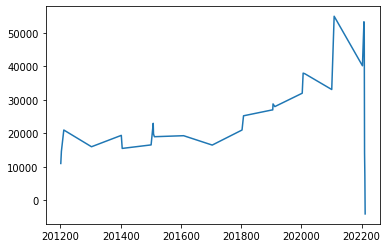

A12086001_50


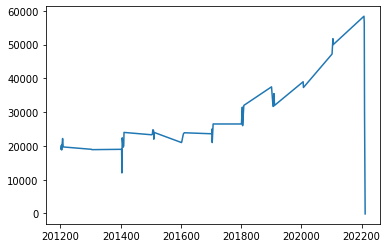

A12086001_60


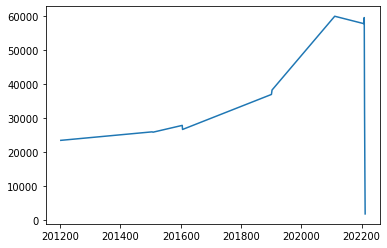

A12086001_70


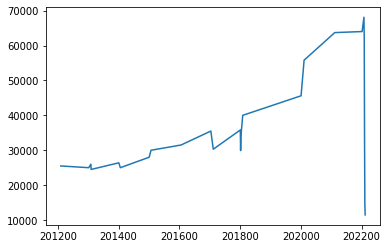

A12086001_90


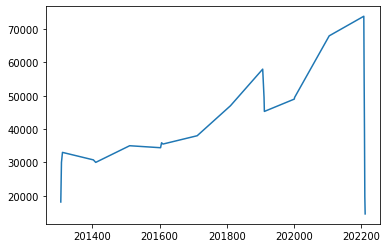

In [68]:
for i in gizun_code_areas:
    x = df_a['YYYYMM'][df_a['apart_code_area']==i]
    y = df_a['prices'][df_a['apart_code_area']==i]
    plt.plot(x,y)
    print(i)
    plt.show()

In [ ]:
df_a